# TR-Santé : Observe bacteria interaction to define the relations

**Introduction :** The main goal of this project is to determine the relations between bacteria. 
Indeed, there are two main processes for bacteria to exchange biological information through DNA :

- **HGT : Horizontal Gene Transfer**

This process has been studied already (*cf bibliography*), in general it concerns transfer of genes situated far away.
- **HAT : Horizontal Allele Transfer**

This process is also called 'recombination', it concerns in general genes that are situated at the same place between bacteria.

## First step : Comparing two genomes of bacteria

In [204]:
# Import the necessary modules
import os
from subprocess import call
import re
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import math
import bisect
import numpy as np
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import set_link_color_palette
from matplotlib.colors import ListedColormap
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio import Phylo
from Bio import SeqIO
from Bio.Blast import NCBIXML
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import Voronoi


In [8]:
# Set the names of the two bacteria
bacteria1 = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta"
bacteria2 = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_AP017617.1.fasta"

### Using Mummer

We will first use mummer to compare the genomes of two bacteria.
Here the code is very simple, we only use the 'mum' attribute, which is computing the maximal matches that are unique in both sequences.
We then plot a histogram with a log-log scale to interpret the results.

mummer -mum /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_AP017617.1.fasta


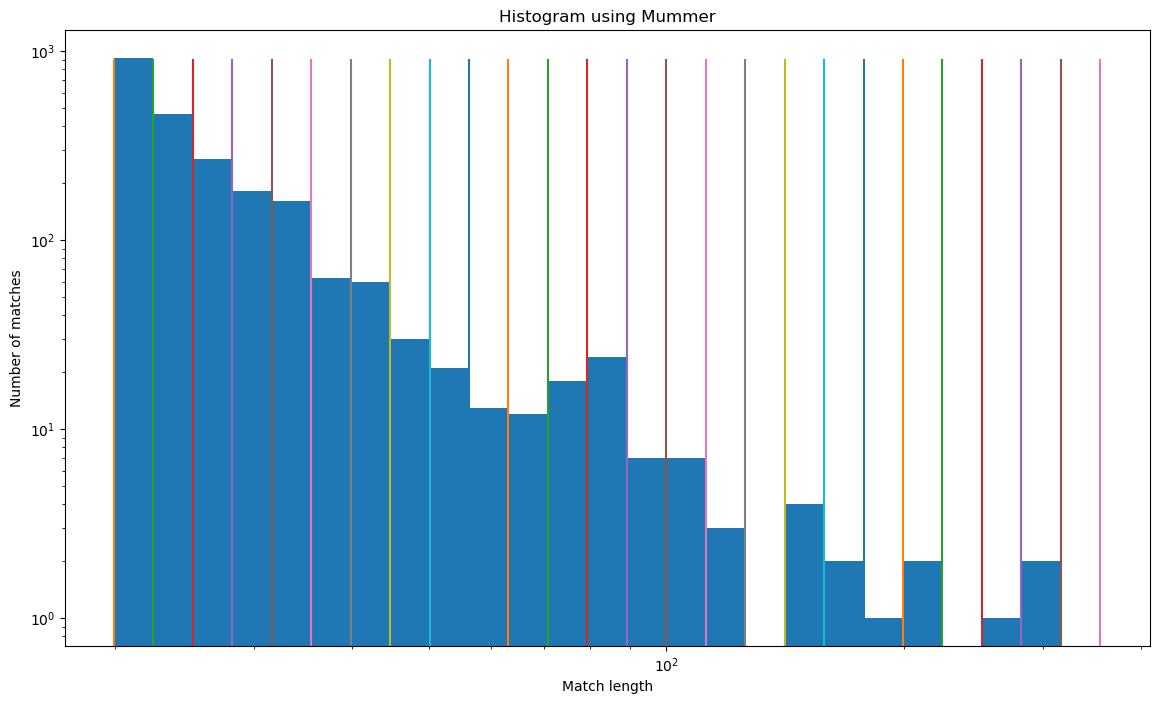

In [9]:
# Use mummer to compare the genomes of the two bacteria
print("mummer", "-mum", bacteria1, bacteria2)
#mummer_init = subprocess.run("conda activate bio")
mummer_output = subprocess.run(["mummer", "-mum", bacteria1, bacteria2], capture_output=True, cwd='/')

# Parse the output from mummer to get the list of matches
matches = []
for line in mummer_output.stdout.splitlines():
    if line.startswith(b" "):
        
        # This line contains a match, so get the length of the match
        match_length = int(line.split()[-1])
        matches.append(match_length)

# Plot the graph of the number of matches according to the length of the segments
bins = [10**(i/20) for i in range(26, 52)]
plt.figure(figsize=(14, 8))
pl.hist(matches, bins=bins)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
for bin in bins[:34]:
    plt.plot([bin,bin], [0, 900])
pl.xlabel("Match length")
pl.ylabel("Number of matches")
plt.title("Histogram using Mummer")
pl.show()

Now we will go further by adding more attributes to the mummer command : 
- First the 'maxmatch' attribute, which will compute all maximal matches regardless of their uniqueness.
- Then the '-b' option to calculate the pairings on the complementary strands.
- Finally the '-n' attribute to exclude nucleotides for which we have no information.

Then we also plot few power-law which should be rightly representing our results because of the theory of gene transfer.

In [10]:
# Use mummer to compare the genomes of the two bacteria
print("mummer", "-maxmatch", "-n", "-b", bacteria1, bacteria2)
#mummer_init = subprocess.run("conda activate bio")
mummer_output = subprocess.run(["mummer", "-maxmatch", "-n", "-b", bacteria1, bacteria2], capture_output=True, cwd='/')

# Parse the output from mummer to get the list of matches
max_matches = []
for line in mummer_output.stdout.splitlines():
    if line.startswith(b" "):
        # This line contains a match, so get the length of the match
        match_length = int(line.split()[-1])
        max_matches.append(match_length)


# compute the logarithmically binned histogram of the match lengths
#bins = [10**(i/35) for i in range(46, 105)]  # bins from 10 to 1e4
#hist, _ = np.histogram([m for m in max_matches], bins=bins)
matches_sorted = max_matches.sort()

mummer -maxmatch -n -b /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_AP017617.1.fasta


### Without logarithmic bining

We can plot first without logarithmic bining, then we will therefore have more points when we will reach long matches. It is a great first plot to see the repartition of matches and to compare to known-models.
To do so, we first create a function named `count_occurences` to know the number of matches associated to each length.

In [11]:
def count_occurrences(numbers):
  # Create a new list to store the results
  results = []

  # Create a variable to store the current number we are counting
  current_number = None

  # Create a variable to store the current number of occurrences
  current_count = 0
  
  # Iterate over the numbers in the list
  for number in numbers:
    # If the current number is different from the number we are counting,
    # add the current number and its count to the results list, and reset
    # the current number and count
    if number != current_number:
      if current_number is not None:
        results.append([current_number, current_count])
      current_number = number
      current_count = 0

    # Increment the current count
    current_count += 1

  # Add the final number and its count to the results list
  results.append([current_number, current_count])

  return results

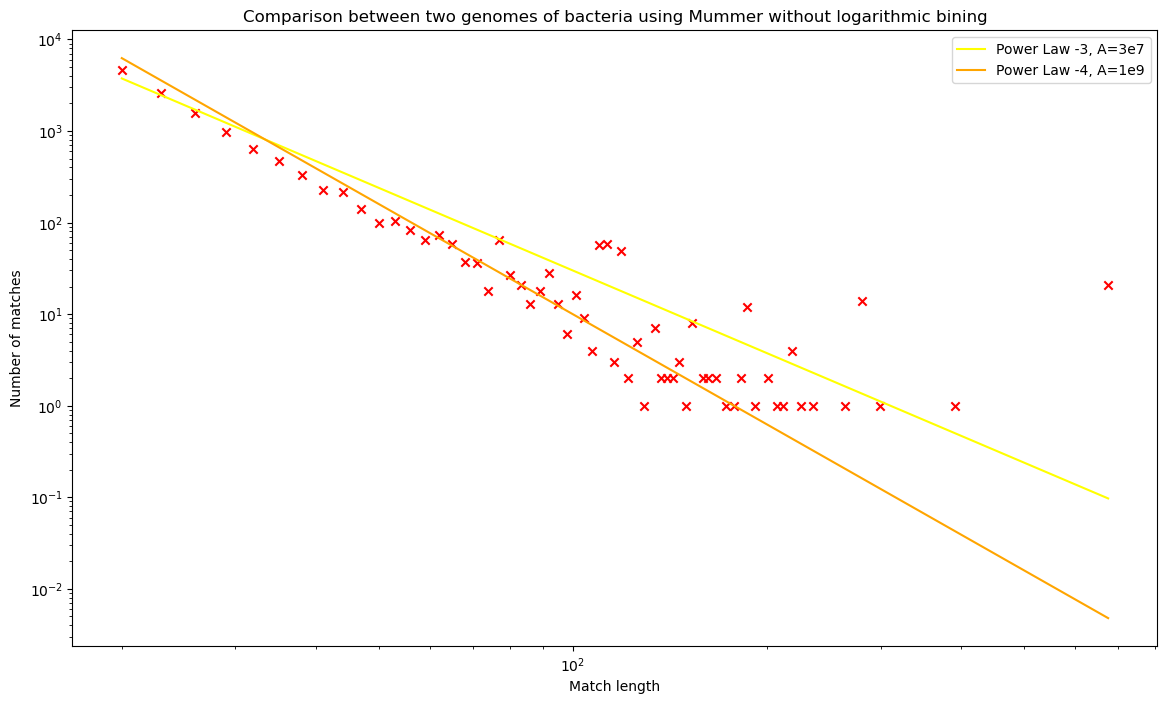

In [12]:
matches_sorted = count_occurrences(max_matches)
segment_lengths, occurrences = zip(*matches_sorted)


# Create the logarithmic bins using numpy
bins = np.logspace(np.log10(min(segment_lengths)), np.log10(max(segment_lengths)), 10)
plt.figure(figsize=(14, 8))
# Plot the logarithmic bins using matplotlib
#plt.hist(segment_lengths, bins=bins, weights=occurrences)
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**7/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins, Powerlaw_3, color = 'yellow', label = 'Power Law -3, A=3e7')
plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=1e9')
plt.scatter(segment_lengths[::3], occurrences[::3], color = 'r', marker = 'x')
plt.xscale('log')
plt.title('Comparison between two genomes of bacteria using Mummer without logarithmic bining')
plt.yscale('log')
plt.legend()
plt.show()

We have got our first plot of a third of our lengths !
A first interesting point is that it seems that our matches tend to respect the power-law models, even though there are still noise to work on.

### With logarithmic bining

Now we are going to use something called a ``logarithmic bining``. 

The logarithmic bining is a method used in order to represent points in a log-log graph, regrouping them in bins by dividing the number of matches in that bin by the size of the bin. 

Therefore, we reduce the noise that might appears with large matches and we obtain one point for each bin.
We can then try to find bins to rightly tackle our comparison of bacteria.

First we create few functions to find the right bins, to regroup matches and to divide by the length of the bin.

In [13]:
def match_check(match):
    new_match = []
    for new, element in match:
        new_match.append(new)
    return new_match

def floor_numbers(numbers):
    return [math.floor(number) for number in numbers]

def find_interval(sorted_list, number):
    # Find the index of the number in the sorted list using bisect_left
    import bisect
    index = bisect.bisect_left(sorted_list, number)   
    # Return the number divided by the length of the interval
    return index

def calculate_bins(index, bins, list_sorted):
    """
    Given a list of bins, a sorted list and an index, return as an output the bining associated to 
    """
    # Given a list of bins, do the calculation of the mean of the length
    num_list = []
    len_list = []
    for len, num in list_sorted :
        num_list.append(num)
        len_list.append(len)
    interval = find_interval(bins, index)
    interval_check = interval
    sum = 0
    count_length = 0
    while interval_check == interval :
        if index in match_check(list_sorted): 
            i = bisect.bisect_left(len_list, index)
            sum += num_list[i]
            index += 1
            count_length += 1
            interval = find_interval(bins, index)
        else:
            index += 1
            count_length += 1
            interval = find_interval(bins, index)
    return sum/count_length, index

Now we can plot our Mummer method with logarithmic bining, we will compare it to the power-law models :

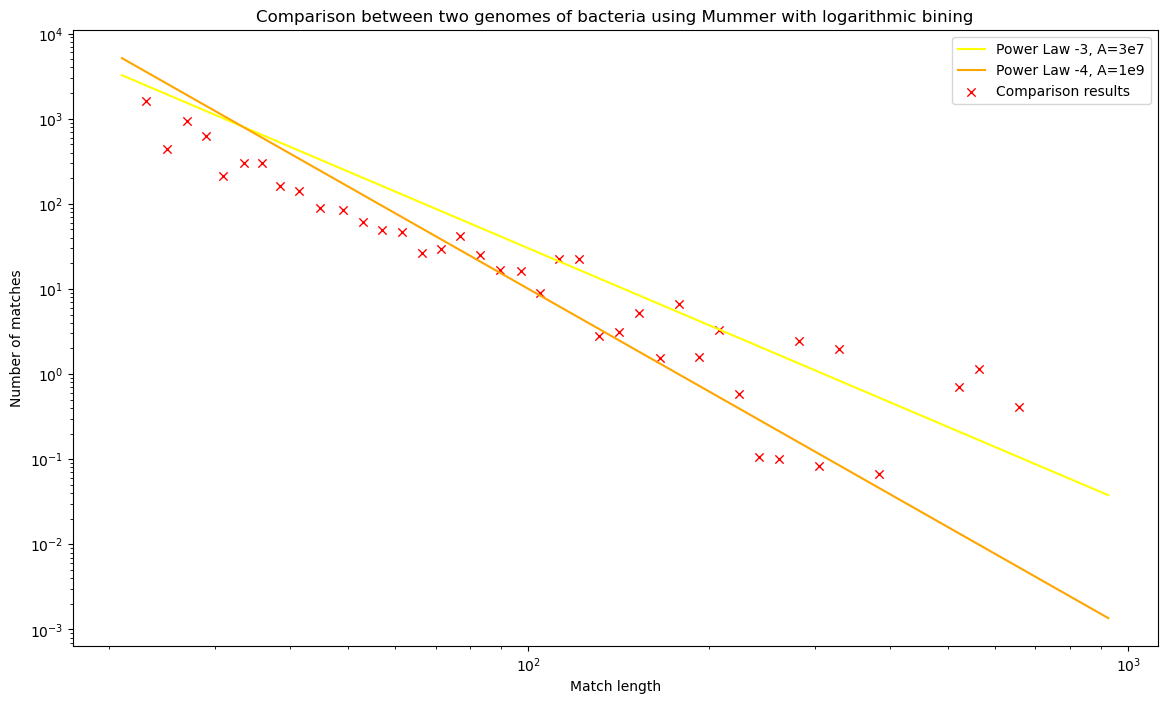

In [14]:
matches_sorted = count_occurrences(list(max_matches))
bins = floor_numbers([10**(i/30) for i in range(40, 90)])
hist, pos = [], []
index = 0

while index <= matches_sorted[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, matches_sorted)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg
plt.figure(figsize=(14, 8))
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**7/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins, Powerlaw_3, color = 'yellow', label = 'Power Law -3, A=3e7')
plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=1e9')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.title('Comparison between two genomes of bacteria using Mummer with logarithmic bining')
plt.legend(loc = 1)
plt.show()


Thanks to logarithmic bining we have been able to reduce significantly the noise with huge lengths. Now that the graph is smoother, the power-models are even more precise and it is interesting to see that each model has few points that are sticking to it.

The main issue with Mummer is that it takes too much time to deal with short matches, ie matches that are smaller than 20 nucleotides. It takes way too long to process so we have to find a solution, `Nucmer` !

### Using Nucmer

To use Nucmer, we will do approximatively the same method used with Mummer for the beginning : opening the Ubuntu terminal, running the command and storing the output (there in a new file).

In [15]:
# run nucmer to compare the genomes and save the output in a file
output_file = "output_nucmer.coords"
subprocess.run(["nucmer", "-l","20","-maxmatch","-o", "-p", "output_nucmer", bacteria1, bacteria2], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
sum = 0


# parse the nucmer output file to extract the matches and their lengths
matches_n = []
with open(output_file) as f:
    lines = f.readlines()
    # I do the next step because of a weird problem regarding len(lines)
    len_lines = 0
    for element in lines :
        len_lines += 1
    for index in range(6, len_lines):
        line = lines[index]
        sum += 1
        fields = line.strip().split()
        matches_n.append(int((int(fields[6]) + int(fields[7]))/2))

# compute the logarithmically binned histogram of the match lengths
matches_sorted_n = matches_n.sort()


The main difference with Nucmer is that it does not return the lengths of the match directly but zones that contains almost perfect matches.

Our technique will be to explore each zone and to extract all of the exact matches, it will considerably reduce the processing time !
To do so, we use the `show-aligns` method, still using the Ubuntu terminal.

In [16]:
show_aligns_output = subprocess.run(["show-aligns", "-r", "output_nucmer.delta", "NC_020307.1", "NZ_AP017617.1"], capture_output = True)
segments_l, segments_l_new = [], []
for line in show_aligns_output.stdout.splitlines():
    segments_l.append(line)
for line in segments_l[4:]:
    line = line.decode()
    segments_l_new.append(line)

We can now look at what the output looks like : a succesion of lines with segments comparison. What will be interesting is to use the third line of the comparison, fully constitued of empty spaces and "^". We will store each length of segments by only looking at those lines.

In [17]:
segments_l_new[:10]

['',
 '-- BEGIN alignment [ +1 8691 - 9285 | -1 2357265 - 2356672 ]',
 '',
 '',
 '8691       ttaattgcaggcataaaaaaaccagccctgagaggctggtttttaaggg',
 '2357265    ttaaatgcagatataaaaaaaccaaccgt.aaaggttggttttt.ttgg',
 '               ^     ^^            ^  ^ ^ ^   ^        ^^^  ',
 '',
 '8740       gaattttggtcggcacgagaggatttgaacctccgacccccgacacccc',
 '2357218    gatttttggtcggcacgagaggatttgaacctccgacccccgacacccc']

We will first have to separate each zone with the function written below :

In [18]:
def separate_segments(lines):
    segments = []
    segment = []
    in_segment = False
    for line in lines:
        if line.startswith("-- BEGIN "):
            in_segment = True
        elif line.startswith("--   END "):
            in_segment = False
            segments.append(segment[2:-2])
            segment = []
        elif in_segment:
            segment.append(line)
    return segments

Then we have several steps to get only the lines that are intersting, erasing the beginning of each line which is basically only empty space and to not take part into the length of the segments.

In [19]:
segments_sep = separate_segments(segments_l_new)
segments_sep.insert(0, '') 

new_list = []
for element in segments_sep:
    new_list.append(element[2::4])

new_list = new_list[1:]
lines_phrase =[]

for zone in new_list:
    phrase = ''
    for bout in zone:
        phrase += str(bout[15:])
    lines_phrase.append(phrase)
for phrase in lines_phrase[::1000]:
    print(phrase)

^     ^^            ^  ^ ^ ^   ^        ^^^                                                                                ^    ^         ^^      ^  ^   ^      ^^^  ^ ^^^                                   ^     ^     ^  ^    ^ ^  ^   ^ ^   ^  ^  ^ ^      ^ ^    ^  ^  ^^  ^^  ^  ^^ ^  ^ ^         ^  ^        ^   ^   ^  ^  ^            ^^ ^^^  ^  ^  ^  ^          ^   ^  ^^ ^ ^  ^ ^^     ^  ^  ^         ^^  ^             ^              ^   ^       ^        ^  ^  ^^                ^     ^  ^    ^     ^ ^^  ^  ^           ^  ^        ^   ^^      


Now that we are able to have only the interesting parts, we can store all the segments in a list using the following method.

In [20]:
segment_lengths = []
for phrase in lines_phrase:
    ln_seg = 0
    indice = 0
    len_phrase = 0
    for charac in phrase:
        len_phrase += 1
    while indice < len_phrase:
        if phrase[indice] == ' ':
            ln_seg += 1
            indice += 1
        else:
            if ln_seg == 0:
                indice += 1
            else:
                segment_lengths.append(ln_seg)
                indice += 1
                ln_seg = 0    
                
segment_lengths_sorted = segment_lengths.sort()
show_aligns_segments = count_occurrences(segment_lengths)

Then we can plot with the same method used before the lengths of the segments, which is now including lengths which are lower than 10 nucleotides.

We can plot the histogram (which is not really logarithmic bining because it is not divided by the length of the bin).

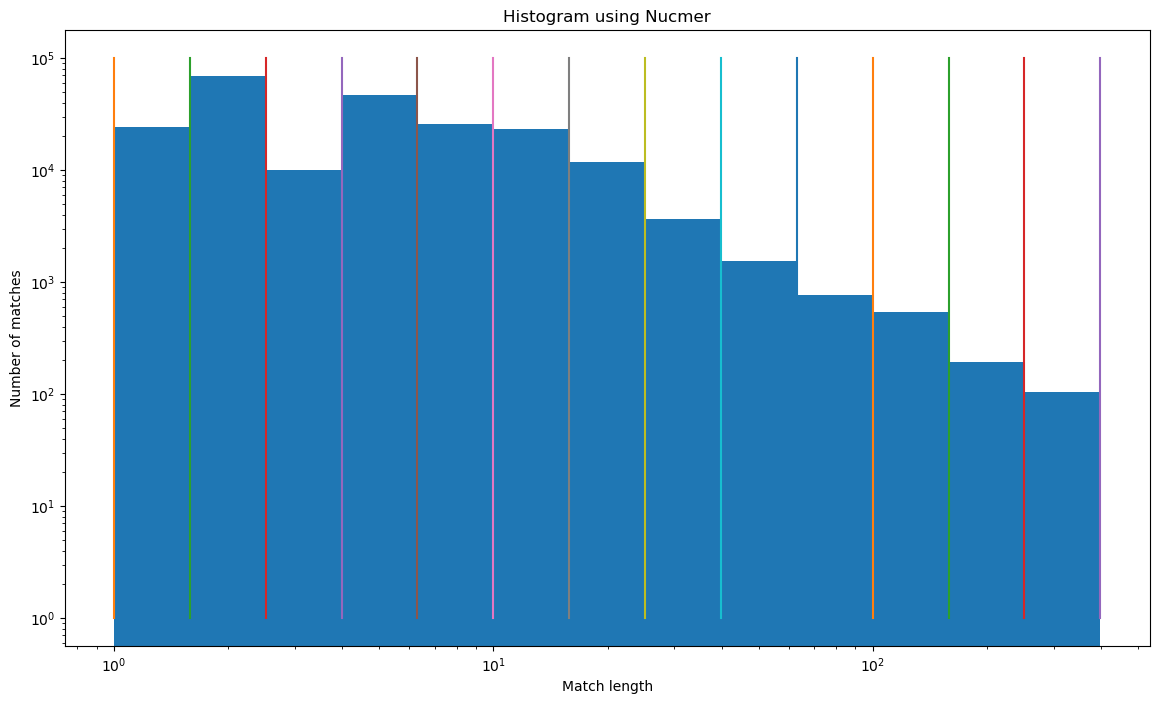

In [21]:
bins = [10**(i/5) for i in range(0, 14)]
plt.figure(figsize=(14, 8))
pl.hist(segment_lengths, bins=bins)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
for bin in bins:
    plt.plot([bin,bin], [1,100000])
pl.xlabel("Match length")
pl.ylabel("Number of matches")
plt.title("Histogram using Nucmer")
pl.show()

We can plot without logarithmic bining, even though it seems that it won't be very useful because of the fact that data is not identically distributed.

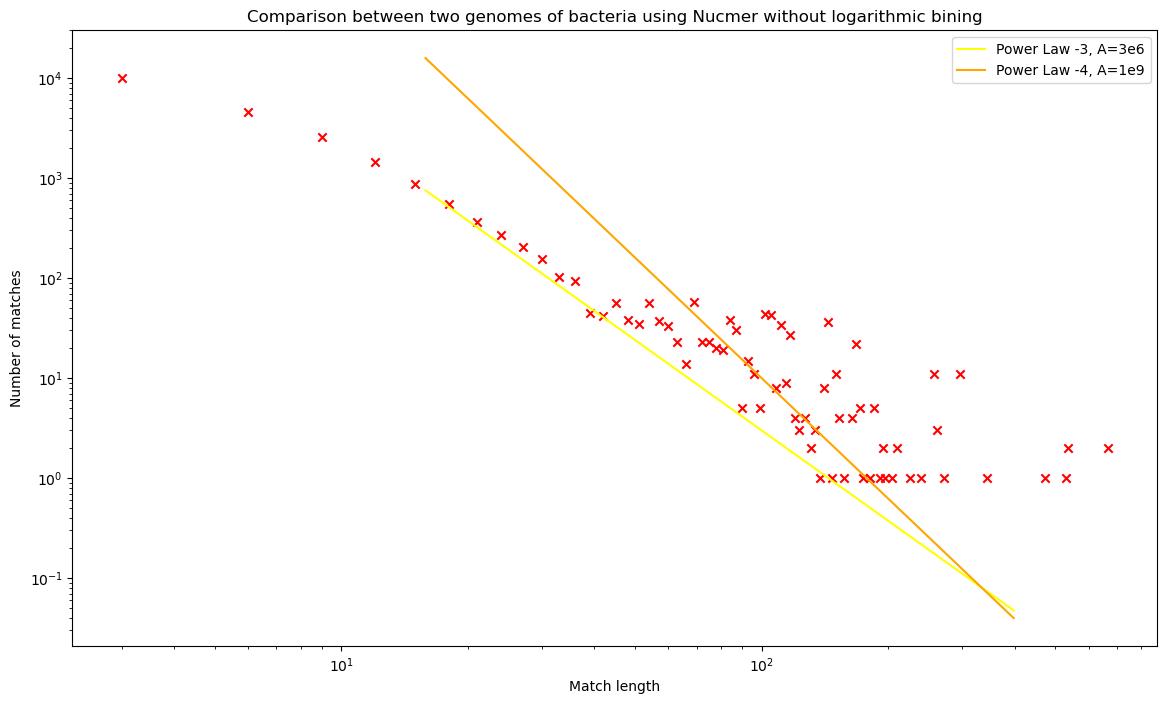

In [22]:
segment_lengths, occurrences = zip(*show_aligns_segments)
plt.figure(figsize=(14, 8))
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**6/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins[6:], Powerlaw_3[6:], color = 'yellow', label = 'Power Law -3, A=3e6')
plt.plot(bins[6:], Powerlaw_4[6:], color = 'orange', label = 'Power Law -4, A=1e9')
plt.scatter(segment_lengths[2::3], occurrences[2::3], color = 'r', marker = 'x')
plt.xscale('log')
plt.title('Comparison between two genomes of bacteria using Nucmer without logarithmic bining')
plt.yscale('log')
plt.legend()
plt.show()

It is somehow interesting because we observe a kind of threshold situated at the 40th length, with a weird form then.

Then we apply our logarithmic bining to plot our comparison :

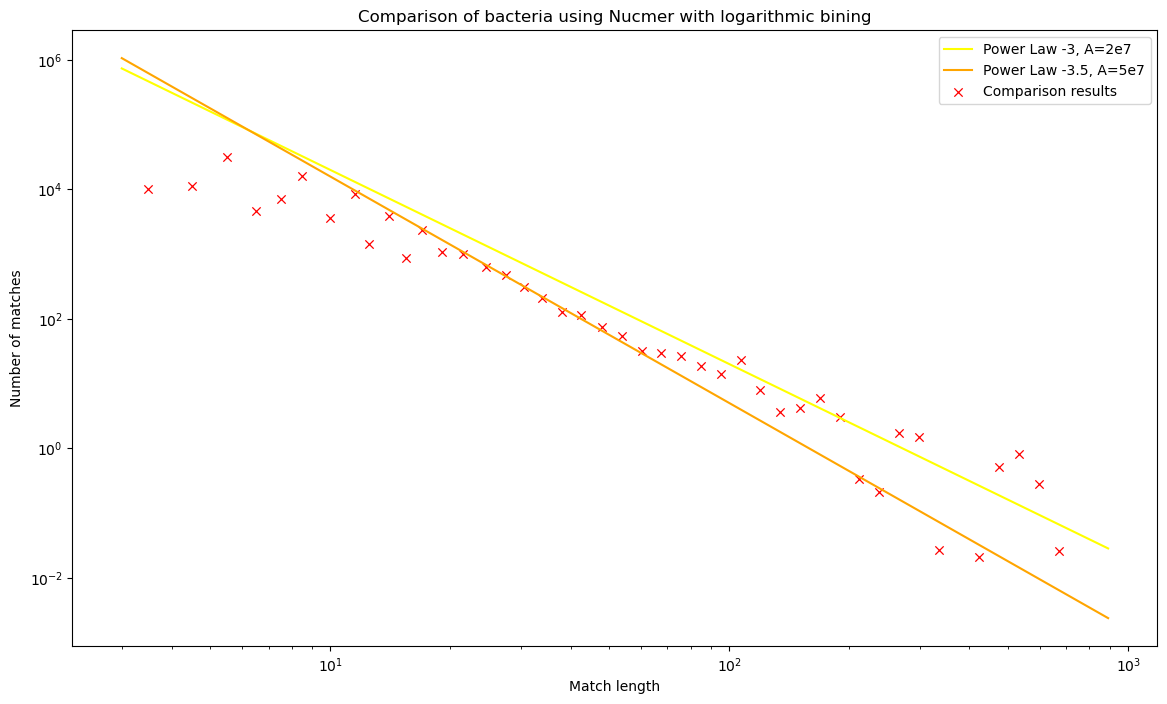

In [23]:
plt.rcdefaults()
bins = floor_numbers([10**(i/20) for i in range(7, 60)])
hist, pos = [], []
index = 0
while index <= show_aligns_segments[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg
plt.figure(figsize=(14, 8))
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")

# Calculate best fit line
Powerlaw_3 = [2*10**7/x**3 for x in bins]
Powerlaw_4 = [5*10**8/x**4 for x in bins]
Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
#plt.plot(pos[1:14], fit, 'r', label='Fit')
plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'orange', label = 'Power Law -3.5, A=5e7')
#plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 0.9, c = 'r',label = 'Comparison results')
plt.title('Comparison of bacteria using Nucmer with logarithmic bining')
plt.legend(loc = 1)
plt.show()

There I plotted two power laws : a -3 and a -3,5. They are the more accurate ones are respect the shape of the points.  
The power law is thus mainly respected between the two bacteria !

Now something interesting would be to clean our data : as we can see in the previous graph, despite the use of the logarithmic bining there is still some noise.  
Then we can use few functions in order to remove outlyers and to smooth the plot.  
Consequently, we will try to not loose too much information while fitting the data as righly as we can.

[0, 0.0, 0.5, 1.75, 2.875, 5.9375, 7.96875, 9.984375]


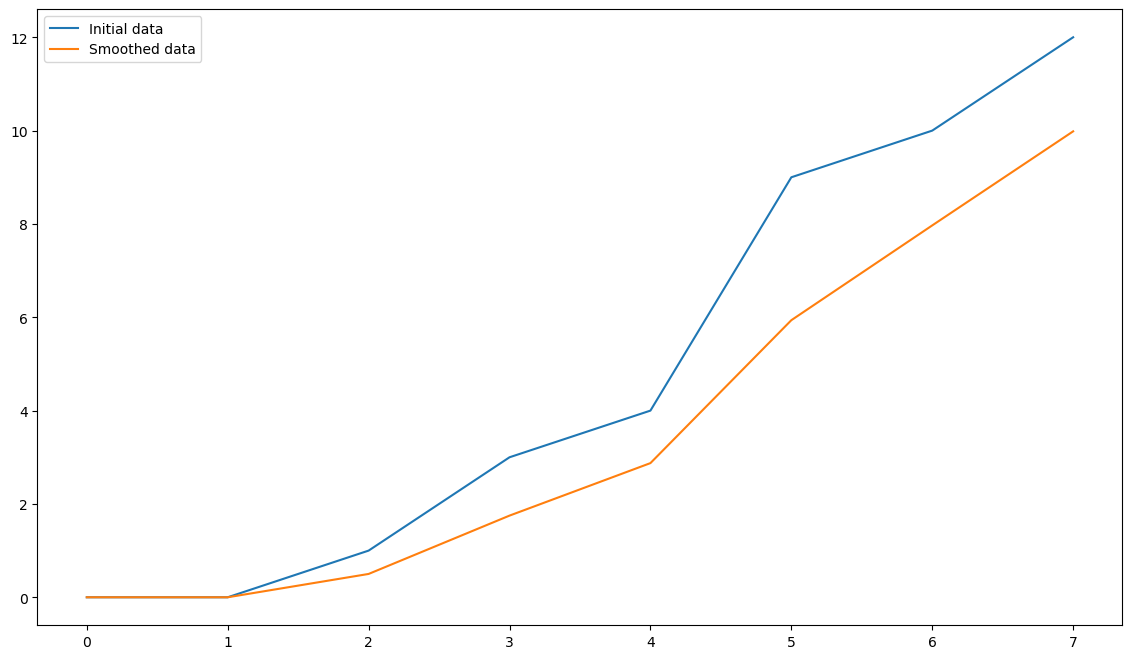

In [24]:
def erase_inf(log):
    for i in range(len(log)) :
        number = log[i]
        if number == np.inf or number == -np.inf :
            log[i] = (log[i - 1] + log[i + 1])/2

def smooth_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Test the function
points = [0, 0, 1, 3, 4, 9, 10, 12]
smoothed_points = smooth_curve(points, factor=0.5)
plt.figure(figsize=(14, 8))
print(smoothed_points)  # [0, 0, 0.5, 1.5, 3.5, 6.5, 9.5, 11]
plt.plot(points, label = 'Initial data')
plt.plot(smoothed_points, label = 'Smoothed data')
plt.legend()

import numpy as np

import numpy as np

def remove_outliers_pairwise(x, y, threshold=1):
    """
    Removes outliers from the input data using the Z-score method.
    Outliers are defined as points that are more than 'threshold' standard deviations
    away from the mean.
    """
    # Zip the x and y arrays and treat each pair as a single data point
    data = np.column_stack((x, y))
    # Calculate the mean and standard deviation of the d
    # ata
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    # Calculate the Z-scores of each data point
    z_scores = (data - mean) / std
    # Filter out any data points with a Z-score greater than the threshold
    filtered_data = data[np.all(np.abs(z_scores) <= threshold, axis=1)]
    # Unzip the filtered data back into separate x and y arrays
    x_filtered, y_filtered = filtered_data[:, 0], filtered_data[:, 1]
    return x_filtered, y_filtered


There we show an example of how we can smooth a random initial data. The orange graph is representing the smoothed data, we will follow this example for our data.  
Now we will apply this to our data :

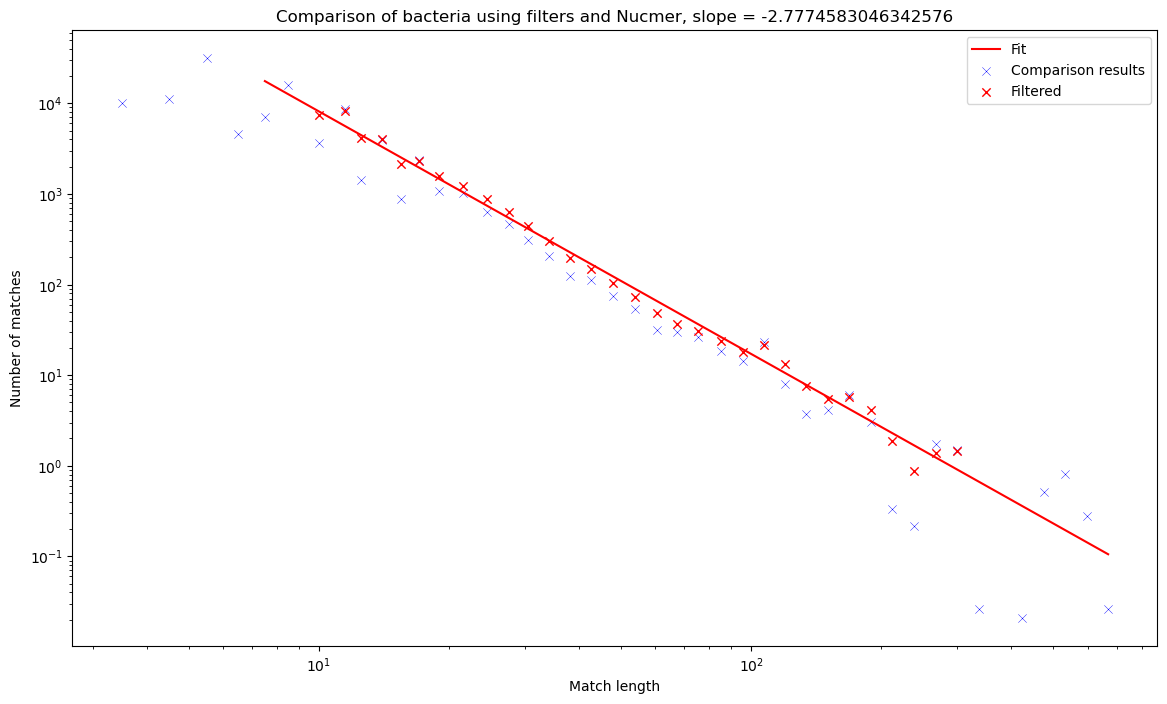

In [25]:
bins = floor_numbers([10**(i/20) for i in range(7, 60)])
hist, pos = [], []
index = 0
while index <= show_aligns_segments[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg
plt.figure(figsize=(14, 8))
hist_filtered =  smooth_curve(hist, factor = 0.4)
pos_filtered, hist_filtered = remove_outliers_pairwise(pos, hist_filtered)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")

logx = np.log10(pos_filtered[1:])
logy = np.log10(hist_filtered[1:])
erase_inf(logy)
coeffs = np.polyfit(logx[:14], logy[:14], 1)
coeffs1 = np.polyfit(logx[5:], logy[5:], 1)
# Calculate best fit line
fit = 10 ** (coeffs[1]) * pos[1:14] ** coeffs[0]
fit1 = 10 ** (coeffs1[1]) * pos[5:] ** coeffs1[0]
Powerlaw_3 = [2*10**7/x**3 for x in bins]
Powerlaw_4 = [5*10**8/x**4 for x in bins]
Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
#plt.plot(pos[1:14], fit, 'r', label='Fit')
plt.plot(pos[5:], fit1, 'r', label='Fit')
#plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
#plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'magenta', label = 'Power Law -3.5, A=5e7')
#plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 0.3, c = 'b',label = 'Comparison results')
plt.scatter(pos_filtered[1:], hist_filtered[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Filtered')
plt.title('Comparison of bacteria using filters and Nucmer, slope = ' + str(coeffs[0]))
plt.legend(loc = 1)
plt.show()

It is quite interesting because now the points seem to follow a more precise power-law.  
Thanks to this behaviour, we can rightly plot the straight line fitting our data !

## The comparison function : `compare_2_genomes`

We will now group the previously written functions in order to automate our process.

In [26]:
def get_filename_wo_fasta(path) -> str:
    data = []
    with open(path, "r") as f:
    # Read the contents of the files
        for line in f:
            data.append(line)
    input_string = data[0]
    words = input_string.split()
    return words[0][1:] 
    
def remove_commas(string):
    # Replace commas with an empty string
    new_string = string.replace(",", "")
    return new_string
    
def get_genome(input_string: str) -> str:
    # Split the input string into a list of words
    words = input_string.split()
    
    # Check if the input string contains "complete genome" or "complete sequence"
    if "genome" in input_string:
        # Find the index of the "complete genome" word
        genome_index = words.index("complete")
    elif "sequence" in input_string:
        # Find the index of the "complete sequence" word
        genome_index = words.index("complete")
    else:
        # Return an empty string if neither "complete genome" nor "complete sequence" is present
        return ""
    
    # Check if the word "chromosome" is in the input string
    if "chromosome," in words:
        # Return the two words preceding "complete genome" or "complete sequence"
        return f"{words[genome_index - 2]} {words[genome_index - 1]}"
    else:
        # Return the word preceding "complete genome" or "complete sequence"
        return words[genome_index - 1]

def get_filename(filename) -> str:
    data = []
    with open(filename, "r") as f:
    # Read the contents of the files
        for line in f:
            data.append(line)
    input_string = data[0]
    words = input_string.split()
    return words[0][1:] + '.fasta'

def get_family(input_string: str) -> str:
    # Split the input string into a list of words
    words = input_string.split()
    return words[1] + ' ' + words[2]

def get_name_and_family(filename):
    data = []
    with open(filename, "r") as f:
    # Read the contents of the files
        for line in f:
            data.append(line)
    return remove_commas(get_genome(data[0])), get_family(data[0])

def replace_spaces_with_underscores(string):
    # Replace spaces with underscores
    new_string = string.replace(" ", "_")
    return new_string

In [27]:
def compare_2_genomes(genome1, genome2):
    # run nucmer to compare the genomes and save the output in a file
    output_file = "output_nucmer.coords"
    subprocess.run(["nucmer", "-l","20","-maxmatch","-o", "-p", "output_nucmer", genome1, genome2], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    sum = 0


    # parse the nucmer output file to extract the matches and their lengths
    matches_n = []
    with open(output_file) as f:
        lines = f.readlines()
        # I do the next step because of a weird problem regarding len(lines)
        len_lines = 0
        for element in lines :
            len_lines += 1
        for index in range(6, len_lines):
            line = lines[index]
            sum += 1
            fields = line.strip().split()
            matches_n.append(int((int(fields[6]) + int(fields[7]))/2))

    # compute the logarithmically binned histogram of the match lengths
    matches_sorted_n = matches_n.sort()
    show_aligns_output = subprocess.run(["show-aligns", "-r", "output_nucmer.delta", get_filename_wo_fasta(genome1), get_filename_wo_fasta(genome2)], capture_output = True)
    segments_l, segments_l_new = [], []
    for line in show_aligns_output.stdout.splitlines():
        segments_l.append(line)
    for line in segments_l[4:]:
        line = line.decode()
        segments_l_new.append(line)
    segments_sep = separate_segments(segments_l_new)
    segments_sep.insert(0, '') 

    new_list = []
    for element in segments_sep:
        new_list.append(element[2::4])

    new_list = new_list[1:]
    lines_phrase =[]

    for zone in new_list:
        phrase = ''
        for bout in zone:
            phrase += str(bout[15:])
        lines_phrase.append(phrase)
    segment_lengths = []
    for phrase in lines_phrase:
        ln_seg = 0
        indice = 0
        len_phrase = 0
        for charac in phrase:
            len_phrase += 1
        while indice < len_phrase:
            if phrase[indice] == ' ':
                ln_seg += 1
                indice += 1
            else:
                if ln_seg == 0:
                    indice += 1
                else:
                    segment_lengths.append(ln_seg)
                    indice += 1
                    ln_seg = 0    
                    
    segment_lengths_sorted = segment_lengths.sort()
    show_aligns_segments = count_occurrences(segment_lengths)
    bins = floor_numbers([10**(i/20) for i in range(7, 60)])
    hist, pos = [], []
    index = 0
    while index <= show_aligns_segments[-1][0] :
        hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
        hist.append(hist_bin)
        pos.append((index + agg) / 2)
        index = agg

    name1, family1 = get_name_and_family(genome1)
    name2, family2 = get_name_and_family(genome2)
    plt.figure(figsize=(14, 8))
    
    hist_filtered =  smooth_curve(hist, factor = 0.4)
    pos_filtered, hist_filtered = remove_outliers_pairwise(pos, hist_filtered)
    pl.gca().set_xscale("log")
    pl.gca().set_yscale("log")
    pl.xlabel("Match length")
    pl.ylabel("Number of matches")

    logx = np.log10(pos_filtered[1:])
    logy = np.log10(hist_filtered[1:])
    erase_inf(logy)
    
    coeffs = np.polyfit(logx[:14], logy[:14], 1)
    coeffs1 = np.polyfit(logx[5:], logy[5:], 1)
    # Calculate best fit line
    fit = 10 ** (coeffs[1]) * pos[1:14] ** coeffs[0]
    fit1 = 10 ** (coeffs1[1]) * pos[5:] ** coeffs1[0]
    Powerlaw_3 = [2*10**7/x**3 for x in bins]
    Powerlaw_4 = [5*10**8/x**4 for x in bins]
    Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
    #plt.plot(pos_filtered[1:14], fit, 'r', label='Fit')
    plt.plot(pos[5:], fit1, 'r', label='Fit')
    #plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
    #plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'magenta', label = 'Power Law -3.5, A=5e7')
    #plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
    plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 0.3, c = 'b',label = 'Comparison results')
    plt.scatter(pos_filtered[1:], hist_filtered[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Filtered')
    #plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Filtered')
    plt.title(name1 + '/' + family1 + ' and ' + name2 + '/' + family2 + ' Slope ' + str(coeffs1[0]))
    plt.legend(loc = 1)
    plt.show()

Now we can test with bacteria from our two families : Salmonella and Escheria_coli

In [28]:
bacteriaA = '/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_CP033635.1.fasta'
bacteriaB = '/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NZ_OU943337.1.fasta'

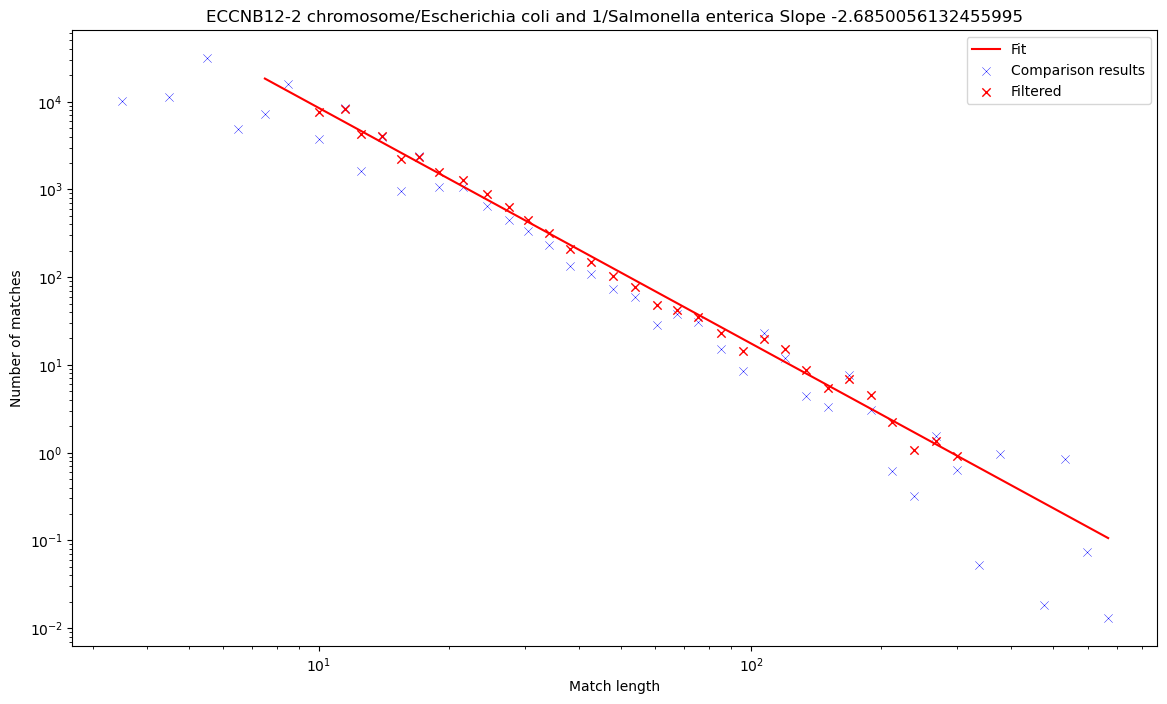

In [29]:
compare_2_genomes(bacteriaA, bacteriaB)

## Comparing a bacteria to a whole other family

Something interesting would be to compare the genome of a bacteria from the Salmonella family to the whole Escherichia coli family to see the differences.
First we will interest us on the different graphs to see weither there are or not many differences, and then we will compare by calculating the sum of the distances from a -3 or -4 slope straight line.

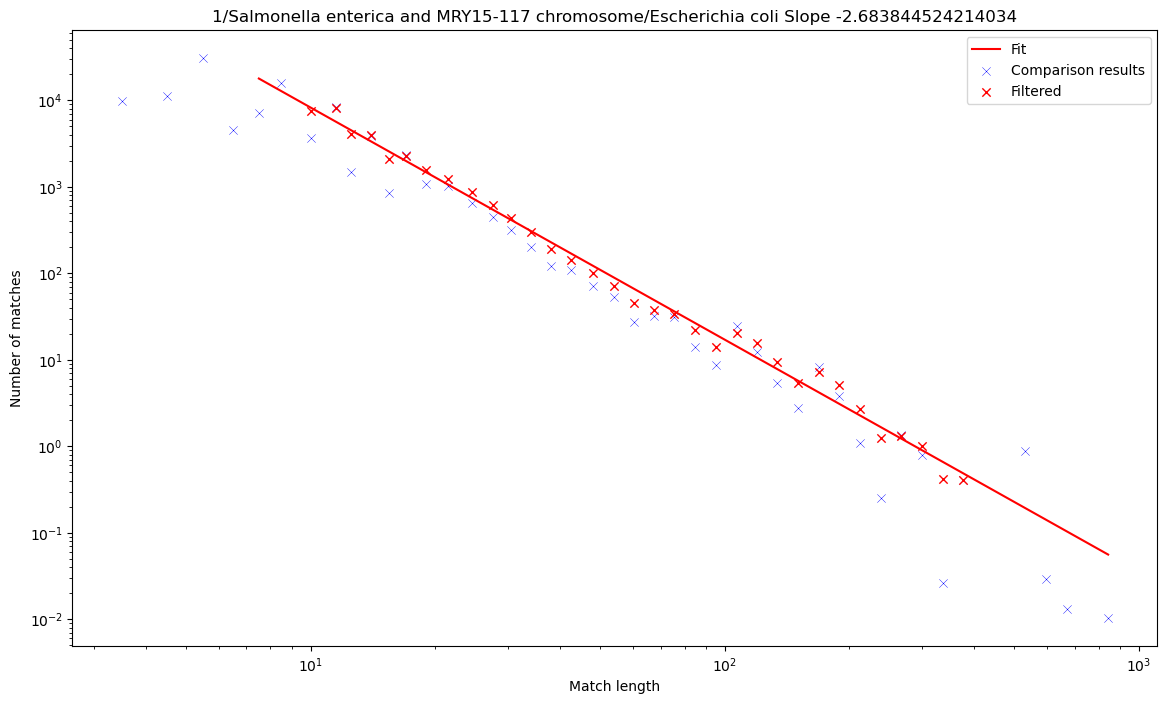

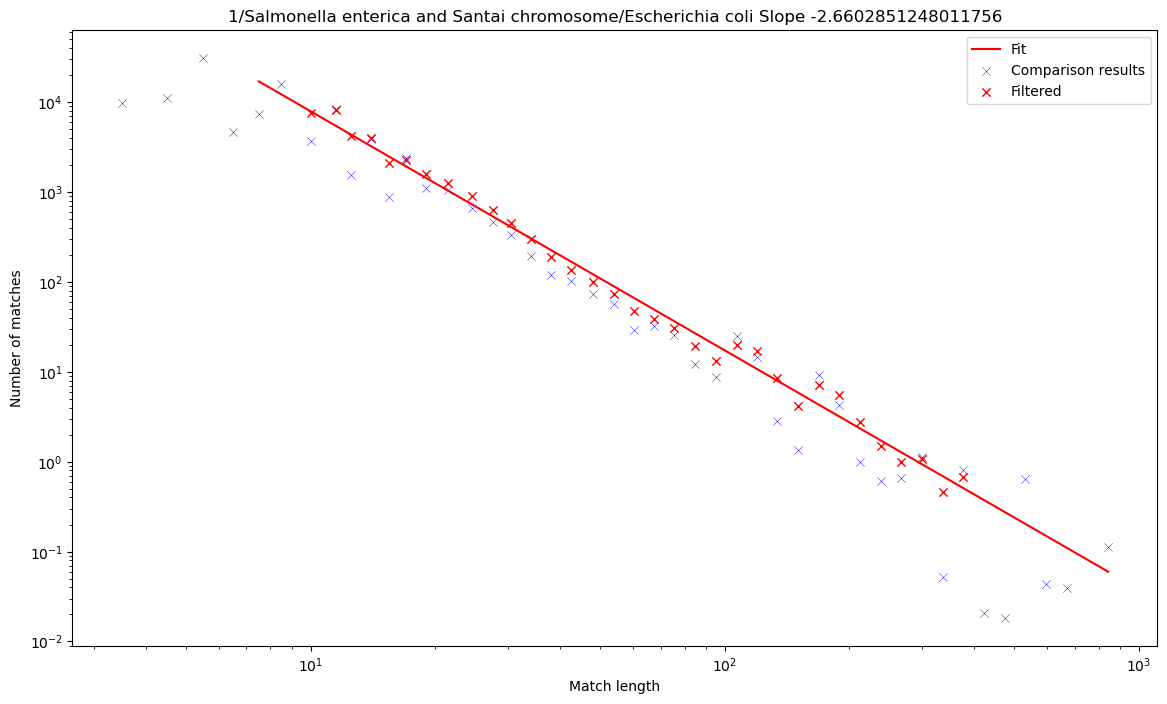

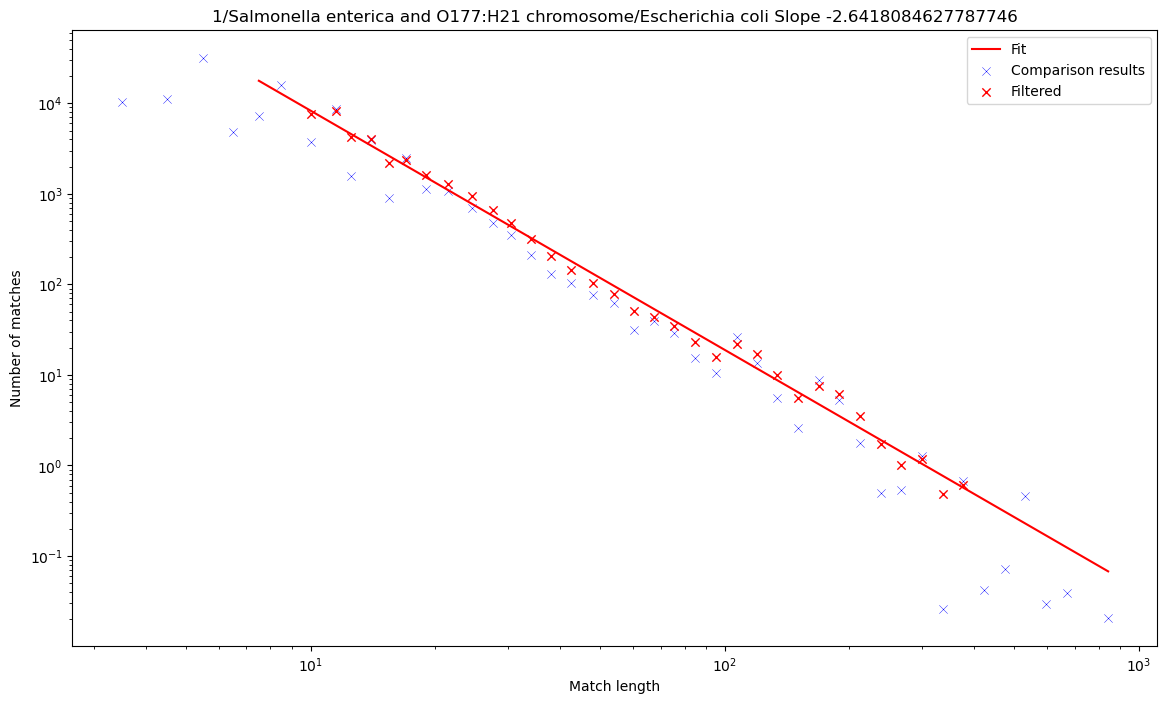

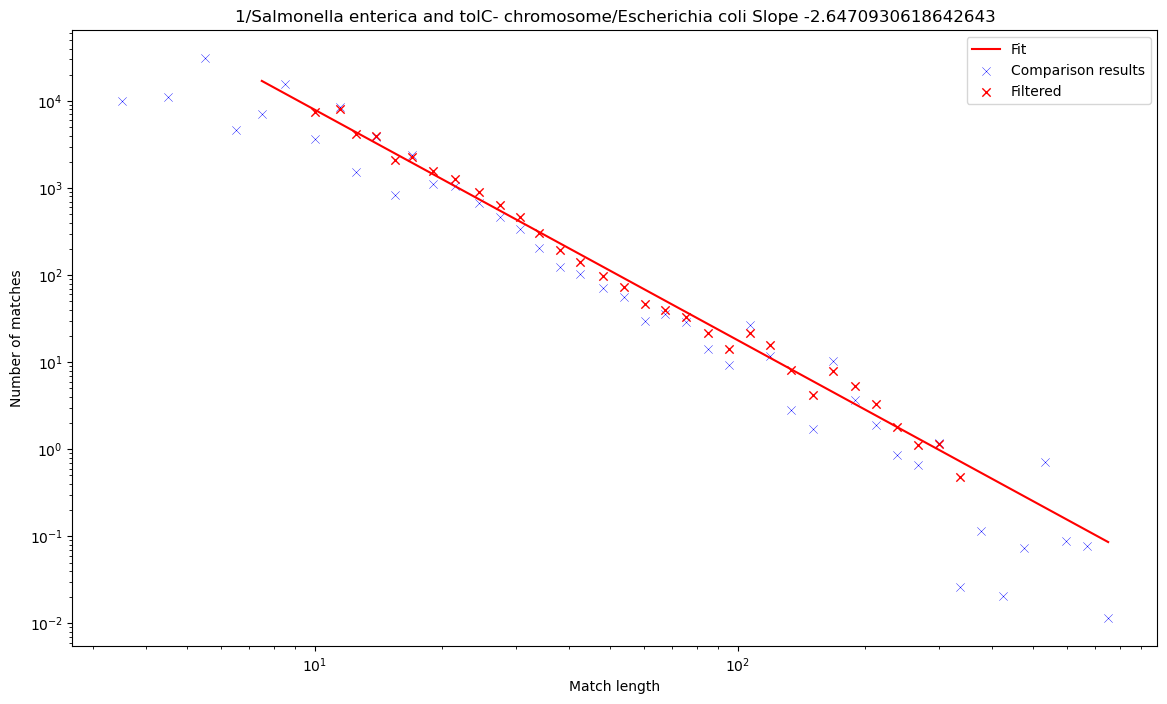

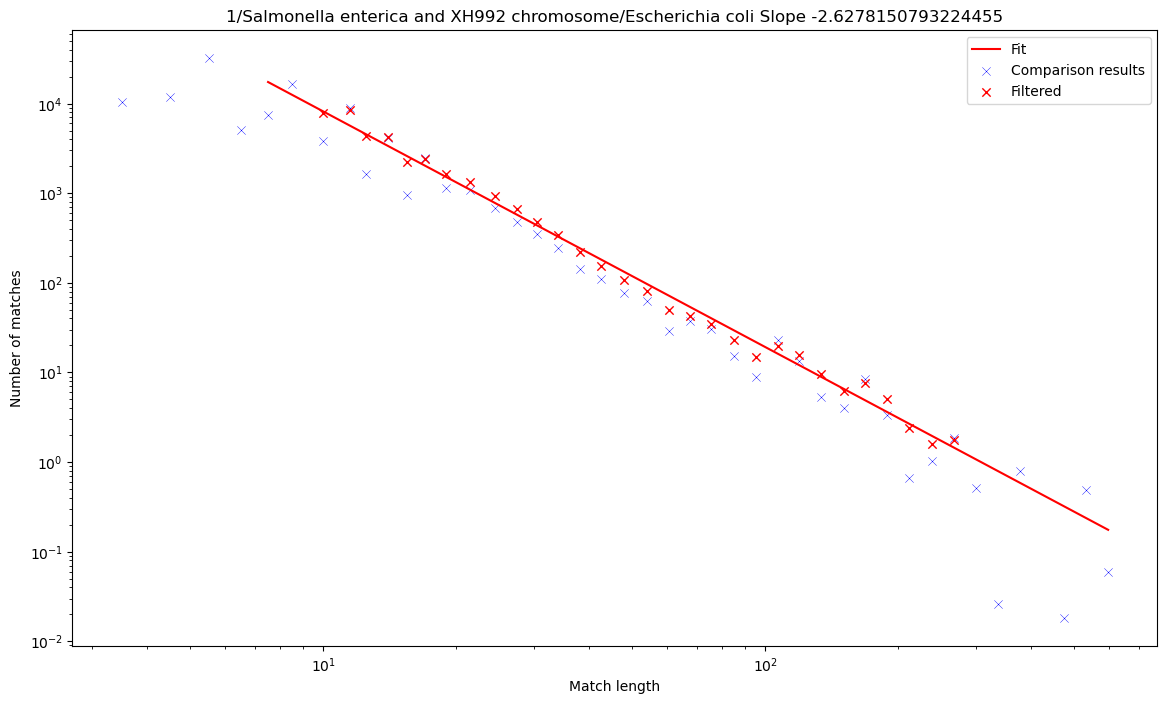

In [30]:
# Set the directory containing the files
directory = '/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli'

# Get the list of files in the directory
files = os.listdir(directory)
# Iterate over the files
for file in files[:5]:
    # Do something with the file
    compare_2_genomes(bacteriaB, directory + '/' + file)
    plt.show()

## Blast to create phylogenetic tree

We can use `Blast` to align our segments but using a more efficient method : we will have to do these operations many times, it has to be quick !  
Here the idea is to try to classify our bacteria using comparisons of genome.
- First we will compare two random genomes to store the 10 longer exact matches.
- Then we will compare the 10 sequences to all the bacteria from a specific folder (size n), we will then assign to a bacteria the weighted mean of the similarities to the 10 sequences.
- We will do this process for all pair of bacteria to create a matrix for each bacteria (the matrix is thus symmetrical so we have to do only n(n+1)/2 pairs).
- At this point we will have n distant matrixes (size nxn), we will then do a clustering method to classify our bacteria through a phylogenetic tree.
The thing is that this operation costs a lot of time, $10^3$ seconds for only 10 bacteria ...

In [31]:
def find_closest_blast(fasta_file, sequence_file, sequence):
    
    makeblastdb_exe = "/home/antoine/anaconda3/envs/bio/bin/makeblastdb"
    blastn_exe = "/home/antoine/anaconda3/envs/bio/bin/blastn"
    
    # Set the prefix for the output files
    output_prefix = "blast_output"
    segment_blast = []
    # Set the minimum length of matches to report
    min_match_length = 1
    
    # Create a BLAST database for each genome
    makeblastdb_cmd1 = [makeblastdb_exe, "-in", sequence_file, "-dbtype", "nucl", "-out", output_prefix + "_1"]
    makeblastdb_cmd2 = [makeblastdb_exe, "-in", fasta_file, "-dbtype", "nucl", "-out", output_prefix + "_2"]
    call(makeblastdb_cmd1)
    call(makeblastdb_cmd2)

    # Run BLAST to compare the two genome sequences
    blastn_cmd = [blastn_exe, "-db", output_prefix + "_1", "-query", fasta_file, "-out", output_prefix + ".out", "-outfmt", "6 qseqid sseqid pident length qstart qend sstart send"]
    call(blastn_cmd)

    # Read the matching segments from the BLAST output file
    with open(output_prefix + ".out") as blast_output:
        for line in blast_output:
            # Parse the fields from the BLAST output
            fields = line.strip().split()
            print(fields)
            # Extract the start and end positions of the matching segment in each genome
            genome1_start = int(fields[4])
            genome1_end = int(fields[5])
            genome2_start = int(fields[6])
            genome2_end = int(fields[7])

            # Calculate the length of the matching segment
            segment_length = genome1_end - genome1_start + 1
            segment_blast.append(segment_length)
            # Check if the segment is long enough to be reported
    #       if segment_length >= min_match_length:
    #            # Print the matching segment details
    #           print("Matching segment:")
    #           print("  Genome 1: positions {}-{}".format(genome1_start, genome1_end))
    #           print("  Genome 2: positions {}-{}".format(genome2_start, genome2_end))
    #           print("  Length: {} nucleotides".format(segment_length))
    #           print("")

    # Clean up the intermediate output files
    os.remove(output_prefix + "_1.nhr")
    os.remove(output_prefix + "_1.nin")
    os.remove(output_prefix + "_1.nsq")
    os.remove(output_prefix + "_2.nhr")
    os.remove(output_prefix + "_2.nin")
    os.remove(output_prefix + "_2.nsq")

    segment_blast_sorted = segment_blast.sort()
    segment_blast_sorted = count_occurrences(list(segment_blast))
    if segment_blast_sorted != [[None, 0]]:
        return 100 * (segment_blast_sorted[-1][0] / len(sequence))
    else:
        return 0

In [32]:
def find_closest_match(sequence, fasta_file):
    # Write the input sequence to a temporary FASTA file
    with open("temp.fasta", "w") as f:
        f.write(">query\n{}\n".format(sequence))

    # Set the BLAST command
    blast_command = "'/home/antoine/anaconda3/envs/bio/bin/blastn' -query /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/temp.fasta -subject {} -max_target_seqs 10 -outfmt 6".format(fasta_file)

    # Run the BLAST command and capture the output
    output = subprocess.run(blast_command, shell=True, capture_output=True)

  
    # Parse the output
    lines = output.stdout.decode("utf-8").split("\n")
    best_match = None
    best_similarity = 0
    sim_return = 0
    for line in lines:

        # Skip empty lines
        if not line:
            continue
        # Split the line into columns
        cols = line.split("\t")
        # Extract the identity column
        similarity = float(cols[3])/float(cols[7])
        # Update the best match if necessary
        if similarity > best_similarity:
            best_match = cols[1]
            best_similarity = similarity
            sim_return = cols[3]

    # Return the best match and its similarity
    return sim_return

In [33]:
def compare_sequence_10(path1, path2):
    # Set the input and output files
    input_file = path1
    other_file = path2
    output_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/output.xml"

    # Set the reward and penalty values
    reward = 2
    penalty = -3

    # Set the BLAST command
    blast_command = "'/home/antoine/anaconda3/envs/bio/bin/blastn' -query {input_file} -subject {other_file} -outfmt 5 -max_target_seqs 10 -reward {reward} -penalty {penalty}".format(input_file=input_file, reward=reward, penalty=penalty, other_file = other_file)

    # Run the BLAST command and redirect the output to the output file
    with open(output_file, "w") as out:
        subprocess.run(blast_command, shell=True, stdout=out)
    result_handle = open("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/output.xml")
    blast_records = NCBIXML.parse(result_handle)

    # Initialize a list to store the longest matches
    longest_matches = []

    # Iterate through the BLAST records
    for blast_record in blast_records:
        # Iterate through the alignments
        for alignment in blast_record.alignments:
            # Iterate through the hsps (high-scoring pairs)
            for hsp in alignment.hsps:
                # Check if the hsp has no mismatches
                if hsp.positives == hsp.align_length:
                    # Extract the sequence and its length
                    sequence = hsp.sbjct
                    length = hsp.align_length
                    # Add the sequence and its length to the list of longest matches
                    longest_matches.append((sequence, length))
                    # Sort the list of longest matches by length
                    longest_matches.sort(key=lambda x: x[1], reverse=True)
                    # Keep only the 10 longest matches
                    longest_matches = longest_matches[:10]

    # Close the BLAST output file
    result_handle.close()
    return longest_matches


In [34]:
input_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Test/NZ_CP029949.1.fasta"
other_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NZ_CP089788.1.fasta"
longest_matches = compare_sequence_10(input_file, other_file)
# Print the longest matches
for sequence, length in longest_matches:
   print(sequence, length)

TATATACCCTTCATACTTCAAGTTGCTTATGTGTTGGCTACGGATTACTCGGCCCATCCATGGGCCTCGCCCTGACGGGCCGTCGCACGCGACGTTCAAATCTGCTCCCGGCAGATTTGTCGCTCACCCCAGTCACATAGTTATCTATGCTCCTGGGGACTCACTCCCTTGCCGCCTTTAAGCAACTCGAATTATTTTGGGTATAG 206
ATCCTGCACGACCCACCAATGTAAAAAAGCGCCCTAAAGGCGCTTTTTTGCTATCTGCGATATGGAAGATTCGAACCTGCCGCAGGTTCGGGTCT 95
TTGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGCA 89
TTGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGCA 89
TCGCTCACCCCAGTCACATAGTTATCTATGCTCCTGGGGACTCACTCCCTTGCCGCCTTTAAGCAACTCGAATTATTTTGGGTATAGAC 89
TGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGC 87
TGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGC 87
TGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGC 87
TGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGC 87
ATGGTGCATCCGGGAGGATTCGAACCTCCGACCGCTCGGTTCGTAGC

In [35]:
# Test the function
similarities = []
for sequence_long, length in longest_matches:
    sequence = sequence_long
    fasta_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta"
    best_similarity = find_closest_match(sequence, fasta_file)
    similarities.append(best_similarity)
similarities


['204', '95', '89', '89', '87', '87', '87', '87', '87', '79']

In [36]:
def count_matches(list):
    # Extract the sequences from the alignment
    sequences = []
    for sequence, length in list:
        sequences.append(sequence)

    # Calculate the similarities between the sequences and all the fasta files in the folder
    similarities = []
    for file in os.listdir("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Test"):
        similarities_file = 0
        total_length = 0
        if file.endswith(".fasta"):
            file_path = os.path.join("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Test", file)
            for sequence in sequences :
                total_length += len(sequence)
                file_similarities = find_closest_match(sequence, file_path)
                similarities_file += file_similarities
        similarities.append(similarities_file/total_length)
    return similarities

In [37]:
def whole_matrix_bacteria(path):
    # Initialize list to store match counts for each genome
    folder = [f for f in os.listdir(path) if f.endswith('.fasta')]
    match_counts = [[] for _ in range(len(folder))]
    matrix_genome = [[[0 for i in range(len(folder))] for i in range(len(folder))] for i in range(len(folder))]
    names = []
    for file in folder:
        filename = path + '/' + file
        name, family = get_name_and_family(filename)
        names.append(str(name) + str(family))

    # Compare each genome pair and store match counts
    for i in range(len(folder)):
        for k in range(len(folder)):
            matrix_genome[k][i][i] = 0
        for j in range(i + 1, len(folder)):
            # Perform BLAST and store 10 longest exact matches
            longest_matches = compare_sequence_10(path + '/' + folder[i], path + '/' + folder[j])
            match_counts_i = [0]*len(folder)
            match_counts_j = [0]*len(folder)
            sequences = []
            total_length = 0
            for sequence, length in longest_matches:
                sequences.append(sequence)
                total_length += length
            # Compare matches to all genomes in the folder
    
            for k in range(len(folder)):
                match_count = 0
                file = folder[k]
                genome = path + '/' + file
                for sequence in sequences:
                    match_count += float(find_closest_match(sequence, genome))
                matrix_genome[k][i][j] = np.abs(1 - (float(match_count) / float(total_length)))
                matrix_genome[k][j][i] = np.abs(1 - (float(match_count) / float(total_length)))

    return matrix_genome, names

In [42]:
path = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Test"
whole_matrix_bact, names = whole_matrix_bacteria(path)

In [61]:
#Test 20 bacteria
names = ['O177:H21 chromosomeEscherichia coli', 'USDA-ARS-USMARC-1923 chromosomeSalmonella enterica', '311189_208186 chromosomeSalmonella enterica', '311189_201186 chromosomeSalmonella enterica', 'ECCNB12-2 chromosomeEscherichia coli', 'USDA15WA-1 chromosomeSalmonella enterica', 'CFSAN003959 chromosomeSalmonella enterica', '61 chromosomeEscherichia coli', '53 chromosomeEscherichia coli', 'SI67 chromosomeSalmonella enterica', 'SI43 chromosomeSalmonella enterica', 'S530 chromosomeSalmonella enterica', 'S304 chromosomeSalmonella enterica', 'PK8276 chromosomeEscherichia coli', 'PK8261 chromosomeEscherichia coli', 'Swellow chromosomeSalmonella enterica', 'PJ-T13 chromosomeEscherichia coli', 'ZTA19/00847 chromosomeSalmonella enterica', 'KMi025 chromosomeEscherichia coli', 'KFu024 chromosomeEscherichia coli']
matrix_20 = [[[0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2729111363923651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18019451812555265,0.0,0.010633232820187244,0.44431464174454827],[0.0,0,0.016968325791855254,0.016968325791855254,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.3792383933229003,0.0,0.25447316103379725,0.0,0.0],[0.0,0.016968325791855254,0,0.48561245348288695,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0,0.0],[0.0,0.016968325791855254,0.48561245348288695,0,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0,0.0],[0.0,0.002421307506053294,0.0,0.0,0,0.0,0.0024539877300613355,0.0062653837547549385,0.974101829402689,0.6673913043478261,0.0022650056625141968,0.7964576890638179,0.0023419203747072626,0.8296892980437285,0.22270078540663796,0.0023837902264600697,0.07792207792207795,0.0,0.08073115003808073,0.8447798742138365],[0.0,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.0,0,0.2344262295081967,0.0012690355329949554,0.0,0.7254031315727973,0.8546304541406946,1.0,0.5100334448160535,0.0,0.0,0.4924749163879598,0.8261758691206544,1.0,0.8575481558906973,0.0],[0.0,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0024539877300613355,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0,0.0],[0.0,0.0,0.0,0.0,0.0062653837547549385,0.0012690355329949554,0.0,0,0.0,0.000247035573122556,0.00013014055179594308,0.0002469745616201502,0.0,0.0,0.0003899142188718008,0.0,0.0,0.0,0.0,0.0006751687921980887],[0.2729111363923651,0.0,0.0,0.0,0.974101829402689,0.0,0.0,0.0,0,0.2126709461345242,0.0006894174422612531,0.0004657661853749717,0.0,0.38155922038980505,0.0,0.0,0.2444040036396724,0.0,0.6445110977804439,0.6060856498873028],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.7254031315727973,0.31776180698151946,0.000247035573122556,0.2126709461345242,0,0.4288192293396109,0.8960622287877389,0.25058823529411767,0.2784552845528455,0.0,0.22023809523809523,0.340041928721174,0.5010912265386294,0.0002798376941374192,0.7403156384505021],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.0022650056625141968,0.8546304541406946,0.31776180698151946,0.00013014055179594308,0.0006894174422612531,0.4288192293396109,0,0.8901346848097751,0.41498439125910513,0.0,0.0,0.22023809523809523,0.8674179648657607,0.8222988761544453,0.7044277713198774,0.0],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.7964576890638179,1.0,0.4424841213832039,0.0002469745616201502,0.0004657661853749717,0.8960622287877389,0.8901346848097751,0,0.7731126362535325,0.693344391457599,0.7687437520826391,0.22023809523809523,0.0,1.0,0.7361530715005036,0.8212429378531073],[0.0,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.0023419203747072626,0.5100334448160535,0.24989923417976623,0.0,0.0,0.25058823529411767,0.41498439125910513,0.7731126362535325,0,0.0,0.0,0.24670912951167723,0.8284176292475047,0.14875609130546297,0.0,0.0],[0.0,0.0,0.0,0.0,0.8296892980437285,0.0,0.0,0.0,0.38155922038980505,0.2784552845528455,0.0,0.693344391457599,0.0,0,0.3849585723390695,0.0,0.0,0.0,0.38412098298676745,0.5814518930184092],[0.0,0.0,0.0,0.0,0.22270078540663796,0.0,0.0,0.0003899142188718008,0.0,0.0,0.0,0.7687437520826391,0.0,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.3792383933229003,0.02091020910209107,0.02091020910209107,0.0023837902264600697,0.4924749163879598,0.21128205128205124,0.0,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.24670912951167723,0.0,0.0,0,0.0,0.020326164027416715,0.0,0.0],[0.18019451812555265,0.0,0.0,0.0,0.07792207792207795,0.8261758691206544,0.0,0.0,0.2444040036396724,0.340041928721174,0.8674179648657607,0.0,0.8284176292475047,0.0,0.0,0.0,0,1.0,0.3136424588891241,0.44920049200492007],[0.0,0.25447316103379725,0.16281407035175877,0.16281407035175877,0.0,1.0,0.02484645449469569,0.0,0.0,0.5010912265386294,0.8222988761544453,1.0,0.14875609130546297,0.0,0.0,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.010633232820187244,0.0,0.0,0.0,0.08073115003808073,0.8575481558906973,0.0,0.0,0.6445110977804439,0.0002798376941374192,0.7044277713198774,0.7361530715005036,0.0,0.38412098298676745,0.0,0.0,0.3136424588891241,1.0,0,0.5253594564702164],[0.44431464174454827,0.0,0.0,0.0,0.8447798742138365,0.0,0.0,0.0006751687921980887,0.6060856498873028,0.7403156384505021,0.0,0.8212429378531073,0.0,0.5814518930184092,0.0,0.0,0.44920049200492007,0.1932938856015779,0.5253594564702164,0]],[[0,0.0011778563015312216,0.0012135922330096527,0.0012135922330096527,0.7245337159253946,0.821103374397429,0.0010787486515642097,1.0,0.9893818733409178,1.0,1.0,1.0,1.0,0.8514449486505852,0.2416829745596869,0.0011806375442739991,0.9797524314765694,0.0011709601873535203,1.0,0.7375389408099688],[0.0011778563015312216,0,0.0011312217194570096,0.0011312217194570096,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0012077294685990392,0.07246376811594202,0.07246376811594202,0.07246376811594202,0.04987102321582115,0.0011235955056179137,0.0011820330969267712,0.060511215440792854,0.0012004801920768582,0.0009940357852882276,0.0011534025374855261,0.0],[0.0012135922330096527,0.0011312217194570096,0,0.9310498453797369,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.0010050251256281673,0.7747540983606558,0.0],[0.0012135922330096527,0.0011312217194570096,0.9310498453797369,0,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.0010050251256281673,0.7747540983606558,0.0],[0.7245337159253946,0.0,0.0,0.0,0,0.12282734646581694,0.0012269938650306678,0.8733497426717387,0.9714569098523254,0.6673913043478261,0.12004530011325032,0.82569581107675,0.1241217798594848,0.9087073264288454,0.8061819103116291,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.8452830188679246],[0.821103374397429,0.05494505494505497,0.0,0.0,0.12282734646581694,0,0.0,0.48857868020304573,0.5065963060686016,0.8116382332320635,1.0,1.0,0.8028149386845039,0.10634146341463413,0.11339092872570189,0.0,1.0,1.0,0.9722263700164253,0.11213047910295615],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0,0,0.0,0.0,0.0005133470225873182,0.0005133470225873182,0.0007057163020465218,0.046755340588472416,0.0,0.0,0.11897435897435893,0.0,0.0002791736460077132,0.0011376564277587597,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.8733497426717387,0.48857868020304573,0.0,0,0.7629676202452059,1.0,1.0,1.0,0.0,0.7551309271054494,1.0,0.0,1.0,0.0,0.9044967880085653,1.0],[0.9893818733409178,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9714569098523254,0.5065963060686016,0.0,0.7629676202452059,0,0.8559866034049679,0.795243019648397,0.8954354913833256,0.0012135922330096527,0.7616191904047976,0.2528147389969294,0.0012658227848101333,0.953958143767061,0.0011918951132301459,0.9798440311937613,1.0],[1.0,0.07246376811594202,0.0,0.0,0.6673913043478261,0.8116382332320635,0.0005133470225873182,1.0,0.8559866034049679,0,0.8765952174451741,0.7540047087064906,0.47058823529411764,0.2774390243902439,0.0,0.12003968253968256,1.0,0.4478393714535137,0.9750944452217714,0.7403156384505021],[1.0,0.07246376811594202,0.0,0.0,0.12004530011325032,1.0,0.0005133470225873182,1.0,0.795243019648397,0.8765952174451741,0,0.8071369064148848,0.9040582726326742,0.1174496644295302,0.12367491166077738,0.12003968253968256,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07246376811594202,0.0,0.0,0.82569581107675,1.0,0.0007057163020465218,1.0,0.8954354913833256,0.7540047087064906,0.8071369064148848,0,1.0,0.8861704333402447,0.8037320893035655,0.12003968253968256,1.0,1.0,1.0,0.8748022598870057],[1.0,0.04987102321582115,0.0,0.0,0.1241217798594848,0.8028149386845039,0.046755340588472416,0.0,0.0012135922330096527,0.47058823529411764,0.9040582726326742,1.0,0,0.10536585365853657,0.11339092872570189,0.0,1.0,0.14901256732495516,0.0011520737327188613,0.11111111111111116],[0.8514449486505852,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9087073264288454,0.10634146341463413,0.0,0.7551309271054494,0.7616191904047976,0.2774390243902439,0.1174496644295302,0.8861704333402447,0.10536585365853657,0,0.5666029318036967,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7648393194706995,0.9456408475164988],[0.2416829745596869,0.0011820330969267712,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11339092872570189,0.0,1.0,0.2528147389969294,0.0,0.12367491166077738,0.8037320893035655,0.11339092872570189,0.5666029318036967,0,0.0012180267965895553,0.0,0.0011723329425556983,0.12740141557128415,0.16402609506057786],[0.0011806375442739991,0.060511215440792854,0.0012300123001229846,0.0012300123001229846,0.0,0.0,0.11897435897435893,0.0,0.0012658227848101333,0.12003968253968256,0.12003968253968256,0.12003968253968256,0.0,0.0011655011655011815,0.0012180267965895553,0,0.0,0.0,0.0011376564277587597,0.0],[0.9797524314765694,0.0012004801920768582,0.8881412952060554,0.8881412952060554,0.0019980019980020414,1.0,0.0,1.0,0.953958143767061,1.0,1.0,1.0,1.0,0.4541319181197877,0.0,0.0,0,1.0,0.9266709012633213,1.0],[0.0011709601873535203,0.0009940357852882276,0.0010050251256281673,0.0010050251256281673,0.0,1.0,0.0002791736460077132,0.0,0.0011918951132301459,0.4478393714535137,1.0,1.0,0.14901256732495516,0.0011123470522802492,0.0011723329425556983,0.0,1.0,0,1.0,0.1932938856015779],[1.0,0.0011534025374855261,0.7747540983606558,0.7747540983606558,0.3076923076923077,0.9722263700164253,0.0011376564277587597,0.9044967880085653,0.9798440311937613,0.9750944452217714,1.0,1.0,0.0011520737327188613,0.7648393194706995,0.12740141557128415,0.0011376564277587597,0.9266709012633213,1.0,0,0.9179175225154053],[0.7375389408099688,0.0,0.0,0.0,0.8452830188679246,0.11213047910295615,0.0,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.11111111111111116,0.9456408475164988,0.16402609506057786,0.0,1.0,0.1932938856015779,0.9179175225154053,0]],[[0,0.04829210836277975,0.0012135922330096527,0.0012135922330096527,0.7324246771879483,0.8320835565077664,0.04314994606256739,0.0,0.9931740614334471,1.0,1.0,1.0,0.23529411764705888,0.8514449486505852,0.27103718199608606,0.0472255017709563,0.9824049513704686,0.04800936768149888,0.3439136644976988,0.7375389408099688],[0.04829210836277975,0,0.0011312217194570096,0.0011312217194570096,0.002421307506053294,0.05494505494505497,0.038124156545209176,0.002418379685610539,0.0012077294685990392,0.07548309178743962,0.07548309178743962,0.07548309178743962,0.05030094582975064,0.0,0.0023640661938533203,0.06624934793948878,0.0024009603841537164,0.17097415506958247,0.0,0.0],[0.0012135922330096527,0.0011312217194570096,0,0.08926044341946648,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.0012135922330096527,0.0011312217194570096,0.08926044341946648,0,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.7324246771879483,0.002421307506053294,0.0011778563015312216,0.0011778563015312216,0,0.12166859791425255,0.0036809815950920033,0.8784963078988588,0.9715671148335905,0.3702898550724638,0.11778029445073612,0.8254146752881641,0.12177985948477754,0.7828922132719601,0.8061819103116291,0.0023837902264600697,0.05494505494505497,0.0011520737327188613,0.34729626808834735,0.8447798742138365],[0.8320835565077664,0.05494505494505497,0.01416765053128688,0.01416765053128688,0.12166859791425255,0,0.0,0.4873096446700508,0.5052770448548813,0.8118719326945548,1.0,1.0,0.002090301003344397,0.14439024390243904,0.11231101511879049,0.0058528428093646,1.0,1.0,0.9786471554427355,0.10805300713557597],[0.04314994606256739,0.038124156545209176,0.014760147601476037,0.014760147601476037,0.0036809815950920033,0.0,0,0.0025220680958386588,0.002525252525252597,0.0,0.0,0.00917431192660545,0.046755340588472416,0.0,0.0036496350364962904,0.11692307692307691,0.0024999999999999467,0.0,0.0011376564277587597,0.0011574074074074403],[0.0,0.002418379685610539,0.0,0.0,0.8784963078988588,0.4873096446700508,0.0025220680958386588,0,0.8006916064130777,0.8544960474308301,1.0,0.8544084959249197,0.0022650056625141968,0.7714083510261854,1.0,0.0025284450063212116,0.289901626179482,0.0023837902264600697,0.930406852248394,1.0],[0.9931740614334471,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9715671148335905,0.5052770448548813,0.002525252525252597,0.8006916064130777,0,0.8557075076751326,0.7948983109272665,0.9054494643688868,0.0024271844660195274,0.7413793103448276,0.28249744114636643,0.0025316455696202667,0.959417652411283,0.0035756853396902155,0.9870425914817037,1.0],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.3702898550724638,0.8118719326945548,0.0,0.8544960474308301,0.8557075076751326,0,1.0,0.7347544086418614,0.14235294117647057,0.19308943089430897,0.0036540803897686658,0.11805555555555558,0.5818658280922432,0.44303797468354433,0.6454456415279137,0.7403156384505021],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.11778029445073612,1.0,0.0,1.0,0.7948983109272665,1.0,0,0.8374409886142739,0.9042663891779397,0.11633109619686799,0.12131919905771493,0.11805555555555558,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.8254146752881641,1.0,0.00917431192660545,0.8544084959249197,0.9054494643688868,0.7347544086418614,0.8374409886142739,0,0.7743237787646347,0.8861704333402447,0.8030656447850717,0.11805555555555558,0.11368686120574734,1.0,0.7361530715005036,0.8748022598870057],[0.23529411764705888,0.05030094582975064,0.01416765053128688,0.01416765053128688,0.12177985948477754,0.002090301003344397,0.046755340588472416,0.0022650056625141968,0.0024271844660195274,0.14235294117647057,0.9042663891779397,0.7743237787646347,0,0.104390243902439,0.11231101511879049,0.002547770700636942,1.0,0.14926904334444735,0.0011520737327188613,0.10805300713557597],[0.8514449486505852,0.0,0.0011587485515642815,0.0011587485515642815,0.7828922132719601,0.14439024390243904,0.0,0.7714083510261854,0.7413793103448276,0.19308943089430897,0.11633109619686799,0.8861704333402447,0.104390243902439,0,0.5321861057998725,0.04778554778554778,0.4541319181197877,0.04671857619577313,0.7640831758034027,0.9456408475164988],[0.27103718199608606,0.0023640661938533203,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11231101511879049,0.0036496350364962904,1.0,0.28249744114636643,0.0036540803897686658,0.12131919905771493,0.8030656447850717,0.11231101511879049,0.5321861057998725,0,0.0036540803897686658,0.0011695906432749315,0.003516998827667095,0.15773508594539942,0.14165890027958994],[0.0472255017709563,0.06624934793948878,0.014760147601476037,0.014760147601476037,0.0023837902264600697,0.0058528428093646,0.11692307692307691,0.0025284450063212116,0.0025316455696202667,0.11805555555555558,0.11805555555555558,0.11805555555555558,0.002547770700636942,0.04778554778554778,0.0036540803897686658,0,0.0024999999999999467,0.1597731032852754,0.0011376564277587597,0.0011574074074074403],[0.9824049513704686,0.0024009603841537164,0.00021026072329699552,0.00021026072329699552,0.05494505494505497,1.0,0.0024999999999999467,0.289901626179482,0.959417652411283,0.5818658280922432,1.0,0.11368686120574734,1.0,0.4541319181197877,0.0011695906432749315,0.0024999999999999467,0,1.0,0.9266709012633213,1.0],[0.04800936768149888,0.17097415506958247,0.0010050251256281673,0.0010050251256281673,0.0011520737327188613,1.0,0.0,0.0023837902264600697,0.0035756853396902155,0.44303797468354433,1.0,1.0,0.14926904334444735,0.04671857619577313,0.003516998827667095,0.1597731032852754,1.0,0,1.0,0.1932938856015779],[0.3439136644976988,0.0,0.0003278688524590567,0.0003278688524590567,0.34729626808834735,0.9786471554427355,0.0011376564277587597,0.930406852248394,0.9870425914817037,0.6454456415279137,1.0,0.7361530715005036,0.0011520737327188613,0.7640831758034027,0.15773508594539942,0.0011376564277587597,0.9266709012633213,1.0,0,0.9179175225154053],[0.7375389408099688,0.0,0.0,0.0,0.8447798742138365,0.10805300713557597,0.0011574074074074403,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.14165890027958994,0.0011574074074074403,1.0,0.1932938856015779,0.9179175225154053,0]],[[0,0.04829210836277975,0.0012135922330096527,0.0012135922330096527,0.7324246771879483,0.8320835565077664,0.04314994606256739,0.0,0.9931740614334471,1.0,1.0,1.0,0.23529411764705888,0.8514449486505852,0.27103718199608606,0.0472255017709563,0.9824049513704686,0.04800936768149888,0.3439136644976988,0.7375389408099688],[0.04829210836277975,0,0.0011312217194570096,0.0011312217194570096,0.0,0.05494505494505497,0.038124156545209176,0.002418379685610539,0.0012077294685990392,0.07548309178743962,0.07548309178743962,0.07548309178743962,0.05030094582975064,0.0,0.0023640661938533203,0.06624934793948878,0.0024009603841537164,0.17097415506958247,0.0,0.0],[0.0012135922330096527,0.0011312217194570096,0,0.08926044341946648,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.0012135922330096527,0.0011312217194570096,0.08926044341946648,0,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.7324246771879483,0.0,0.0011778563015312216,0.0011778563015312216,0,0.12166859791425255,0.0012269938650306678,0.8784963078988588,0.9715671148335905,0.3702898550724638,0.12004530011325032,0.825976946865336,0.1241217798594848,0.7828922132719601,0.8061819103116291,0.0,0.05494505494505497,0.0011520737327188613,0.34729626808834735,0.8447798742138365],[0.8320835565077664,0.05494505494505497,0.01416765053128688,0.01416765053128688,0.12166859791425255,0,0.0,0.4873096446700508,0.5052770448548813,0.8118719326945548,1.0,1.0,0.003483835005574143,0.14439024390243904,0.11231101511879049,0.0058528428093646,1.0,1.0,0.9786471554427355,0.10805300713557597],[0.04314994606256739,0.038124156545209176,0.014760147601476037,0.014760147601476037,0.0012269938650306678,0.0,0,0.0025220680958386588,0.002525252525252597,0.0,0.0,0.00917431192660545,0.046755340588472416,0.0,0.0036496350364962904,0.11692307692307691,0.0024999999999999467,0.0,0.0011376564277587597,0.0011574074074074403],[0.0,0.002418379685610539,0.0,0.0,0.8784963078988588,0.4873096446700508,0.0025220680958386588,0,0.8006916064130777,0.8544960474308301,1.0,0.8544084959249197,0.0022650056625141968,0.7714083510261854,1.0,0.0025284450063212116,0.289901626179482,0.0023837902264600697,0.930406852248394,1.0],[0.9931740614334471,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9715671148335905,0.5052770448548813,0.002525252525252597,0.8006916064130777,0,0.8557075076751326,0.7948983109272665,0.9054494643688868,0.0024271844660195274,0.7413793103448276,0.28249744114636643,0.0025316455696202667,0.959417652411283,0.0035756853396902155,0.9870425914817037,1.0],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.3702898550724638,0.8118719326945548,0.0,0.8544960474308301,0.8557075076751326,0,1.0,0.7347544086418614,0.14235294117647057,0.19308943089430897,0.0036540803897686658,0.11805555555555558,0.5818658280922432,0.44303797468354433,0.6454456415279137,0.7403156384505021],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.12004530011325032,1.0,0.0,1.0,0.7948983109272665,1.0,0,0.8374409886142739,0.9042663891779397,0.11633109619686799,0.12131919905771493,0.11805555555555558,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.825976946865336,1.0,0.00917431192660545,0.8544084959249197,0.9054494643688868,0.7347544086418614,0.8374409886142739,0,0.7743237787646347,0.8861704333402447,0.8030656447850717,0.11805555555555558,0.11368686120574734,1.0,0.7361530715005036,0.8748022598870057],[0.23529411764705888,0.05030094582975064,0.01416765053128688,0.01416765053128688,0.1241217798594848,0.003483835005574143,0.046755340588472416,0.0022650056625141968,0.0024271844660195274,0.14235294117647057,0.9042663891779397,0.7743237787646347,0,0.104390243902439,0.11231101511879049,0.002547770700636942,1.0,0.14926904334444735,0.0011520737327188613,0.10805300713557597],[0.8514449486505852,0.0,0.0011587485515642815,0.0011587485515642815,0.7828922132719601,0.14439024390243904,0.0,0.7714083510261854,0.7413793103448276,0.19308943089430897,0.11633109619686799,0.8861704333402447,0.104390243902439,0,0.5321861057998725,0.04778554778554778,0.4541319181197877,0.04671857619577313,0.7640831758034027,0.9456408475164988],[0.27103718199608606,0.0023640661938533203,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11231101511879049,0.0036496350364962904,1.0,0.28249744114636643,0.0036540803897686658,0.12131919905771493,0.8030656447850717,0.11231101511879049,0.5321861057998725,0,0.0036540803897686658,0.0011695906432749315,0.003516998827667095,0.15773508594539942,0.14165890027958994],[0.0472255017709563,0.06624934793948878,0.014760147601476037,0.014760147601476037,0.0,0.0058528428093646,0.11692307692307691,0.0025284450063212116,0.0025316455696202667,0.11805555555555558,0.11805555555555558,0.11805555555555558,0.002547770700636942,0.04778554778554778,0.0036540803897686658,0,0.0024999999999999467,0.1597731032852754,0.0011376564277587597,0.0011574074074074403],[0.9824049513704686,0.0024009603841537164,0.00021026072329699552,0.00021026072329699552,0.05494505494505497,1.0,0.0024999999999999467,0.289901626179482,0.959417652411283,0.5818658280922432,1.0,0.11368686120574734,1.0,0.4541319181197877,0.0011695906432749315,0.0024999999999999467,0,1.0,0.9266709012633213,1.0],[0.04800936768149888,0.17097415506958247,0.0010050251256281673,0.0010050251256281673,0.0011520737327188613,1.0,0.0,0.0023837902264600697,0.0035756853396902155,0.44303797468354433,1.0,1.0,0.14926904334444735,0.04671857619577313,0.003516998827667095,0.1597731032852754,1.0,0,1.0,0.1932938856015779],[0.3439136644976988,0.0,0.0003278688524590567,0.0003278688524590567,0.34729626808834735,0.9786471554427355,0.0011376564277587597,0.930406852248394,0.9870425914817037,0.6454456415279137,1.0,0.7361530715005036,0.0011520737327188613,0.7640831758034027,0.15773508594539942,0.0011376564277587597,0.9266709012633213,1.0,0,0.9179175225154053],[0.7375389408099688,0.0,0.0,0.0,0.8447798742138365,0.10805300713557597,0.0011574074074074403,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.14165890027958994,0.0011574074074074403,1.0,0.1932938856015779,0.9179175225154053,0]],[[0,0.0,0.0,0.0,0.0,0.4100160685591858,0.0010787486515642097,1.0,0.16382252559726962,0.00026031498112721874,0.18809439943642126,0.18167830512486682,1.0,0.0016718414139001991,0.15264187866927592,0.0,0.5420866489832007,0.0011709601873536313,0.7886843358197111,0.23481308411214952],[0.0,0,0.1244343891402715,0.1244343891402715,0.0,0.7763736263736264,0.24493927125506076,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.41992696922274386,0.0,0.25447316103379725,0.0,0.0],[0.0,0.1244343891402715,0,0.4171078148749935,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.31959798994974875,0.7750819672131147,0.0],[0.0,0.1244343891402715,0.4171078148749935,0,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.31959798994974875,0.7750819672131147,0.0],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050949050949051,0.0,0.0388423457730388,0.0],[0.4100160685591858,0.7763736263736264,0.10153482880755604,0.10153482880755604,0.0,0,0.2344262295081967,0.0,0.0,0.7254031315727973,0.992653606411398,1.0,0.023829431438127102,0.0,0.0,0.5576923076923077,1.0,1.0,0.8575481558906973,0.0],[0.0010787486515642097,0.24493927125506076,0.21279212792127922,0.21279212792127922,0.0,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.49752999294283695,0.2567513099556631,0.0,0.0,0.21128205128205124,0.0,0.029592406476828592,0.0,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.0,0.0,0.0,0,0.09368123231688152,0.14587450592885376,0.00039042165538782925,0.1458384786367004,0.0,0.03821656050955413,0.0002599428125812375,0.0,0.710098373820518,0.0,0.06445396145610283,0.08567141785446364],[0.16382252559726962,0.0,0.0,0.0,0.0,0.0,0.0,0.09368123231688152,0,0.0002790957298353103,0.0010341261633919352,0.0006986492780624021,0.0,0.199400299850075,0.15967246673490276,0.0,0.038944494995450385,0.0,0.05134973005398924,0.0997746055597295],[0.00026031498112721874,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.7254031315727973,0.31776180698151946,0.14587450592885376,0.0002790957298353103,0,0.42869532895551976,0.9267265257132306,0.5794117647058823,0.0,0.0,0.29761904761904767,0.7584905660377359,0.5010912265386294,0.330348397929201,0.4978479196556671],[0.18809439943642126,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.992653606411398,0.31776180698151946,0.00039042165538782925,0.0010341261633919352,0.42869532895551976,0,0.8958854022030918,0.9288241415192507,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.0],[0.18167830512486682,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,1.0,0.49752999294283695,0.1458384786367004,0.0006986492780624021,0.9267265257132306,0.8958854022030918,0,1.0,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.31796610169491524],[1.0,0.6147893379191746,0.10153482880755604,0.10153482880755604,0.0,0.023829431438127102,0.2567513099556631,0.0,0.0,0.5794117647058823,0.9288241415192507,1.0,0,0.0,0.0,0.24670912951167723,1.0,0.14875609130546297,0.0,0.0],[0.0016718414139001991,0.0,0.0,0.0,0.0,0.0,0.0,0.03821656050955413,0.199400299850075,0.0,0.0,0.0,0.0,0,0.0325047801147228,0.0,0.0015163002274450887,0.0,0.21058601134215504,0.0798888502952414],[0.15264187866927592,0.0,0.0,0.0,0.0,0.0,0.0,0.0002599428125812375,0.15967246673490276,0.0,0.0,0.0,0.0,0.0325047801147228,0,0.0,0.0,0.0,0.15773508594539942,0.19291705498602052],[0.0,0.41992696922274386,0.21279212792127922,0.21279212792127922,0.0,0.5576923076923077,0.21128205128205124,0.0,0.0,0.29761904761904767,0.29761904761904767,0.29761904761904767,0.24670912951167723,0.0,0.0,0,0.0,0.020326164027416715,0.0,0.0],[0.5420866489832007,0.0,0.8883515559293524,0.8883515559293524,0.050949050949051,1.0,0.0,0.710098373820518,0.038944494995450385,0.7584905660377359,1.0,1.0,1.0,0.0015163002274450887,0.0,0.0,0,1.0,0.564895193732797,0.2611726117261173],[0.0011709601873536313,0.25447316103379725,0.31959798994974875,0.31959798994974875,0.0,1.0,0.029592406476828592,0.0,0.0,0.5010912265386294,1.0,1.0,0.14875609130546297,0.0,0.0,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.7886843358197111,0.0,0.7750819672131147,0.7750819672131147,0.0388423457730388,0.8575481558906973,0.0,0.06445396145610283,0.05134973005398924,0.330348397929201,1.0,1.0,0.0,0.21058601134215504,0.15773508594539942,0.0,0.564895193732797,1.0,0,0.3190867435613841],[0.23481308411214952,0.0,0.0,0.0,0.0,0.0,0.0,0.08567141785446364,0.0997746055597295,0.4978479196556671,0.0,0.31796610169491524,0.0,0.0798888502952414,0.19291705498602052,0.0,0.2611726117261173,0.1932938856015779,0.3190867435613841,0]],[[0,0.0011778563015312216,0.0012135922330096527,0.0012135922330096527,0.7223816355810617,0.00026780931976433386,0.0010787486515642097,0.0,0.3905953735305271,0.0,0.18785957496771166,0.00011835720203579037,0.00045599635202919764,0.8514449486505852,0.11741682974559686,0.0011806375442739991,0.6260831122900088,0.0011709601873535203,0.22258371687033807,0.7375389408099688],[0.0011778563015312216,0,0.0,0.0,0.0,0.05714285714285716,0.038461538461538436,0.0,0.0012077294685990392,0.0018115942028985588,0.0018115942028985588,0.0018115942028985588,0.05159071367153911,0.0011235955056179137,0.0011820330969267712,0.06103286384976525,0.0012004801920768582,0.17097415506958247,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.46527595785942655,0.0,0.0,0.0012300123001229846,0.0005138746145940676,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0014718250630781915,0.0030150753768843908,0.0003278688524590567,0.0],[0.0012135922330096527,0.0,0.46527595785942655,0,0.0,0.0,0.0012300123001229846,0.0005138746145940676,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0014718250630781915,0.0030150753768843908,0.0003278688524590567,0.0],[0.7223816355810617,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.011635712687402155,0.9715671148335905,0.6673913043478261,0.0,0.795895417486646,0.0,0.9079401611047181,0.8061819103116291,0.0,0.013986013986013957,0.0,0.31607006854531605,0.8452830188679246],[0.00026780931976433386,0.05714285714285716,0.0,0.0,0.0,0,0.0010928961748634114,0.0,0.0006596306068602509,0.0,0.0,0.0,0.0,0.0009756097560975618,0.001079913606911509,0.0016722408026755842,0.0,0.0,0.0,0.0],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748634114,0,0.0,0.0012626262626262985,0.0,0.0,0.0,0.047964530431277685,0.0011641443538998875,0.0012165450121655041,0.12,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.0,0.0,0.0005138746145940676,0.0005138746145940676,0.011635712687402155,0.0,0.0,0,0.0006287331027978738,0.000494071146245112,0.00039042165538782925,0.000617436404050431,0.0,0.00707714083510258,0.0007798284377437126,0.0,0.2128086729572375,0.0,0.00021413276231263545,1.0],[0.3905953735305271,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9715671148335905,0.0006596306068602509,0.0012626262626262985,0.0006287331027978738,0,0.2129500418643595,0.0006894174422612531,0.0006986492780624021,0.0012135922330096527,0.7413793103448276,0.12282497441146367,0.0012658227848101333,0.7910828025477707,0.0011918951132301459,0.6729454109178165,1.0],[0.0,0.0018115942028985588,0.0,0.0,0.6673913043478261,0.0,0.0,0.000494071146245112,0.2129500418643595,0,0.12390038409119064,0.028032960945434393,0.0,0.2774390243902439,0.0012180267965895553,0.0,0.0005241090146750338,0.00480139676996949,0.0006995942353434925,0.7403156384505021],[0.18785957496771166,0.0018115942028985588,0.0,0.0,0.0,0.0,0.0,0.00039042165538782925,0.0006894174422612531,0.12390038409119064,0,0.021163102841803227,0.0008324661810613643,0.0011185682326622093,0.0011778563015312216,0.0,0.14153132250580047,0.17803493935684878,0.17605410546338374,0.1363163371488033],[0.00011835720203579037,0.0018115942028985588,0.0,0.0,0.795895417486646,0.0,0.0,0.000617436404050431,0.0006986492780624021,0.028032960945434393,0.021163102841803227,0,0.0001345713901224066,0.8641924113622227,0.7684105298233922,0.0,0.0006665679158642801,0.00024360535931788885,0.0012308380888441661,0.8508474576271187],[0.00045599635202919764,0.05159071367153911,0.0,0.0,0.0,0.0,0.047964530431277685,0.0,0.0012135922330096527,0.0,0.0008324661810613643,0.0001345713901224066,0,0.0009756097560975618,0.001079913606911509,0.0,0.0,0.0,0.0011520737327188613,0.0],[0.8514449486505852,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9079401611047181,0.0009756097560975618,0.0011641443538998875,0.00707714083510258,0.7413793103448276,0.2774390243902439,0.0011185682326622093,0.8641924113622227,0.0009756097560975618,0,0.5309114085404716,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7648393194706995,0.9456408475164988],[0.11741682974559686,0.0011820330969267712,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.001079913606911509,0.0012165450121655041,0.0007798284377437126,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.7684105298233922,0.001079913606911509,0.5309114085404716,0,0.0012180267965895553,0.002339181286549641,0.0011723329425556983,0.0030333670374114163,0.004659832246039164],[0.0011806375442739991,0.06103286384976525,0.0012300123001229846,0.0012300123001229846,0.0,0.0016722408026755842,0.12,0.0,0.0012658227848101333,0.0,0.0,0.0,0.0,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.6260831122900088,0.0012004801920768582,0.0014718250630781915,0.0014718250630781915,0.013986013986013957,0.0,0.0012499999999999734,0.2128086729572375,0.7910828025477707,0.0005241090146750338,0.14153132250580047,0.0006665679158642801,0.0,0.4541319181197877,0.002339181286549641,0.0012499999999999734,0,0.0005954743946010588,0.8185475333474487,1.0],[0.0011709601873535203,0.17097415506958247,0.0030150753768843908,0.0030150753768843908,0.0,0.0,0.0,0.0,0.0011918951132301459,0.00480139676996949,0.17803493935684878,0.00024360535931788885,0.0,0.0011123470522802492,0.0011723329425556983,0.0,0.0005954743946010588,0,0.00019708316909738954,0.0009861932938856066],[0.22258371687033807,0.0011534025374855261,0.0003278688524590567,0.0003278688524590567,0.31607006854531605,0.0,0.0011376564277587597,0.00021413276231263545,0.6729454109178165,0.0006995942353434925,0.17605410546338374,0.0012308380888441661,0.0011520737327188613,0.7648393194706995,0.0030333670374114163,0.0011376564277587597,0.8185475333474487,0.00019708316909738954,0,0.7963343340180123],[0.7375389408099688,0.0,0.0,0.0,0.8452830188679246,0.0,0.0,1.0,1.0,0.7403156384505021,0.1363163371488033,0.8508474576271187,0.0,0.9456408475164988,0.004659832246039164,0.0,1.0,0.0009861932938856066,0.7963343340180123,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7248923959827833,0.821103374397429,0.0,1.0,0.6700796359499431,1.0,1.0,1.0,1.0,0.8514449486505852,0.2416829745596869,0.0011806375442739991,0.7564102564102564,0.0011709601873535203,1.0,0.24571651090342683],[0.0,0,0.0,0.0,0.0,0.05384615384615388,0.037786774628879916,0.0,0.0,0.07306763285024154,0.07306763285024154,0.07306763285024154,0.04901117798796217,0.0011235955056179137,0.0,0.10485133020344284,0.0012004801920768582,0.16998011928429424,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.35350385240316573,0.0035335689045936647,0.0,0.0,0.6089414182939363,0.0023809523809523725,0.0,0.0,0.0,0.0,0.002317497103128674,0.0024038461538461453,0.0,0.8887720773759462,0.0030150753768843908,0.7757377049180327,0.0033333333333332993],[0.0012135922330096527,0.0,0.35350385240316573,0,0.0035335689045936647,0.0,0.0,0.6089414182939363,0.0023809523809523725,0.0,0.0,0.0,0.0,0.002317497103128674,0.0024038461538461453,0.0,0.8887720773759462,0.0030150753768843908,0.7757377049180327,0.0033333333333332993],[0.7248923959827833,0.0,0.0035335689045936647,0.0035335689045936647,0,0.1263035921205099,0.0,0.8735735063772656,0.9714569098523254,0.6695652173913044,0.1234428086070215,0.8265392184425078,0.1276346604215457,0.9087073264288454,0.8066886242715987,0.0,0.0019980019980020414,0.003456221198156695,0.3076923076923077,0.8452830188679246],[0.821103374397429,0.05384615384615388,0.0,0.0,0.1263035921205099,0,0.0005464480874317612,0.49048223350253806,0.5079155672823219,0.8116382332320635,1.0,1.0,0.9609810479375697,0.10536585365853657,0.1166306695464363,0.14548494983277593,1.0,1.0,0.9725250111990443,0.11111111111111116],[0.0,0.037786774628879916,0.0,0.0,0.0,0.0005464480874317612,0,0.0,0.0012626262626262985,0.0005133470225873182,0.0005133470225873182,0.0007057163020465218,0.045949214026602125,0.0011641443538998875,0.0012165450121655041,0.11692307692307691,0.0012499999999999734,0.0002791736460077132,0.0011376564277587597,0.0],[1.0,0.0,0.6089414182939363,0.6089414182939363,0.8735735063772656,0.49048223350253806,0.0,0,0.8010059729644766,1.0,1.0,1.0,0.003397508493771184,0.7551309271054494,1.0,0.0,1.0,0.0035756853396901045,0.930406852248394,1.0],[0.6700796359499431,0.0,0.0023809523809523725,0.0023809523809523725,0.9714569098523254,0.5079155672823219,0.0012626262626262985,0.8010059729644766,0,0.8568238905944738,0.796277145811789,0.896134140661388,0.0024271844660194164,0.28823088455772117,0.2528147389969294,0.0012658227848101333,0.953958143767061,0.0023837902264600697,0.9798440311937613,1.0],[1.0,0.07306763285024154,0.0,0.0,0.6695652173913044,0.8116382332320635,0.0005133470225873182,1.0,0.8568238905944738,0,0.8765952174451741,0.7539816268119287,0.47058823529411764,0.2774390243902439,0.0012180267965895553,0.12003968253968256,1.0,0.4478393714535137,0.9750944452217714,0.7403156384505021],[1.0,0.07306763285024154,0.0,0.0,0.1234428086070215,1.0,0.0005133470225873182,1.0,0.796277145811789,0.8765952174451741,0,0.8396163102841803,0.9040582726326742,0.1174496644295302,0.12367491166077738,0.12003968253968256,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07306763285024154,0.0,0.0,0.8265392184425078,1.0,0.0007057163020465218,1.0,0.896134140661388,0.7539816268119287,0.8396163102841803,0,1.0,0.8861704333402447,0.8037320893035655,0.12003968253968256,1.0,1.0,1.0,0.8748022598870057],[1.0,0.04901117798796217,0.0,0.0,0.1276346604215457,0.9609810479375697,0.045949214026602125,0.003397508493771184,0.0024271844660194164,0.47058823529411764,0.9040582726326742,1.0,0,0.10536585365853657,0.1166306695464363,0.07388535031847132,1.0,0.14901256732495516,0.0011520737327188613,0.10805300713557597],[0.8514449486505852,0.0011235955056179137,0.002317497103128674,0.002317497103128674,0.9087073264288454,0.10536585365853657,0.0011641443538998875,0.7551309271054494,0.28823088455772117,0.2774390243902439,0.1174496644295302,0.8861704333402447,0.10536585365853657,0,0.5666029318036967,0.0011655011655011815,0.4541319181197877,0.0022246941045606095,0.29376181474480156,0.9456408475164988],[0.2416829745596869,0.0,0.0024038461538461453,0.0024038461538461453,0.8066886242715987,0.1166306695464363,0.0012165450121655041,1.0,0.2528147389969294,0.0012180267965895553,0.12367491166077738,0.8037320893035655,0.1166306695464363,0.5666029318036967,0,0.0012180267965895553,0.0,0.0023446658851113966,0.12740141557128415,0.16402609506057786],[0.0011806375442739991,0.10485133020344284,0.0,0.0,0.0,0.14548494983277593,0.11692307692307691,0.0,0.0012658227848101333,0.12003968253968256,0.12003968253968256,0.12003968253968256,0.07388535031847132,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.7564102564102564,0.0012004801920768582,0.8887720773759462,0.8887720773759462,0.0019980019980020414,1.0,0.0012499999999999734,1.0,0.953958143767061,1.0,1.0,1.0,1.0,0.4541319181197877,0.0,0.0012499999999999734,0,1.0,0.30291481403063025,0.4826568265682657],[0.0011709601873535203,0.16998011928429424,0.0030150753768843908,0.0030150753768843908,0.003456221198156695,1.0,0.0002791736460077132,0.0035756853396901045,0.0023837902264600697,0.4478393714535137,1.0,1.0,0.14901256732495516,0.0022246941045606095,0.0023446658851113966,0.0,1.0,0,1.0,0.19625246548323472],[1.0,0.0011534025374855261,0.7757377049180327,0.7757377049180327,0.3076923076923077,0.9725250111990443,0.0011376564277587597,0.930406852248394,0.9798440311937613,0.9750944452217714,1.0,1.0,0.0011520737327188613,0.29376181474480156,0.12740141557128415,0.0011376564277587597,0.30291481403063025,1.0,0,0.7183599304787487],[0.24571651090342683,0.0,0.0033333333333332993,0.0033333333333332993,0.8452830188679246,0.11111111111111116,0.0,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.16402609506057786,0.0,0.4826568265682657,0.19625246548323472,0.7183599304787487,0]],[[0,0.002355712603062443,0.0012135922330097637,0.0012135922330097637,0.6700143472022956,0.4105516871987145,0.003236245954692518,0.0,0.273037542662116,0.00026031498112721874,0.1808148409064224,0.18167830512486682,0.2330141358869129,0.7893479818485789,0.00195694716242667,0.0023612750885477762,0.6185676392572944,0.003512880562060894,0.12140930011109352,0.4447040498442367],[0.002355712603062443,0,0.016968325791855254,0.016968325791855254,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0012077294685990392,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0022471910112359383,0.0011820330969266601,0.3792383933229003,0.0012004801920768582,0.2554671968190855,0.0023068050749711633,0.0],[0.0012135922330097637,0.016968325791855254,0,0.41849677656061635,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0011904761904761862,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0011587485515642815,0.0012019230769231282,0.02091020910209107,0.12888982338099242,0.16281407035175877,0.0003278688524590567,0.0],[0.0012135922330097637,0.016968325791855254,0.41849677656061635,0,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0011904761904761862,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0011587485515642815,0.0012019230769231282,0.02091020910209107,0.12888982338099242,0.16281407035175877,0.0003278688524590567,0.0],[0.6700143472022956,0.002421307506053294,0.0,0.0,0,0.12398609501738123,0.0024539877300613355,0.0,0.8873705091470134,0.6673913043478261,0.1223103057757644,0.8262580826539219,0.12646370023419207,0.9079401611047181,0.860400304028376,0.0023837902264600697,0.051948051948051965,0.0011520737327188613,0.3488194973343488,0.6747169811320755],[0.4105516871987145,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.12398609501738123,0,0.2344262295081967,0.0,0.0006596306068601399,0.7254031315727973,1.0,1.0,1.0,0.10634146341463413,0.1155507559395248,0.4924749163879598,1.0,1.0,0.8576974764820069,0.10907237512742096],[0.003236245954692518,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0024539877300613355,0.2344262295081967,0,0.0,0.0012626262626262985,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.002328288707799775,0.0012165450121655041,0.21128205128205124,0.0012499999999999734,0.02484645449469569,0.0022753128555176305,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.273037542662116,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.8873705091470134,0.0006596306068601399,0.0012626262626262985,0.0,0,0.0005581914596706206,0.0013788348845226173,0.0006986492780624021,0.0012135922330097637,0.6075712143928036,0.0020470829068577334,0.0012658227848101333,0.24458598726114644,0.0011918951132300348,0.6445110977804439,0.6057851239669422],[0.00026031498112721874,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.7254031315727973,0.31776180698151946,0.0,0.0005581914596706206,0,0.4285714285714286,0.8995360539193057,0.25058823529411767,0.2794715447154471,0.0012180267965895553,0.22023809523809523,0.38805031446540883,0.5010912265386294,0.0004197565412060733,0.4978479196556671],[0.1808148409064224,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.1223103057757644,1.0,0.31776180698151946,0.0,0.0013788348845226173,0.4285714285714286,0,0.9039734333055632,0.9425598335067638,0.11968680089485462,0.12603062426383982,0.22023809523809523,1.0,0.9933236897741182,0.993659516009722,0.11030176899063471],[0.18167830512486682,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.8262580826539219,1.0,0.4424841213832039,0.0,0.0006986492780624021,0.8995360539193057,0.9039734333055632,0,0.7731126362535325,0.8865851130002074,0.8043985338220593,0.22023809523809523,0.2147829951118353,1.0,0.7361530715005036,0.8451977401129943],[0.2330141358869129,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.12646370023419207,1.0,0.24989923417976623,0.0,0.0012135922330097637,0.25058823529411767,0.9425598335067638,0.7731126362535325,0,0.10536585365853657,0.1155507559395248,0.24670912951167723,1.0,0.14875609130546297,0.0023041474654378336,0.10805300713557597],[0.7893479818485789,0.0022471910112359383,0.0011587485515642815,0.0011587485515642815,0.9079401611047181,0.10634146341463413,0.002328288707799775,0.0,0.6075712143928036,0.2794715447154471,0.11968680089485462,0.8865851130002074,0.10536585365853657,0,0.3862332695984704,0.002331002331002363,0.45716451857467777,0.0022246941045606095,0.6120982986767486,0.6069815908301494],[0.00195694716242667,0.0011820330969266601,0.0012019230769231282,0.0012019230769231282,0.860400304028376,0.1155507559395248,0.0012165450121655041,0.0,0.0020470829068577334,0.0012180267965895553,0.12603062426383982,0.8043985338220593,0.1155507559395248,0.3862332695984704,0,0.0012180267965895553,0.002339181286549752,0.0011723329425556983,0.002022244691607722,0.0009319664492077884],[0.0023612750885477762,0.3792383933229003,0.02091020910209107,0.02091020910209107,0.0023837902264600697,0.4924749163879598,0.21128205128205124,0.0,0.0012658227848101333,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.24670912951167723,0.002331002331002363,0.0012180267965895553,0,0.0012499999999999734,0.020326164027416715,0.0022753128555176305,0.0],[0.6185676392572944,0.0012004801920768582,0.12888982338099242,0.12888982338099242,0.051948051948051965,1.0,0.0012499999999999734,0.0,0.24458598726114644,0.38805031446540883,1.0,0.2147829951118353,1.0,0.45716451857467777,0.002339181286549752,0.0012499999999999734,0,1.0,0.42162467358317457,0.3195571955719557],[0.003512880562060894,0.2554671968190855,0.16281407035175877,0.16281407035175877,0.0011520737327188613,1.0,0.02484645449469569,0.0,0.0011918951132300348,0.5010912265386294,0.9933236897741182,1.0,0.14875609130546297,0.0022246941045606095,0.0011723329425556983,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.12140930011109352,0.0023068050749711633,0.0003278688524590567,0.0003278688524590567,0.3488194973343488,0.8576974764820069,0.0022753128555176305,0.0,0.6445110977804439,0.0004197565412060733,0.993659516009722,0.7361530715005036,0.0023041474654378336,0.6120982986767486,0.002022244691607722,0.0022753128555176305,0.42162467358317457,1.0,0,0.6294833306999525],[0.4447040498442367,0.0,0.0,0.0,0.6747169811320755,0.10907237512742096,0.0,0.0,0.6057851239669422,0.4978479196556671,0.11030176899063471,0.8451977401129943,0.10805300713557597,0.6069815908301494,0.0009319664492077884,0.0,0.3195571955719557,0.1932938856015779,0.6294833306999525,0]],[[0,0.0011778563015312216,0.0,0.0,0.7073170731707317,0.4100160685591858,0.0021574973031284195,1.0,0.015547971179370457,0.0,0.18785957496771166,0.18120487631672388,1.0,0.6453307857654645,0.0,0.0011806375442738881,0.43846153846153846,0.0023419203747072626,0.9289001745754643,0.04789719626168221],[0.0011778563015312216,0,0.016968325791855254,0.016968325791855254,0.0,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0011235955056180247,0.0,0.3792383933229003,0.0,0.25447316103379725,0.0011534025374856371,0.0],[0.0,0.016968325791855254,0,0.4184443629121023,0.002355712603062443,0.009445100354191216,0.02091020910209107,0.6084275436793423,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.002317497103128674,0.0024038461538461453,0.02091020910209107,0.8883515559293524,0.14572864321608037,0.7757377049180327,0.0022222222222222365],[0.0,0.016968325791855254,0.4184443629121023,0,0.002355712603062443,0.009445100354191216,0.02091020910209107,0.6084275436793423,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.002317497103128674,0.0024038461538461453,0.02091020910209107,0.8883515559293524,0.14572864321608037,0.7757377049180327,0.0022222222222222365],[0.7073170731707317,0.0,0.002355712603062443,0.002355712603062443,0,0.12282734646581694,0.0,0.00022376370552701363,0.0,0.011594202898550732,0.12004530011325032,0.82569581107675,0.1241217798594848,0.6302263137706176,0.8601469470483911,0.0,0.050949050949051,0.0,0.3480578827113481,0.0],[0.4100160685591858,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.12282734646581694,0,0.22513661202185797,0.0012690355329949554,0.0,0.7254031315727973,1.0,1.0,1.0,0.104390243902439,0.1166306695464363,0.4924749163879598,1.0,1.0,0.8576974764820069,0.10805300713557597],[0.0021574973031284195,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0,0.22513661202185797,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0011641443538998875,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0011376564277588708,0.0],[1.0,0.0,0.6084275436793423,0.6084275436793423,0.00022376370552701363,0.0012690355329949554,0.0,0,0.0,0.14575098814229248,0.00026028110359188616,0.14596196591751054,0.0022650056625141968,0.002123142250530785,0.0003899142188718008,0.0025284450063211006,0.710098373820518,0.0023837902264600697,0.0006423982869379063,0.4637659414853713],[0.015547971179370457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14103730664240222,0.0,0.0,0.2594290007513148],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.011594202898550732,0.7254031315727973,0.31776180698151946,0.14575098814229248,0.0,0,0.42869532895551976,0.9267380666605115,0.5794117647058823,0.09451219512195119,0.0,0.22023809523809523,0.7584905660377359,0.5010912265386294,0.330348397929201,0.4978479196556671],[0.18785957496771166,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.12004530011325032,1.0,0.31776180698151946,0.00026028110359188616,0.0,0.42869532895551976,0,0.9040428584652411,0.9425598335067638,0.11856823266219241,0.1248527679623086,0.22023809523809523,1.0,1.0,1.0,0.11030176899063471],[0.18120487631672388,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.82569581107675,1.0,0.4424841213832039,0.14596196591751054,0.0,0.9267380666605115,0.9040428584652411,0,1.0,0.7903794318888658,0.8040653115628124,0.22023809523809523,1.0,1.0,1.0,0.8451977401129943],[1.0,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.1241217798594848,1.0,0.24989923417976623,0.0022650056625141968,0.0,0.5794117647058823,0.9425598335067638,1.0,0,0.104390243902439,0.1144708423326134,0.24670912951167723,1.0,0.14875609130546297,0.0011520737327188613,0.10805300713557597],[0.6453307857654645,0.0011235955056180247,0.002317497103128674,0.002317497103128674,0.6302263137706176,0.104390243902439,0.0011641443538998875,0.002123142250530785,0.0,0.09451219512195119,0.11856823266219241,0.7903794318888658,0.104390243902439,0,0.3849585723390695,0.0011655011655011815,0.0,0.0011123470522803602,0.0003780718336483524,0.5814518930184092],[0.0,0.0,0.0024038461538461453,0.0024038461538461453,0.8601469470483911,0.1166306695464363,0.0,0.0003899142188718008,0.0,0.0,0.1248527679623086,0.8040653115628124,0.1144708423326134,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0011806375442738881,0.3792383933229003,0.02091020910209107,0.02091020910209107,0.0,0.4924749163879598,0.21128205128205124,0.0025284450063211006,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.24670912951167723,0.0011655011655011815,0.0,0,0.0,0.020326164027416715,0.0011376564277588708,0.0],[0.43846153846153846,0.0,0.8883515559293524,0.8883515559293524,0.050949050949051,1.0,0.0,0.710098373820518,0.14103730664240222,0.7584905660377359,1.0,1.0,1.0,0.0,0.0,0.0,0,1.0,0.27786011715717407,0.2788027880278803],[0.0023419203747072626,0.25447316103379725,0.14572864321608037,0.14572864321608037,0.0,1.0,0.02484645449469569,0.0023837902264600697,0.0,0.5010912265386294,1.0,1.0,0.14875609130546297,0.0011123470522803602,0.0,0.020326164027416715,1.0,0,1.0,0.1952662721893491],[0.9289001745754643,0.0011534025374856371,0.7757377049180327,0.7757377049180327,0.3480578827113481,0.8576974764820069,0.0011376564277588708,0.0006423982869379063,0.0,0.330348397929201,1.0,1.0,0.0011520737327188613,0.0003780718336483524,0.0,0.0011376564277588708,0.27786011715717407,1.0,0,0.22760309685574343],[0.04789719626168221,0.0,0.0022222222222222365,0.0022222222222222365,0.0,0.10805300713557597,0.0,0.4637659414853713,0.2594290007513148,0.4978479196556671,0.11030176899063471,0.8451977401129943,0.10805300713557597,0.5814518930184092,0.0,0.0,0.2788027880278803,0.1952662721893491,0.22760309685574343,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.40948044991965715,0.0010787486515642097,0.002371273712737154,0.23688534951333584,0.0,0.18785957496771166,0.18120487631672388,0.23529411764705888,0.850967279675185,0.11741682974559686,0.0011806375442739991,0.6571175950486295,0.0,0.13434375495953021,0.5112928348909658],[0.0,0,0.0,0.0,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0,0.0012077294685990392,0.0012077294685990392,0.0012077294685990392,0.04987102321582115,0.0011235955056180247,0.0,0.05685967657798641,0.0012004801920768582,0.1660039761431411,0.0011534025374856371,0.0],[0.0012135922330096527,0.0,0,0.5504481366947953,0.0,0.0,0.0012300123001229846,0.0020554984583761593,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.000841042893187538,0.004020100502512558,0.002295081967213064,0.0],[0.0012135922330096527,0.0,0.5504481366947953,0,0.0,0.0,0.0012300123001229846,0.0020554984583761593,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.000841042893187538,0.004020100502512558,0.002295081967213064,0.0],[0.7241750358680057,0.0,0.0,0.0,0,0.12282734646581694,0.0012269938650306678,0.013649586037144723,0.8875909191095438,0.0,0.12004530011325032,0.6558897947708744,0.1241217798594848,0.08438818565400841,0.6531542944008107,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.6747169811320755],[0.40948044991965715,0.05494505494505497,0.0,0.0,0.12282734646581694,0,0.0010928961748633004,0.0006345177664974777,0.0006596306068602509,0.0011684973124561626,0.1767586821015138,0.0007299270072992359,0.001393534002229746,0.10634146341463413,0.11339092872570189,0.005852842809364489,0.1743921835946376,0.0005752085130860118,0.0004479617739285846,0.11213047910295615],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0012626262626262985,0.002566735112936369,0.002566735112936369,0.003528581510232831,0.046352277307537326,0.0011641443538998875,0.0012165450121655041,0.11487179487179489,0.0012499999999999734,0.0013958682300390102,0.0011376564277588708,0.0],[0.002371273712737154,0.0,0.0020554984583761593,0.0020554984583761593,0.013649586037144723,0.0006345177664974777,0.0,0,0.0003143665513989369,0.0,0.00013014055179594308,0.0003704618424302808,0.0,0.00424628450106157,0.0007798284377437126,0.0,0.0006022886970488139,0.0,0.0004282655246252709,0.08544636159039765],[0.23688534951333584,0.0,0.0011904761904761862,0.0011904761904761862,0.8875909191095438,0.0006596306068602509,0.0012626262626262985,0.0003143665513989369,0,0.0002790957298353103,0.00034470872113057105,0.0,0.0012135922330096527,0.5243628185907047,0.12282497441146367,0.0012658227848101333,0.2664240218380346,0.0011918951132301459,0.6590281943611278,0.6059353869271225],[0.0,0.0012077294685990392,0.0,0.0,0.0,0.0011684973124561626,0.002566735112936369,0.0,0.0002790957298353103,0,0.0,0.0,0.002941176470588225,0.00101626016260159,0.0012180267965895553,0.0,0.0,0.0,0.0,0.0],[0.18785957496771166,0.0012077294685990392,0.0,0.0,0.12004530011325032,0.1767586821015138,0.002566735112936369,0.00013014055179594308,0.00034470872113057105,0.0,0,0.038554105341108924,0.5870967741935484,0.1174496644295302,0.12367491166077738,0.0,0.27477626781571096,0.17836875486814285,0.30624537673042374,0.11030176899063471],[0.18120487631672388,0.0012077294685990392,0.0,0.0,0.6558897947708744,0.0007299270072992359,0.003528581510232831,0.0003704618424302808,0.0,0.0,0.038554105341108924,0,0.0018839994617144695,0.49699357246527054,0.7770743085638121,0.0,0.11390905051103539,0.0003654080389768888,0.0012308380888441661,0.5315254237288136],[0.23529411764705888,0.04987102321582115,0.0,0.0,0.1241217798594848,0.001393534002229746,0.046352277307537326,0.0,0.0012135922330096527,0.002941176470588225,0.5870967741935484,0.0018839994617144695,0,0.10731707317073169,0.11339092872570189,0.00424628450106157,0.1721430974543008,0.0012823800974608446,0.0011520737327188613,0.11111111111111116],[0.850967279675185,0.0011235955056180247,0.0011587485515642815,0.0011587485515642815,0.08438818565400841,0.10634146341463413,0.0011641443538998875,0.00424628450106157,0.5243628185907047,0.00101626016260159,0.1174496644295302,0.49699357246527054,0.10731707317073169,0,0.14722753346080308,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.5516068052930057,0.9456408475164988],[0.11741682974559686,0.0,0.0012019230769231282,0.0012019230769231282,0.6531542944008107,0.11339092872570189,0.0012165450121655041,0.0007798284377437126,0.12282497441146367,0.0012180267965895553,0.12367491166077738,0.7770743085638121,0.11339092872570189,0.14722753346080308,0,0.0012180267965895553,0.0,0.0011723329425556983,0.0010111223458038054,0.004659832246039164],[0.0011806375442739991,0.05685967657798641,0.0012300123001229846,0.0012300123001229846,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.0,0.0,0.0,0.00424628450106157,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277588708,0.0],[0.6571175950486295,0.0012004801920768582,0.000841042893187538,0.000841042893187538,0.0019980019980020414,0.1743921835946376,0.0012499999999999734,0.0006022886970488139,0.2664240218380346,0.0,0.27477626781571096,0.11390905051103539,0.1721430974543008,0.4541319181197877,0.0,0.0012499999999999734,0,0.0011909487892021176,0.522266920742466,0.5369413694136942],[0.0,0.1660039761431411,0.004020100502512558,0.004020100502512558,0.0,0.0005752085130860118,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.17836875486814285,0.0003654080389768888,0.0012823800974608446,0.0011123470522802492,0.0011723329425556983,0.0,0.0011909487892021176,0,0.0005912495072920576,0.0019723865877712132],[0.13434375495953021,0.0011534025374856371,0.002295081967213064,0.002295081967213064,0.3076923076923077,0.0004479617739285846,0.0011376564277588708,0.0004282655246252709,0.6590281943611278,0.0,0.30624537673042374,0.0012308380888441661,0.0011520737327188613,0.5516068052930057,0.0010111223458038054,0.0011376564277588708,0.522266920742466,0.0005912495072920576,0,0.6783852109337969],[0.5112928348909658,0.0,0.0,0.0,0.6747169811320755,0.11213047910295615,0.0,0.08544636159039765,0.6059353869271225,0.0,0.11030176899063471,0.5315254237288136,0.11111111111111116,0.9456408475164988,0.004659832246039164,0.0,0.5369413694136942,0.0019723865877712132,0.6783852109337969,0]],[[0,0.002355712603062443,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.08864488484199251,0.0010787486515642097,1.0,0.23688534951333584,0.0,0.0,0.03917623387383118,0.8176014591883265,0.850967279675185,0.11741682974559686,0.0011806375442738881,0.5475685234305924,0.0023419203747072626,0.6934613553404221,0.5112928348909658],[0.002355712603062443,0,0.0,0.0,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0,0.0012077294685990392,0.0012077294685990392,0.0012077294685990392,0.04987102321582115,0.0011235955056180247,0.0,0.05685967657798641,0.0012004801920768582,0.1660039761431411,0.0011534025374856371,0.0],[0.0012135922330096527,0.0,0,0.5504481366947953,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.004020100502512558,0.7747540983606558,0.0],[0.0012135922330096527,0.0,0.5504481366947953,0,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.004020100502512558,0.7747540983606558,0.0],[0.7241750358680057,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.01342582233161782,0.8877011240908089,0.40289855072463765,0.0,0.16980601630587577,0.0,0.7967011891062524,0.8061819103116291,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.6747169811320755],[0.08864488484199251,0.05494505494505497,0.0,0.0,0.0,0,0.0010928961748633004,0.0006345177664974777,0.0006596306068602509,0.0011684973124561626,0.0,0.00024330900243307862,0.001393534002229746,0.004878048780487809,0.001079913606911509,0.005852842809364489,0.03749147920927065,0.0002876042565429504,0.0002986411826191304,0.004077471967380175],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0012626262626262985,0.002566735112936369,0.002566735112936369,0.003528581510232831,0.046352277307537326,0.0011641443538998875,0.0012165450121655041,0.11487179487179489,0.0012499999999999734,0.0013958682300390102,0.0011376564277588708,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.01342582233161782,0.0006345177664974777,0.0,0,0.0003143665513989369,0.14575098814229248,0.0,0.14596196591751054,0.0,0.00424628450106157,0.0007798284377437126,0.0,0.710098373820518,0.0,0.00021413276231263545,0.0006751687921980887],[0.23688534951333584,0.0,0.0011904761904761862,0.0011904761904761862,0.8877011240908089,0.0006596306068602509,0.0012626262626262985,0.0003143665513989369,0,0.0,0.00034470872113057105,0.00023288309268743035,0.0012135922330096527,0.5243628185907047,0.12282497441146367,0.0012658227848101333,0.2664240218380346,0.0011918951132301459,0.6590281943611278,0.6059353869271225],[0.0,0.0012077294685990392,0.0,0.0,0.40289855072463765,0.0011684973124561626,0.002566735112936369,0.14575098814229248,0.0,0,0.0,0.030675837872772616,0.3258823529411765,0.2032520325203252,0.0012180267965895553,0.0,0.4184486373165619,0.0,0.3300685602350637,0.0],[0.0,0.0012077294685990392,0.0,0.0,0.0,0.0,0.002566735112936369,0.0,0.00034470872113057105,0.0,0,0.0,0.0010405827263266776,0.0011185682326622093,0.0011778563015312216,0.0,0.0,0.0,0.00010567473317124598,0.0],[0.03917623387383118,0.0012077294685990392,0.0,0.0,0.16980601630587577,0.00024330900243307862,0.003528581510232831,0.14596196591751054,0.00023288309268743035,0.030675837872772616,0.0,0,0.22715650652671238,0.4024466099937798,0.02632455848050652,0.0,0.9111242778847578,0.00012180267965899993,0.2638469284994964,0.0],[0.8176014591883265,0.04987102321582115,0.0,0.0,0.0,0.001393534002229746,0.046352277307537326,0.0,0.0012135922330096527,0.3258823529411765,0.0010405827263266776,0.22715650652671238,0,0.0039024390243902474,0.001079913606911509,0.00424628450106157,0.03745654368061002,0.0012823800974608446,0.0011520737327188613,0.003058103975535187],[0.850967279675185,0.0011235955056180247,0.0011587485515642815,0.0011587485515642815,0.7967011891062524,0.004878048780487809,0.0011641443538998875,0.00424628450106157,0.5243628185907047,0.2032520325203252,0.0011185682326622093,0.4024466099937798,0.0039024390243902474,0,0.5321861057998725,0.0011655011655011815,0.4541319181197877,0.0011123470522803602,0.5516068052930057,0.44407780479333103],[0.11741682974559686,0.0,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.001079913606911509,0.0012165450121655041,0.0007798284377437126,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.02632455848050652,0.001079913606911509,0.5321861057998725,0,0.0012180267965895553,0.0,0.0011723329425556983,0.0010111223458038054,0.004659832246039164],[0.0011806375442738881,0.05685967657798641,0.0012300123001229846,0.0012300123001229846,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.0,0.0,0.0,0.00424628450106157,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277588708,0.0],[0.5475685234305924,0.0012004801920768582,0.8881412952060554,0.8881412952060554,0.0019980019980020414,0.03749147920927065,0.0012499999999999734,0.710098373820518,0.2664240218380346,0.4184486373165619,0.0,0.9111242778847578,0.03745654368061002,0.4541319181197877,0.0,0.0012499999999999734,0,0.0001984914648670566,0.5561436939798151,0.4103321033210332],[0.0023419203747072626,0.1660039761431411,0.004020100502512558,0.004020100502512558,0.0,0.0002876042565429504,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.0,0.00012180267965899993,0.0012823800974608446,0.0011123470522803602,0.0011723329425556983,0.0,0.0001984914648670566,0,0.0,0.0],[0.6934613553404221,0.0011534025374856371,0.7747540983606558,0.7747540983606558,0.3076923076923077,0.0002986411826191304,0.0011376564277588708,0.00021413276231263545,0.6590281943611278,0.3300685602350637,0.00010567473317124598,0.2638469284994964,0.0011520737327188613,0.5516068052930057,0.0010111223458038054,0.0011376564277588708,0.5561436939798151,0.0,0,0.4767735819244746],[0.5112928348909658,0.0,0.0,0.0,0.6747169811320755,0.004077471967380175,0.0,0.0006751687921980887,0.6059353869271225,0.0,0.0,0.0,0.003058103975535187,0.44407780479333103,0.004659832246039164,0.0,0.4103321033210332,0.0,0.4767735819244746,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.0005356186395286677,0.0010787486515642097,0.0011856368563685216,0.21071925167488303,0.000911102433944988,0.00011741223435479675,0.00023671440407158073,0.00015199878400973255,0.5966085502746596,0.11741682974559686,0.0011806375442739991,0.5181255526083113,0.0,0.011268052690049157,0.5112928348909658],[0.0,0,0.0,0.0,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0,0.0012077294685990392,0.0012077294685990392,0.0012077294685990392,0.04987102321582115,0.0011235955056179137,0.0,0.055294731351069326,0.0012004801920768582,0.1660039761431411,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.5501598616279679,0.0,0.0,0.0012300123001229846,0.0015416238437820917,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0,0.004020100502512558,0.0016393442622950616,0.0],[0.0012135922330096527,0.0,0.5501598616279679,0,0.0,0.0,0.0012300123001229846,0.0015416238437820917,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0,0.004020100502512558,0.0016393442622950616,0.0],[0.7241750358680057,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.02192884314164245,0.8923297333039454,0.40289855072463765,0.0,0.0,0.0,0.33333333333333337,0.6531542944008107,0.0,0.04395604395604391,0.0,0.3076923076923077,0.6747169811320755],[0.0005356186395286677,0.05494505494505497,0.0,0.0,0.0,0,0.0010928961748633004,0.0006345177664974777,0.0013192612137202797,0.0014021967749473507,0.00022261798753342443,0.00036496350364967345,0.001393534002229746,0.0029268292682926855,0.001079913606911509,0.005852842809364489,0.0005680527152920334,0.000719010641357487,0.0010452441391668454,0.004077471967380175],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0012626262626262985,0.002566735112936369,0.002566735112936369,0.003528581510232831,0.046352277307537326,0.0011641443538998875,0.0012165450121655041,0.11487179487179489,0.0012499999999999734,0.0013958682300390102,0.0011376564277587597,0.0],[0.0011856368563685216,0.0,0.0015416238437820917,0.0015416238437820917,0.02192884314164245,0.0006345177664974777,0.0,0,0.0012574662055957475,0.0008646245059289459,0.0009109838625716016,0.0007409236848605616,0.0,0.00424628450106157,0.00012997140629056325,0.0,0.00010038144950819117,0.0,0.0010706638115631772,0.00022505626406599255],[0.21071925167488303,0.0,0.0011904761904761862,0.0011904761904761862,0.8923297333039454,0.0013192612137202797,0.0012626262626262985,0.0012574662055957475,0,0.0008372871895059308,0.0006894174422613641,0.0004657661853748607,0.0012135922330096527,0.5243628185907047,0.12282497441146367,0.0012658227848101333,0.26624203821656056,0.0011918951132301459,0.6586682663467307,0.6054094665664913],[0.000911102433944988,0.0012077294685990392,0.0,0.0,0.40289855072463765,0.0014021967749473507,0.002566735112936369,0.0008646245059289459,0.0008372871895059308,0,0.0008673026886383273,2.3081894561904903e-05,0.002941176470588225,0.11178861788617889,0.0012180267965895553,0.0,0.00020964360587005793,0.0,0.00013991884706876512,0.0],[0.00011741223435479675,0.0012077294685990392,0.0,0.0,0.0,0.00022261798753342443,0.002566735112936369,0.0009109838625716016,0.0006894174422613641,0.0008673026886383273,0,3.471257983889142e-05,0.0008324661810614753,0.0011185682326622093,0.0011778563015312216,0.0,0.06949508341619715,0.00033381551129418874,0.00010567473317124598,0.0],[0.00023671440407158073,0.0012077294685990392,0.0,0.0,0.0,0.00036496350364967345,0.003528581510232831,0.0007409236848605616,0.0004657661853748607,2.3081894561904903e-05,3.471257983889142e-05,0,0.00040371417036744184,0.000414679659962669,0.0003332222592469236,0.0,0.0,0.00024360535931799987,0.00011189437171310601,0.0],[0.00015199878400973255,0.04987102321582115,0.0,0.0,0.0,0.001393534002229746,0.046352277307537326,0.0,0.0012135922330096527,0.002941176470588225,0.0008324661810614753,0.00040371417036744184,0,0.0019512195121951237,0.001079913606911509,0.006794055201698512,0.00022429068072216118,0.0012823800974608446,0.0011520737327188613,0.003058103975535187],[0.5966085502746596,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.33333333333333337,0.0029268292682926855,0.0011641443538998875,0.00424628450106157,0.5243628185907047,0.11178861788617889,0.0011185682326622093,0.000414679659962669,0.0019512195121951237,0,0.14722753346080308,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.5516068052930057,0.9456408475164988],[0.11741682974559686,0.0,0.0012019230769231282,0.0012019230769231282,0.6531542944008107,0.001079913606911509,0.0012165450121655041,0.00012997140629056325,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.0003332222592469236,0.001079913606911509,0.14722753346080308,0,0.0012180267965895553,0.0,0.0011723329425556983,0.0010111223458038054,0.004659832246039164],[0.0011806375442739991,0.055294731351069326,0.0012300123001229846,0.0012300123001229846,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.0,0.0,0.0,0.006794055201698512,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.00023635074450489846,0.0011376564277587597,0.0],[0.5181255526083113,0.0012004801920768582,0.0,0.0,0.04395604395604391,0.0005680527152920334,0.0012499999999999734,0.00010038144950819117,0.26624203821656056,0.00020964360587005793,0.06949508341619715,0.0,0.00022429068072216118,0.4541319181197877,0.0,0.0012499999999999734,0,0.0007939658594680044,0.5672242218928647,0.6785567855678557],[0.0,0.1660039761431411,0.004020100502512558,0.004020100502512558,0.0,0.000719010641357487,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.00033381551129418874,0.00024360535931799987,0.0012823800974608446,0.0011123470522802492,0.0011723329425556983,0.00023635074450489846,0.0007939658594680044,0,0.0007883326763893361,0.0],[0.011268052690049157,0.0011534025374855261,0.0016393442622950616,0.0016393442622950616,0.3076923076923077,0.0010452441391668454,0.0011376564277587597,0.0010706638115631772,0.6586682663467307,0.00013991884706876512,0.00010567473317124598,0.00011189437171310601,0.0011520737327188613,0.5516068052930057,0.0010111223458038054,0.0011376564277587597,0.5672242218928647,0.0007883326763893361,0,0.7125928266708801],[0.5112928348909658,0.0,0.0,0.0,0.6747169811320755,0.004077471967380175,0.0,0.00022505626406599255,0.6054094665664913,0.0,0.0,0.0,0.003058103975535187,0.9456408475164988,0.004659832246039164,0.0,0.6785567855678557,0.0,0.7125928266708801,0]],[[0,0.0011778563015312216,0.0012135922330096527,0.0012135922330096527,0.7245337159253946,0.0,0.0010787486515642097,0.5265921409214092,0.390848186070029,0.0003904724716907726,0.18844663613948576,0.0008285004142501995,0.0,0.8514449486505852,0.11741682974559686,0.0011806375442739991,0.6260831122900088,0.0011709601873535203,0.5680844310426916,0.7375389408099688],[0.0011778563015312216,0,0.0,0.0,0.0,0.05714285714285716,0.038461538461538436,0.0,0.0012077294685990392,0.0024154589371980784,0.0024154589371980784,0.0024154589371980784,0.05159071367153911,0.0011235955056179137,0.0011820330969267712,0.06103286384976525,0.0012004801920768582,0.17097415506958247,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.4656428533990251,0.0,0.0,0.0012300123001229846,0.32014388489208634,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.535534062237174,0.004020100502512558,0.40819672131147544,0.0],[0.0012135922330096527,0.0,0.4656428533990251,0,0.0,0.0,0.0012300123001229846,0.32014388489208634,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.535534062237174,0.004020100502512558,0.40819672131147544,0.0],[0.7245337159253946,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.012978294920563904,0.9714569098523254,0.6673913043478261,0.0,0.795895417486646,0.0,0.9079401611047181,0.8061819103116291,0.0,0.012987012987012991,0.0,0.31607006854531605,0.8452830188679246],[0.0,0.05714285714285716,0.0,0.0,0.0,0,0.0010928961748634114,0.0,0.0006596306068602509,0.0,0.0001113089937666567,0.0,0.0,0.0009756097560975618,0.001079913606911509,0.0016722408026755842,0.00022722108611683556,0.00043140638481453664,0.0001493205913095652,0.0],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748634114,0,0.0,0.0012626262626262985,0.0,0.0,0.0,0.047964530431277685,0.0011641443538998875,0.0012165450121655041,0.12,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.5265921409214092,0.0,0.32014388489208634,0.32014388489208634,0.012978294920563904,0.0,0.0,0,0.0006287331027978738,0.07670454545454541,0.00026028110359188616,0.07705606322548775,0.0,0.00707714083510258,0.0009097998440342758,0.0,0.5862276651274845,0.0,0.00021413276231263545,1.0],[0.390848186070029,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9714569098523254,0.0006596306068602509,0.0012626262626262985,0.0006287331027978738,0,0.21239185040468878,0.0006894174422612531,0.0006986492780624021,0.0012135922330096527,0.7413793103448276,0.12282497441146367,0.0012658227848101333,0.7910828025477707,0.0011918951132301459,0.6729454109178165,1.0],[0.0003904724716907726,0.0024154589371980784,0.0,0.0,0.6673913043478261,0.0,0.0,0.07670454545454541,0.21239185040468878,0,0.12390038409119064,0.045806019758101724,0.0,0.2774390243902439,0.0012180267965895553,0.0,0.2426624737945493,0.00480139676996949,0.17377920805932556,0.7403156384505021],[0.18844663613948576,0.0024154589371980784,0.0,0.0,0.0,0.0001113089937666567,0.0,0.00026028110359188616,0.0006894174422612531,0.12390038409119064,0,0.021163102841803227,0.0,0.0011185682326622093,0.0011778563015312216,0.0,0.2606341840680588,0.21798152887504174,0.2554158300750291,0.1363163371488033],[0.0008285004142501995,0.0024154589371980784,0.0,0.0,0.795895417486646,0.0,0.0,0.07705606322548775,0.0006986492780624021,0.045806019758101724,0.021163102841803227,0,0.0,0.8641924113622227,0.7684105298233922,0.0,0.5140719893349133,0.00012180267965899993,0.1397560702696654,0.8508474576271187],[0.0,0.05159071367153911,0.0,0.0,0.0,0.0,0.047964530431277685,0.0,0.0012135922330096527,0.0,0.0,0.0,0,0.0009756097560975618,0.001079913606911509,0.0,0.0,0.0,0.0011520737327188613,0.0],[0.8514449486505852,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9079401611047181,0.0009756097560975618,0.0011641443538998875,0.00707714083510258,0.7413793103448276,0.2774390243902439,0.0011185682326622093,0.8641924113622227,0.0009756097560975618,0,0.5309114085404716,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7648393194706995,0.9456408475164988],[0.11741682974559686,0.0011820330969267712,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.001079913606911509,0.0012165450121655041,0.0009097998440342758,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.7684105298233922,0.001079913606911509,0.5309114085404716,0,0.0012180267965895553,0.002339181286549641,0.0011723329425556983,0.0030333670374114163,0.004659832246039164],[0.0011806375442739991,0.06103286384976525,0.0012300123001229846,0.0012300123001229846,0.0,0.0016722408026755842,0.12,0.0,0.0012658227848101333,0.0,0.0,0.0,0.0,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.6260831122900088,0.0012004801920768582,0.535534062237174,0.535534062237174,0.012987012987012991,0.00022722108611683556,0.0012499999999999734,0.5862276651274845,0.7910828025477707,0.2426624737945493,0.2606341840680588,0.5140719893349133,0.0,0.4541319181197877,0.002339181286549641,0.0012499999999999734,0,0.0005954743946010588,0.8185475333474487,1.0],[0.0011709601873535203,0.17097415506958247,0.004020100502512558,0.004020100502512558,0.0,0.00043140638481453664,0.0,0.0,0.0011918951132301459,0.00480139676996949,0.21798152887504174,0.00012180267965899993,0.0,0.0011123470522802492,0.0011723329425556983,0.0,0.0005954743946010588,0,0.0005912495072920576,0.0019723865877712132],[0.5680844310426916,0.0011534025374855261,0.40819672131147544,0.40819672131147544,0.31607006854531605,0.0001493205913095652,0.0011376564277587597,0.00021413276231263545,0.6729454109178165,0.17377920805932556,0.2554158300750291,0.1397560702696654,0.0011520737327188613,0.7648393194706995,0.0030333670374114163,0.0011376564277587597,0.8185475333474487,0.0005912495072920576,0,0.7960973297519356],[0.7375389408099688,0.0,0.0,0.0,0.8452830188679246,0.0,0.0,1.0,1.0,0.7403156384505021,0.1363163371488033,0.8508474576271187,0.0,0.9456408475164988,0.004659832246039164,0.0,1.0,0.0019723865877712132,0.7960973297519356,0]],[[0,0.0,0.0,0.0,0.7073170731707317,0.4100160685591858,0.0010787486515642097,1.0,0.19833143723928703,0.00026031498112721874,0.18797698720206646,0.18167830512486682,1.0,0.0,0.15264187866927592,0.0,0.5420866489832007,0.0011709601873536313,0.7887636883034439,0.3411214953271028],[0.0,0,0.1255656108597285,0.1255656108597285,0.0,0.7763736263736264,0.21187584345479082,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6143594153052451,0.0,0.0,0.41940532081377147,0.0,0.25447316103379725,0.0,0.0],[0.0,0.1255656108597285,0,0.868022433041564,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.3206030150753769,0.7750819672131147,0.0],[0.0,0.1255656108597285,0.868022433041564,0,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.3206030150753769,0.7750819672131147,0.0],[0.7073170731707317,0.0,0.0,0.0,0,0.0,0.0,0.01051689415976731,0.0331716993608111,0.0,0.0,0.0,0.0,0.0,0.014441347859133535,0.0,0.09690309690309695,0.0,0.3480578827113481,0.04301886792452825],[0.4100160685591858,0.7763736263736264,0.10153482880755604,0.10153482880755604,0.0,0,0.2344262295081967,0.0012690355329949554,0.0,0.7254031315727973,0.992653606411398,1.0,0.4607023411371237,0.0,0.0,0.5576923076923077,1.0,1.0,0.8575481558906973,0.0],[0.0010787486515642097,0.21187584345479082,0.21279212792127922,0.21279212792127922,0.0,0.2344262295081967,0,0.0,0.0,0.31724845995893225,0.31724845995893225,0.49752999294283695,0.2563482466747279,0.0,0.0,0.21128205128205124,0.0,0.028475711892797295,0.0,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.01051689415976731,0.0012690355329949554,0.0,0,0.09368123231688152,0.14575098814229248,0.00026028110359188616,0.1458384786367004,0.0,0.0,0.0002599428125812375,0.0,0.7102991367195342,0.0,0.06402569593147756,0.0013503375843960663],[0.19833143723928703,0.0,0.0,0.0,0.0331716993608111,0.0,0.0,0.09368123231688152,0,0.07200669829751605,0.0006894174422612531,0.00023288309268743035,0.0,0.17953523238380809,0.15967246673490276,0.0,0.11392174704276614,0.0,0.050869826034793064,0.17708489857250187],[0.00026031498112721874,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.7254031315727973,0.31724845995893225,0.14575098814229248,0.07200669829751605,0,0.4285714285714286,0.9267265257132306,0.5794117647058823,0.0,0.0,0.29761904761904767,0.7584905660377359,0.5006547359231777,0.33020847908213236,0.5598995695839311],[0.18797698720206646,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.992653606411398,0.31724845995893225,0.00026028110359188616,0.0006894174422612531,0.4285714285714286,0,0.9209710265666944,0.9288241415192507,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.0],[0.18167830512486682,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,1.0,0.49752999294283695,0.1458384786367004,0.00023288309268743035,0.9267265257132306,0.9209710265666944,0,1.0,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.31796610169491524],[1.0,0.6143594153052451,0.10153482880755604,0.10153482880755604,0.0,0.4607023411371237,0.2563482466747279,0.0,0.0,0.5794117647058823,0.9288241415192507,1.0,0,0.0,0.0,0.2458598726114649,1.0,0.147473711208002,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17953523238380809,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.17996219281663517,0.0],[0.15264187866927592,0.0,0.0,0.0,0.014441347859133535,0.0,0.0,0.0002599428125812375,0.15967246673490276,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.15773508594539942,0.1453867660764212],[0.0,0.41940532081377147,0.21279212792127922,0.21279212792127922,0.0,0.5576923076923077,0.21128205128205124,0.0,0.0,0.29761904761904767,0.29761904761904767,0.29761904761904767,0.2458598726114649,0.0,0.0,0,0.0,0.018908059560387658,0.0,0.0],[0.5420866489832007,0.0,0.8883515559293524,0.8883515559293524,0.09690309690309695,1.0,0.0,0.7102991367195342,0.11392174704276614,0.7584905660377359,1.0,1.0,1.0,0.0,0.0,0.0,0,1.0,0.5099160138330157,0.3919639196391964],[0.0011709601873536313,0.25447316103379725,0.3206030150753769,0.3206030150753769,0.0,1.0,0.028475711892797295,0.0,0.0,0.5006547359231777,1.0,1.0,0.147473711208002,0.0,0.0,0.018908059560387658,1.0,0,1.0,0.1932938856015779],[0.7887636883034439,0.0,0.7750819672131147,0.7750819672131147,0.3480578827113481,0.8575481558906973,0.0,0.06402569593147756,0.050869826034793064,0.33020847908213236,1.0,1.0,0.0,0.17996219281663517,0.15773508594539942,0.0,0.5099160138330157,1.0,0,0.3170327065887186],[0.3411214953271028,0.0,0.0,0.0,0.04301886792452825,0.0,0.0,0.0013503375843960663,0.17708489857250187,0.5598995695839311,0.0,0.31796610169491524,0.0,0.0,0.1453867660764212,0.0,0.3919639196391964,0.1932938856015779,0.3170327065887186,0]],[[0,0.0035335689045936647,0.0,0.0,0.7073170731707317,0.4105516871987145,0.004314994606256728,1.0,0.20465175072683606,0.0,0.18785957496771166,0.18120487631672388,1.0,0.1447336995462145,0.0,0.0035419126328217754,0.6183023872679045,0.004683840749414525,0.7887636883034439,0.4447040498442367],[0.0035335689045936647,0,0.03619909502262442,0.03619909502262442,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.003370786516853963,0.0,0.3907146583202922,0.0,0.25447316103379725,0.0034602076124568004,0.0],[0.0,0.03619909502262442,0,0.4172126421720216,0.0,0.0354191263282172,0.07503075030750306,0.6079136690647482,0.0011904761904761862,0.03546099290780147,0.03546099290780147,0.03546099290780147,0.0354191263282172,0.0,0.0,0.07503075030750306,0.8568124474348192,0.18994974874371862,0.7750819672131147,0.0],[0.0,0.03619909502262442,0.4172126421720216,0,0.0,0.0354191263282172,0.07503075030750306,0.6079136690647482,0.0011904761904761862,0.03546099290780147,0.03546099290780147,0.03546099290780147,0.0354191263282172,0.0,0.0,0.07503075030750306,0.8568124474348192,0.18994974874371862,0.7750819672131147,0.0],[0.7073170731707317,0.002421307506053294,0.0,0.0,0,0.0,0.0024539877300613355,0.011411948981875142,0.9764161340092572,0.6673913043478261,0.0022650056625141968,0.0005622715771718134,0.0023419203747072626,0.36095128500191787,0.0,0.0023837902264600697,0.09890109890109888,0.0,0.3480578827113481,0.8447798742138365],[0.4105516871987145,0.7763736263736264,0.0354191263282172,0.0354191263282172,0.0,0,0.22513661202185797,0.0012690355329949554,0.0,0.7254031315727973,0.992653606411398,1.0,0.005434782608695676,0.0029268292682926855,0.0,0.5108695652173914,1.0,1.0,0.8579961176646259,0.0],[0.004314994606256728,0.21288798920377872,0.07503075030750306,0.07503075030750306,0.0024539877300613355,0.22513661202185797,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4580098800282286,0.24788391777509067,0.0034924330616996624,0.0,0.21128205128205124,0.0,0.02345058626465657,0.0034129692832765013,0.0],[1.0,0.0,0.6079136690647482,0.6079136690647482,0.011411948981875142,0.0012690355329949554,0.0,0,0.0,0.14575098814229248,0.00026028110359188616,0.14596196591751054,0.0,0.0,0.0,0.0,0.7102991367195342,0.0,0.0004282655246252709,0.0013503375843960663],[0.20465175072683606,0.0,0.0011904761904761862,0.0011904761904761862,0.9764161340092572,0.0,0.0,0.0,0,0.2126709461345242,0.0006894174422612531,0.0004657661853749717,0.0,0.6068215892053973,0.0,0.0,0.2444040036396724,0.0,0.6445110977804439,0.6060856498873028],[0.0,0.5150966183574879,0.03546099290780147,0.03546099290780147,0.6673913043478261,0.7254031315727973,0.31776180698151946,0.14575098814229248,0.2126709461345242,0,0.42869532895551976,0.9218331640661066,0.5794117647058823,0.1869918699186992,0.0,0.2420634920634921,0.7468553459119497,0.5010912265386294,0.330348397929201,0.6402439024390244],[0.18785957496771166,0.5150966183574879,0.03546099290780147,0.03546099290780147,0.0022650056625141968,0.992653606411398,0.31776180698151946,0.00026028110359188616,0.0006894174422612531,0.42869532895551976,0,0.8959779690826623,0.9288241415192507,0.0,0.0,0.2420634920634921,1.0,1.0,1.0,0.0],[0.18120487631672388,0.5150966183574879,0.03546099290780147,0.03546099290780147,0.0005622715771718134,1.0,0.4580098800282286,0.14596196591751054,0.0004657661853749717,0.9218331640661066,0.8959779690826623,0,1.0,0.10636533278042715,0.0,0.2420634920634921,0.9751147978077321,1.0,1.0,0.2549152542372881],[1.0,0.6147893379191746,0.0354191263282172,0.0354191263282172,0.0023419203747072626,0.005434782608695676,0.24788391777509067,0.0,0.0,0.5794117647058823,0.9288241415192507,1.0,0,0.0029268292682926855,0.0,0.24670912951167723,1.0,0.14875609130546297,0.003456221198156695,0.0],[0.1447336995462145,0.003370786516853963,0.0,0.0,0.36095128500191787,0.0029268292682926855,0.0034924330616996624,0.0,0.6068215892053973,0.1869918699186992,0.0,0.10636533278042715,0.0029268292682926855,0,0.0,0.0034965034965035446,0.4556482183472328,0.0033370411568409697,0.640453686200378,0.6071552622438346],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0035419126328217754,0.3907146583202922,0.07503075030750306,0.07503075030750306,0.0023837902264600697,0.5108695652173914,0.21128205128205124,0.0,0.0,0.2420634920634921,0.2420634920634921,0.2420634920634921,0.24670912951167723,0.0034965034965035446,0.0,0,0.0,0.020326164027416715,0.0034129692832765013,0.0],[0.6183023872679045,0.0,0.8568124474348192,0.8568124474348192,0.09890109890109888,1.0,0.0,0.7102991367195342,0.2444040036396724,0.7468553459119497,1.0,0.9751147978077321,1.0,0.4556482183472328,0.0,0.0,0,1.0,0.6958148069729692,0.6058220582205822],[0.004683840749414525,0.25447316103379725,0.18994974874371862,0.18994974874371862,0.0,1.0,0.02345058626465657,0.0,0.0,0.5010912265386294,1.0,1.0,0.14875609130546297,0.0033370411568409697,0.0,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.7887636883034439,0.0034602076124568004,0.7750819672131147,0.7750819672131147,0.3480578827113481,0.8579961176646259,0.0034129692832765013,0.0004282655246252709,0.6445110977804439,0.330348397929201,1.0,1.0,0.003456221198156695,0.640453686200378,0.0,0.0034129692832765013,0.6958148069729692,1.0,0,0.7211249802496444],[0.4447040498442367,0.0,0.0,0.0,0.8447798742138365,0.0,0.0,0.0013503375843960663,0.6060856498873028,0.6402439024390244,0.0,0.2549152542372881,0.0,0.6071552622438346,0.0,0.0,0.6058220582205822,0.1932938856015779,0.7211249802496444,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.821103374397429,0.010787486515641875,1.0,0.6535204146125648,1.0,1.0,1.0,1.0,0.851206114162885,0.11839530332681014,0.0011806375442739991,0.7446507515473033,0.0,1.0,0.24454828660436134],[0.0,0,0.013574660633484115,0.013574660633484115,0.007263922518159882,0.052197802197802234,0.036774628879892024,0.0096735187424426,0.009661835748792313,0.07065217391304346,0.07065217391304346,0.07065217391304346,0.047721410146173704,0.010112359550561889,0.007092198581560183,0.05581637976004172,0.010804321728691502,0.15407554671968193,0.012687427912341454,0.013318534961154205],[0.0012135922330096527,0.013574660633484115,0,0.7434089836993554,0.007067137809187329,0.01416765053128688,0.004920049200491938,0.6032887975334018,0.010714285714285676,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.010428736964078755,0.008413461538461453,0.004920049200491938,0.8864592094196804,0.009045226130653283,0.7714754098360656,0.01333333333333342],[0.0012135922330096527,0.013574660633484115,0.7434089836993554,0,0.007067137809187329,0.01416765053128688,0.004920049200491938,0.6032887975334018,0.010714285714285676,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.010428736964078755,0.008413461538461453,0.004920049200491938,0.8864592094196804,0.009045226130653283,0.7714754098360656,0.01333333333333342],[0.7241750358680057,0.007263922518159882,0.007067137809187329,0.007067137809187329,0,0.11355735805330247,0.006134969325153339,0.8740210337883195,0.9715671148335905,0.39855072463768115,0.11325028312570784,0.8240089963452347,0.11709601873536302,0.7967011891062524,0.8066886242715987,0.0023837902264600697,0.0029970029970030065,0.009216589861751112,0.30616907844630614,0.8442767295597484],[0.821103374397429,0.052197802197802234,0.01416765053128688,0.01416765053128688,0.11355735805330247,0,0.004918032786885185,0.483502538071066,0.5006596306068601,0.8107034353820987,1.0,1.0,0.4967948717948718,0.0995121951219512,0.10691144708423328,0.007525083612040184,1.0,1.0,0.9719277288338062,0.1009174311926605],[0.010787486515641875,0.036774628879892024,0.004920049200491938,0.004920049200491938,0.006134969325153339,0.004918032786885185,0,0.0025220680958386588,0.0037878787878788955,0.00462012320328542,0.00462012320328542,0.00635144671841914,0.044740024183796856,0.0034924330616996624,0.0036496350364962904,0.11384615384615382,0.00374999999999992,0.002512562814070307,0.0034129692832765013,0.004629629629629539],[1.0,0.0096735187424426,0.6032887975334018,0.6032887975334018,0.8740210337883195,0.483502538071066,0.0025220680958386588,0,0.7243005344231374,1.0,1.0,1.0,0.009060022650056565,0.7338995046001415,1.0,0.0025284450063212116,1.0,0.011918951132300348,0.877730192719486,1.0],[0.6535204146125648,0.009661835748792313,0.010714285714285676,0.010714285714285676,0.9715671148335905,0.5006596306068601,0.0037878787878788955,0.7243005344231374,0,0.8537538375662852,0.7924853498793519,0.8935724266418258,0.010922330097087318,0.26761619190404795,0.12384851586489254,0.0037974683544304,0.9308462238398544,0.013110846245530494,0.9493701259748051,1.0],[1.0,0.07065217391304346,0.014184397163120588,0.014184397163120588,0.39855072463768115,0.8107034353820987,0.00462012320328542,1.0,0.8537538375662852,0,1.0,0.7654648693564767,0.46235294117647063,0.19512195121951215,0.008526187576126665,0.1160714285714286,1.0,0.4426014840680925,0.9745347698334965,0.7360114777618365],[1.0,0.07065217391304346,0.014184397163120588,0.014184397163120588,0.11325028312570784,1.0,0.00462012320328542,1.0,0.7924853498793519,1.0,0,0.08606405628066283,0.9032258064516129,0.10850111856823264,0.11660777385159016,0.1160714285714286,1.0,1.0,1.0,0.23413111342351722],[1.0,0.07065217391304346,0.014184397163120588,0.014184397163120588,0.8240089963452347,1.0,0.00635144671841914,1.0,0.8935724266418258,0.7654648693564767,0.08606405628066283,0,1.0,0.8845117147003939,0.801732755748084,0.1160714285714286,1.0,1.0,1.0,0.8725423728813559],[1.0,0.047721410146173704,0.01416765053128688,0.01416765053128688,0.11709601873536302,0.4967948717948718,0.044740024183796856,0.009060022650056565,0.010922330097087318,0.46235294117647063,0.9032258064516129,1.0,0,0.09756097560975607,0.10691144708423328,0.003821656050955413,1.0,0.147473711208002,0.012672811059907918,0.09887869520897041],[0.851206114162885,0.010112359550561889,0.010428736964078755,0.010428736964078755,0.7967011891062524,0.0995121951219512,0.0034924330616996624,0.7338995046001415,0.26761619190404795,0.19512195121951215,0.10850111856823264,0.8845117147003939,0.09756097560975607,0,0.5321861057998725,0.0034965034965035446,0.4541319181197877,0.012235817575083408,0.2914933837429111,0.9452935046891282],[0.11839530332681014,0.007092198581560183,0.008413461538461453,0.008413461538461453,0.8066886242715987,0.10691144708423328,0.0036496350364962904,1.0,0.12384851586489254,0.008526187576126665,0.11660777385159016,0.801732755748084,0.10691144708423328,0.5321861057998725,0,0.0036540803897686658,0.0,0.010550996483001063,0.0030333670374114163,0.007455731593662529],[0.0011806375442739991,0.05581637976004172,0.004920049200491938,0.004920049200491938,0.0023837902264600697,0.007525083612040184,0.11384615384615382,0.0025284450063212116,0.0037974683544304,0.1160714285714286,0.1160714285714286,0.1160714285714286,0.003821656050955413,0.0034965034965035446,0.0036540803897686658,0,0.00374999999999992,0.0009454029780193718,0.0034129692832765013,0.004629629629629539],[0.7446507515473033,0.010804321728691502,0.8864592094196804,0.8864592094196804,0.0029970029970030065,1.0,0.00374999999999992,1.0,0.9308462238398544,1.0,1.0,1.0,1.0,0.4541319181197877,0.0,0.00374999999999992,0,1.0,0.30178558825605195,0.4817548175481755],[0.0,0.15407554671968193,0.009045226130653283,0.009045226130653283,0.009216589861751112,1.0,0.002512562814070307,0.011918951132300348,0.013110846245530494,0.4426014840680925,1.0,1.0,0.147473711208002,0.012235817575083408,0.010550996483001063,0.0009454029780193718,1.0,0,1.0,0.18145956607495073],[1.0,0.012687427912341454,0.7714754098360656,0.7714754098360656,0.30616907844630614,0.9719277288338062,0.0034129692832765013,0.877730192719486,0.9493701259748051,0.9745347698334965,1.0,1.0,0.012672811059907918,0.2914933837429111,0.0030333670374114163,0.0034129692832765013,0.30178558825605195,1.0,0,0.7178859219465951],[0.24454828660436134,0.013318534961154205,0.01333333333333342,0.01333333333333342,0.8442767295597484,0.1009174311926605,0.004629629629629539,1.0,1.0,0.7360114777618365,0.23413111342351722,0.8725423728813559,0.09887869520897041,0.9452935046891282,0.007455731593662529,0.004629629629629539,0.4817548175481755,0.18145956607495073,0.7178859219465951,0]],[[0,0.0011778563015312216,0.0,0.0,0.7073170731707317,0.0005356186395286677,0.0021574973031284195,0.0,0.015927189988623414,0.00026031498112721874,0.18774216273335687,0.0005917860101787298,0.001671986624107058,0.6453307857654645,0.0,0.0011806375442738881,0.0,0.0011709601873536313,0.011268052690049157,0.04867601246105924],[0.0011778563015312216,0,0.016968325791855254,0.016968325791855254,0.0,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0011235955056180247,0.0,0.37819509650495564,0.0,0.25447316103379725,0.0011534025374856371,0.0],[0.0,0.016968325791855254,0,0.418260915142303,0.0,0.009445100354191216,0.02091020910209107,0.0005138746145940676,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0006557377049180024,0.0],[0.0,0.016968325791855254,0.418260915142303,0,0.0,0.009445100354191216,0.02091020910209107,0.0005138746145940676,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0006557377049180024,0.0],[0.7073170731707317,0.0,0.0,0.0,0,0.0,0.0,0.00022376370552701363,0.0,0.6673913043478261,0.0,0.16699465842001682,0.0,0.9079401611047181,0.8601469470483911,0.0,0.050949050949051,0.0,0.3480578827113481,0.0],[0.0005356186395286677,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.0,0,0.2344262295081967,0.0012690355329949554,0.0,0.14980135545688245,0.10385129118432768,0.0010948905109489093,1.0,0.0009756097560975618,0.0,0.4924749163879598,0.0,0.0002876042565429504,0.0001493205913095652,0.0],[0.0021574973031284195,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0011641443538998875,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0011376564277588708,0.0],[0.0,0.0,0.0005138746145940676,0.0005138746145940676,0.00022376370552701363,0.0012690355329949554,0.0,0,0.0003143665513989369,0.00037055335968383396,0.00013014055179594308,0.0003704618424302808,0.0,0.0,0.00103977125032495,0.0,0.0,0.0,0.0004282655246252709,0.0006001500375093505],[0.015927189988623414,0.0,0.0,0.0,0.0,0.0,0.0,0.0003143665513989369,0,0.0005581914596706206,0.0010341261633919352,0.0009315323707498324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00037565740045075735],[0.00026031498112721874,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.14980135545688245,0.31776180698151946,0.00037055335968383396,0.0005581914596706206,0,0.12402428447528191,0.8541108854214754,0.25058823529411767,0.2784552845528455,0.0,0.22023809523809523,0.0,0.05805325185508514,0.0005596753882748384,0.39777618364418943],[0.18774216273335687,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.0,0.10385129118432768,0.31776180698151946,0.00013014055179594308,0.0010341261633919352,0.12402428447528191,0,0.8988012589095622,0.0903225806451613,0.0,0.0,0.22023809523809523,0.0,0.17803493935684878,0.17890732325900882,0.0],[0.0005917860101787298,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.16699465842001682,0.0010948905109489093,0.4424841213832039,0.0003704618424302808,0.0009315323707498324,0.8541108854214754,0.8988012589095622,0,0.0009419997308571793,0.4005805515239478,0.02332555814728421,0.22023809523809523,0.0,0.0003654080389768888,0.00044757748685242404,0.2526553672316384],[0.001671986624107058,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.0,1.0,0.24989923417976623,0.0,0.0,0.25058823529411767,0.0903225806451613,0.0009419997308571793,0,0.0009756097560975618,0.0,0.2450106157112526,0.0,0.0005129520389843822,0.0011520737327188613,0.0],[0.6453307857654645,0.0011235955056180247,0.0,0.0,0.9079401611047181,0.0009756097560975618,0.0011641443538998875,0.0,0.0,0.2784552845528455,0.0,0.4005805515239478,0.0009756097560975618,0,0.3849585723390695,0.0011655011655011815,0.0,0.0011123470522803602,0.0007561436672967048,0.07884682181312952],[0.0,0.0,0.0,0.0,0.8601469470483911,0.0,0.0,0.00103977125032495,0.0,0.0,0.0,0.02332555814728421,0.0,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0011806375442738881,0.37819509650495564,0.02091020910209107,0.02091020910209107,0.0,0.4924749163879598,0.21128205128205124,0.0,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.2450106157112526,0.0011655011655011815,0.0,0,0.0,0.01985346253840703,0.0011376564277588708,0.0],[0.0,0.0,0.0,0.0,0.050949050949051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00019849146486694558,0.0,0.0],[0.0011709601873536313,0.25447316103379725,0.16281407035175877,0.16281407035175877,0.0,0.0002876042565429504,0.02484645449469569,0.0,0.0,0.05805325185508514,0.17803493935684878,0.0003654080389768888,0.0005129520389843822,0.0011123470522803602,0.0,0.01985346253840703,0.00019849146486694558,0,0.0,0.0],[0.011268052690049157,0.0011534025374856371,0.0006557377049180024,0.0006557377049180024,0.3480578827113481,0.0001493205913095652,0.0011376564277588708,0.0004282655246252709,0.0,0.0005596753882748384,0.17890732325900882,0.00044757748685242404,0.0011520737327188613,0.0007561436672967048,0.0,0.0011376564277588708,0.0,0.0,0,0.10949597092747665],[0.04867601246105924,0.0,0.0,0.0,0.0,0.0,0.0,0.0006001500375093505,0.00037565740045075735,0.39777618364418943,0.0,0.2526553672316384,0.0,0.07884682181312952,0.0,0.0,0.0,0.0,0.10949597092747665,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7220229555236729,0.821103374397429,0.0010787486515642097,1.0,0.9589179623309316,1.0,0.8124926617353528,1.0,1.0,0.850967279675185,0.23874755381604695,0.0011806375442739991,0.9582670203359859,0.0011709601873535203,1.0,0.6904205607476636],[0.0,0,0.013574660633484115,0.013574660633484115,0.0,0.1763736263736264,0.0786099865047234,0.0,0.0,0.0718599033816425,0.0718599033816425,0.0718599033816425,0.14488392089423907,0.0011235955056179137,0.0,0.11893583724569645,0.0012004801920768582,0.00497017892644136,0.0011534025374855261,0.0],[0.0012135922330096527,0.013574660633484115,0,0.5187116725195241,0.0,0.0,0.017220172201722006,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.017220172201722006,0.8881412952060554,0.016080402010050232,0.7747540983606558,0.0],[0.0012135922330096527,0.013574660633484115,0.5187116725195241,0,0.0,0.0,0.017220172201722006,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.017220172201722006,0.8881412952060554,0.016080402010050232,0.7747540983606558,0.0],[0.7220229555236729,0.0,0.0,0.0,0,0.12282734646581694,0.0012269938650306678,0.8722309241441039,0.9714569098523254,0.6673913043478261,0.12004530011325032,0.82569581107675,0.1241217798594848,0.9087073264288454,0.8061819103116291,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.8447798742138365],[0.821103374397429,0.1763736263736264,0.0,0.0,0.12282734646581694,0,0.0010928961748633004,0.48857868020304573,0.5065963060686016,0.23533535872867495,0.17753784505788073,0.001338199513381988,0.8028149386845039,0.10243902439024388,0.11339092872570189,0.005852842809364489,0.17427857305157923,0.0,0.114976855308347,0.10805300713557597],[0.0010787486515642097,0.0786099865047234,0.017220172201722006,0.017220172201722006,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0,0.04928131416837778,0.04928131416837778,0.06774876499647142,0.046352277307537326,0.0,0.0,0.11487179487179489,0.0,0.0013958682300390102,0.0011376564277587597,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.8722309241441039,0.48857868020304573,0.0,0,0.7340458975165043,1.0,1.0,1.0,0.0,0.7338995046001415,1.0,0.0,1.0,0.0,0.884796573875803,1.0],[0.9589179623309316,0.0,0.0011904761904761862,0.0011904761904761862,0.9714569098523254,0.5065963060686016,0.0,0.7340458975165043,0,0.8559866034049679,0.795243019648397,0.8954354913833256,0.0012135922330096527,0.696776611694153,0.2497441146366428,0.0012658227848101333,0.9534121929026388,0.0011918951132301459,0.979124175164967,1.0],[1.0,0.0718599033816425,0.0,0.0,0.6673913043478261,0.23533535872867495,0.04928131416837778,1.0,0.8559866034049679,0,0.5716763721967538,0.7160926968885606,0.4682352941176471,0.2774390243902439,0.0,0.1329365079365079,0.659958071278826,0.0,0.9750944452217714,0.7403156384505021],[0.8124926617353528,0.0718599033816425,0.0,0.0,0.12004530011325032,0.17753784505788073,0.04928131416837778,1.0,0.795243019648397,0.5716763721967538,0,0.7597079514949551,0.6372528616024974,0.1174496644295302,0.12367491166077738,0.1329365079365079,0.2740028726107613,0.0,0.1373771531226884,0.24661810613943813],[1.0,0.0718599033816425,0.0,0.0,0.82569581107675,0.001338199513381988,0.06774876499647142,1.0,0.8954354913833256,0.7160926968885606,0.7597079514949551,0,0.2274256493069573,0.8861704333402447,0.8037320893035655,0.1329365079365079,1.0,0.0,0.2653015553317668,0.8748022598870057],[1.0,0.14488392089423907,0.0,0.0,0.1241217798594848,0.8028149386845039,0.046352277307537326,0.0,0.0012135922330096527,0.4682352941176471,0.6372528616024974,0.2274256493069573,0,0.10243902439024388,0.11339092872570189,0.08917197452229297,0.1721430974543008,0.0012823800974608446,0.0011520737327188613,0.10805300713557597],[0.850967279675185,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9087073264288454,0.10243902439024388,0.0,0.7338995046001415,0.696776611694153,0.2774390243902439,0.1174496644295302,0.8861704333402447,0.10243902439024388,0,0.5321861057998725,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7640831758034027,0.9456408475164988],[0.23874755381604695,0.0,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11339092872570189,0.0,1.0,0.2497441146366428,0.0,0.12367491166077738,0.8037320893035655,0.11339092872570189,0.5321861057998725,0,0.0012180267965895553,0.0,0.0011723329425556983,0.12436804853387262,0.11090400745573159],[0.0011806375442739991,0.11893583724569645,0.017220172201722006,0.017220172201722006,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.1329365079365079,0.1329365079365079,0.1329365079365079,0.08917197452229297,0.0011655011655011815,0.0012180267965895553,0,0.0,0.0,0.0011376564277587597,0.0],[0.9582670203359859,0.0012004801920768582,0.8881412952060554,0.8881412952060554,0.0019980019980020414,0.17427857305157923,0.0,1.0,0.9534121929026388,0.659958071278826,0.2740028726107613,1.0,0.1721430974543008,0.4541319181197877,0.0,0.0,0,0.0,0.8762792010727645,0.9707257072570725],[0.0011709601873535203,0.00497017892644136,0.016080402010050232,0.016080402010050232,0.0,0.0,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.0,0.0,0.0012823800974608446,0.0011123470522802492,0.0011723329425556983,0.0,0.0,0,0.0,0.0],[1.0,0.0011534025374855261,0.7747540983606558,0.7747540983606558,0.3076923076923077,0.114976855308347,0.0011376564277587597,0.884796573875803,0.979124175164967,0.9750944452217714,0.1373771531226884,0.2653015553317668,0.0011520737327188613,0.7640831758034027,0.12436804853387262,0.0011376564277587597,0.8762792010727645,0.0,0,0.8991151840733134],[0.6904205607476636,0.0,0.0,0.0,0.8447798742138365,0.10805300713557597,0.0,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.11090400745573159,0.0,0.9707257072570725,0.0,0.8991151840733134,0]],[[0,0.0,0.0,0.0,0.5814203730272597,0.0,0.0010787486515642097,0.0,0.015800783718872502,0.0,0.00011741223435479675,0.00011835720203579037,0.00045599635202919764,0.6453307857654645,0.0,0.0,0.2996463306808135,0.0011709601873536313,0.0,0.04867601246105924],[0.0,0,0.016968325791855254,0.016968325791855254,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.37819509650495564,0.0,0.25447316103379725,0.0,0.0],[0.0,0.016968325791855254,0,0.4180512605482468,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.12867956265769553,0.16281407035175877,0.0,0.0],[0.0,0.016968325791855254,0.4180512605482468,0,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.12867956265769553,0.16281407035175877,0.0,0.0],[0.5814203730272597,0.002421307506053294,0.0,0.0,0,0.011587485515643148,0.0024539877300613355,0.00850302081002463,0.004187789288075838,0.6673913043478261,0.013590033975084959,0.7992690469496767,0.014051522248243575,0.8296892980437285,0.8317709652900938,0.0023837902264600697,0.0889110889110889,0.0,0.0388423457730388,0.0002515723270439807],[0.0,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.011587485515643148,0,0.2344262295081967,0.0012690355329949554,0.0,0.15003505491937363,0.0008904719501335867,0.0009732360097323145,1.0,0.009756097560975618,0.010799136069114423,0.4924749163879598,0.0,0.0002876042565429504,0.0,0.010193679918450549],[0.0010787486515642097,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0024539877300613355,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0,0.0],[0.0,0.0,0.0,0.0,0.00850302081002463,0.0012690355329949554,0.0,0,0.0,0.000247035573122556,0.00013014055179594308,0.0002469745616201502,0.0,0.0,0.0002599428125812375,0.0,0.0002007628990162713,0.0,0.0,0.0010502625656414466],[0.015800783718872502,0.0,0.0,0.0,0.004187789288075838,0.0,0.0,0.0,0,0.0002790957298353103,0.0006894174422612531,0.0004657661853749717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003005259203606725],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.15003505491937363,0.31776180698151946,0.000247035573122556,0.0002790957298353103,0,0.12390038409119064,0.8576077924476041,0.25058823529411767,0.2784552845528455,0.0,0.22023809523809523,0.04800838574423483,0.05805325185508514,0.0,0.39885222381635577],[0.00011741223435479675,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.013590033975084959,0.0008904719501335867,0.31776180698151946,0.00013014055179594308,0.0006894174422612531,0.12390038409119064,0,0.8644473757289641,0.08949011446409993,0.01118568232662187,0.011778563015312105,0.22023809523809523,0.14097889735940783,0.0004450873483921036,0.0,0.010405827263267442],[0.00011835720203579037,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.7992690469496767,0.0009732360097323145,0.4424841213832039,0.0002469745616201502,0.0004657661853749717,0.8576077924476041,0.8644473757289641,0,0.0001345713901224066,0.5890524569769853,0.7720759746751082,0.22023809523809523,0.10146644941490146,0.0003654080389768888,0.0,0.7613559322033898],[0.00045599635202919764,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.014051522248243575,1.0,0.24989923417976623,0.0,0.0,0.25058823529411767,0.08949011446409993,0.0001345713901224066,0,0.009756097560975618,0.010799136069114423,0.2450106157112526,0.00011214534036108059,0.0005129520389843822,0.0,0.010193679918450549],[0.6453307857654645,0.0,0.0,0.0,0.8296892980437285,0.009756097560975618,0.0,0.0,0.0,0.2784552845528455,0.01118568232662187,0.5890524569769853,0.009756097560975618,0,0.3849585723390695,0.0,0.0,0.0,0.0003780718336483524,0.0003473428273705892],[0.0,0.0,0.0,0.0,0.8317709652900938,0.010799136069114423,0.0,0.0002599428125812375,0.0,0.0,0.011778563015312105,0.7720759746751082,0.010799136069114423,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.37819509650495564,0.02091020910209107,0.02091020910209107,0.0023837902264600697,0.4924749163879598,0.21128205128205124,0.0,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.2450106157112526,0.0,0.0,0,0.0,0.01985346253840703,0.0,0.0],[0.2996463306808135,0.0,0.12867956265769553,0.12867956265769553,0.0889110889110889,0.0,0.0,0.0002007628990162713,0.0,0.04800838574423483,0.14097889735940783,0.10146644941490146,0.00011214534036108059,0.0,0.0,0.0,0,0.0,0.0,0.0018040180401803774],[0.0011709601873536313,0.25447316103379725,0.16281407035175877,0.16281407035175877,0.0,0.0002876042565429504,0.02484645449469569,0.0,0.0,0.05805325185508514,0.0004450873483921036,0.0003654080389768888,0.0005129520389843822,0.0,0.0,0.01985346253840703,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0388423457730388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003780718336483524,0.0,0.0,0.0,0.0,0,0.10917996523937434],[0.04867601246105924,0.0,0.0,0.0,0.0002515723270439807,0.010193679918450549,0.0,0.0010502625656414466,0.0003005259203606725,0.39885222381635577,0.010405827263267442,0.7613559322033898,0.010193679918450549,0.0003473428273705892,0.0,0.0,0.0018040180401803774,0.0,0.10917996523937434,0]],[[0,0.0,0.0,0.0,0.7073170731707317,0.4100160685591858,0.0010787486515642097,0.002371273712737154,0.273037542662116,0.00026031498112721874,0.18785957496771166,0.18167830512486682,0.23271013831889342,0.679484117506568,0.0,0.0,0.6187444739168877,0.0011709601873536313,0.13434375495953021,0.44431464174454827],[0.0,0,0.10520361990950222,0.10520361990950222,0.0,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.41992696922274386,0.0,0.25447316103379725,0.0,0.0],[0.0,0.10520361990950222,0,0.868022433041564,0.0,0.10153482880755604,0.21279212792127922,0.0020554984583761593,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.0006307821698906535,0.30251256281407035,0.0026229508196721207,0.0],[0.0,0.10520361990950222,0.868022433041564,0,0.0,0.10153482880755604,0.21279212792127922,0.0020554984583761593,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.0006307821698906535,0.30251256281407035,0.0026229508196721207,0.0],[0.7073170731707317,0.0,0.0,0.0,0,0.0,0.0,0.01051689415976731,0.07912717654837997,0.6673913043478261,0.0,0.16980601630587577,0.0,0.9079401611047181,0.8601469470483911,0.0,0.09690309690309695,0.0,0.3480578827113481,0.0],[0.4100160685591858,0.7763736263736264,0.10153482880755604,0.10153482880755604,0.0,0,0.22513661202185797,0.0012690355329949554,0.0,0.15003505491937363,0.26168744434550306,0.0015815085158150666,1.0,0.0,0.0,0.5576923076923077,0.17416496250852076,0.000719010641357487,0.0001493205913095652,0.0],[0.0010787486515642097,0.21288798920377872,0.21279212792127922,0.21279212792127922,0.0,0.22513661202185797,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.49752999294283695,0.24989923417976623,0.0,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0,0.0],[0.002371273712737154,0.0,0.0020554984583761593,0.0020554984583761593,0.01051689415976731,0.0012690355329949554,0.0,0,0.0,0.000123517786561278,0.00013014055179594308,0.0001234872808101306,0.0,0.0,0.0003899142188718008,0.0,0.0006022886970488139,0.0,0.00021413276231263545,0.0],[0.273037542662116,0.0,0.0,0.0,0.07912717654837997,0.0,0.0,0.0,0,0.18783142617917947,0.0010341261633919352,0.0006986492780624021,0.0,0.38155922038980505,0.0,0.0,0.0,0.0,0.0,0.0],[0.00026031498112721874,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.6673913043478261,0.15003505491937363,0.31776180698151946,0.000123517786561278,0.18783142617917947,0,0.12377648370709948,0.8538800664758563,0.25058823529411767,0.2784552845528455,0.0,0.29761904761904767,0.00041928721174000483,0.05848974247053684,0.0001399188470686541,0.0],[0.18785957496771166,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.26168744434550306,0.31776180698151946,0.00013014055179594308,0.0010341261633919352,0.12377648370709948,0,0.848375451263538,0.6622268470343392,0.0,0.0,0.29761904761904767,0.27444481272787535,0.17848002670524088,0.30666807566310894,0.0],[0.18167830512486682,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.16980601630587577,0.0015815085158150666,0.49752999294283695,0.0001234872808101306,0.0006986492780624021,0.8538800664758563,0.848375451263538,0,0.0002691427802449242,0.12523325730872903,0.026657780739753445,0.29761904761904767,0.11383498740927267,0.0008526187576126665,0.0013427324605572721,0.0],[0.23271013831889342,0.6147893379191746,0.10153482880755604,0.10153482880755604,0.0,1.0,0.24989923417976623,0.0,0.0,0.25058823529411767,0.6622268470343392,0.0002691427802449242,0,0.0,0.0,0.24670912951167723,0.17225524279466187,0.0005129520389843822,0.0,0.0],[0.679484117506568,0.0,0.0,0.0,0.9079401611047181,0.0,0.0,0.0,0.38155922038980505,0.2784552845528455,0.0,0.12523325730872903,0.0,0,0.3849585723390695,0.0,0.0,0.0,0.38412098298676745,0.0],[0.0,0.0,0.0,0.0,0.8601469470483911,0.0,0.0,0.0003899142188718008,0.0,0.0,0.0,0.026657780739753445,0.0,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.41992696922274386,0.21279212792127922,0.21279212792127922,0.0,0.5576923076923077,0.21128205128205124,0.0,0.0,0.29761904761904767,0.29761904761904767,0.29761904761904767,0.24670912951167723,0.0,0.0,0,0.0,0.020326164027416715,0.0,0.0],[0.6187444739168877,0.0,0.0006307821698906535,0.0006307821698906535,0.09690309690309695,0.17416496250852076,0.0,0.0006022886970488139,0.0,0.00041928721174000483,0.27444481272787535,0.11383498740927267,0.17225524279466187,0.0,0.0,0.0,0,0.0005954743946010588,0.4216952501940857,0.08347683476834766],[0.0011709601873536313,0.25447316103379725,0.30251256281407035,0.30251256281407035,0.0,0.000719010641357487,0.02484645449469569,0.0,0.0,0.05848974247053684,0.17848002670524088,0.0008526187576126665,0.0005129520389843822,0.0,0.0,0.020326164027416715,0.0005954743946010588,0,0.00019708316909738954,0.0],[0.13434375495953021,0.0,0.0026229508196721207,0.0026229508196721207,0.3480578827113481,0.0001493205913095652,0.0,0.00021413276231263545,0.0,0.0001399188470686541,0.30666807566310894,0.0013427324605572721,0.0,0.38412098298676745,0.0,0.0,0.4216952501940857,0.00019708316909738954,0,0.1895244114394059],[0.44431464174454827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08347683476834766,0.0,0.1895244114394059,0]]]

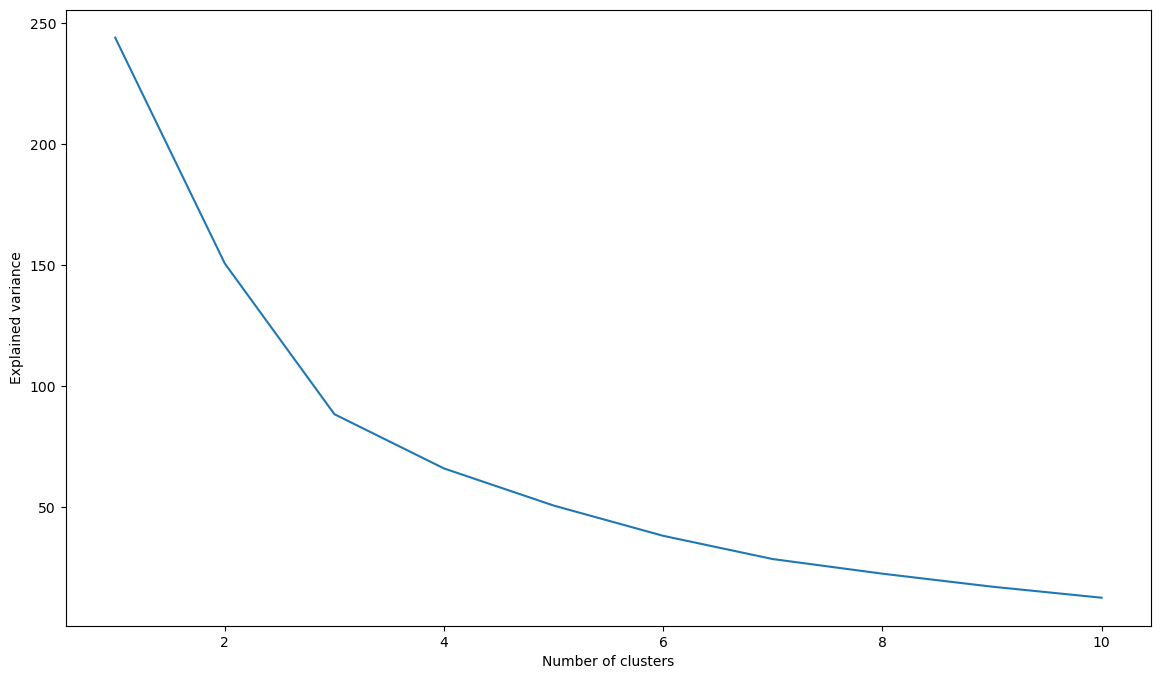

In [65]:
from sklearn.cluster import KMeans

# Create an empty list to store the explained variance for each number of clusters
explained_variance = []

# Fit the KMeans model with different numbers of clusters and store the explained variance
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dissimilarity_matrices)
    explained_variance.append(kmeans.inertia_)

# Plot the explained variance as a function of the number of clusters
plt.figure(figsize=(14, 8))
plt.plot(range(1, 11), explained_variance)
plt.xlabel('Number of clusters')
plt.ylabel('Explained variance')
plt.show()

In [258]:
distance_matrices = whole_matrix_bact
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=5, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z, t=4, criterion='maxclust')
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dissimilarity_matrices)

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=4)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names})

x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(6):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster',
                    labels={'x':'X axis','y':'Y axis','color':'Cluster'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    title='PCA and Clustering of the bacteria')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers+text', marker=dict(color='black', size=15, symbol='x'), text=['cluster ' + str(i) for i in range(k)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()

[2 1 1 1 2 4 1 2 2 4 4 4 4 2 2 1 3 1 3 3]


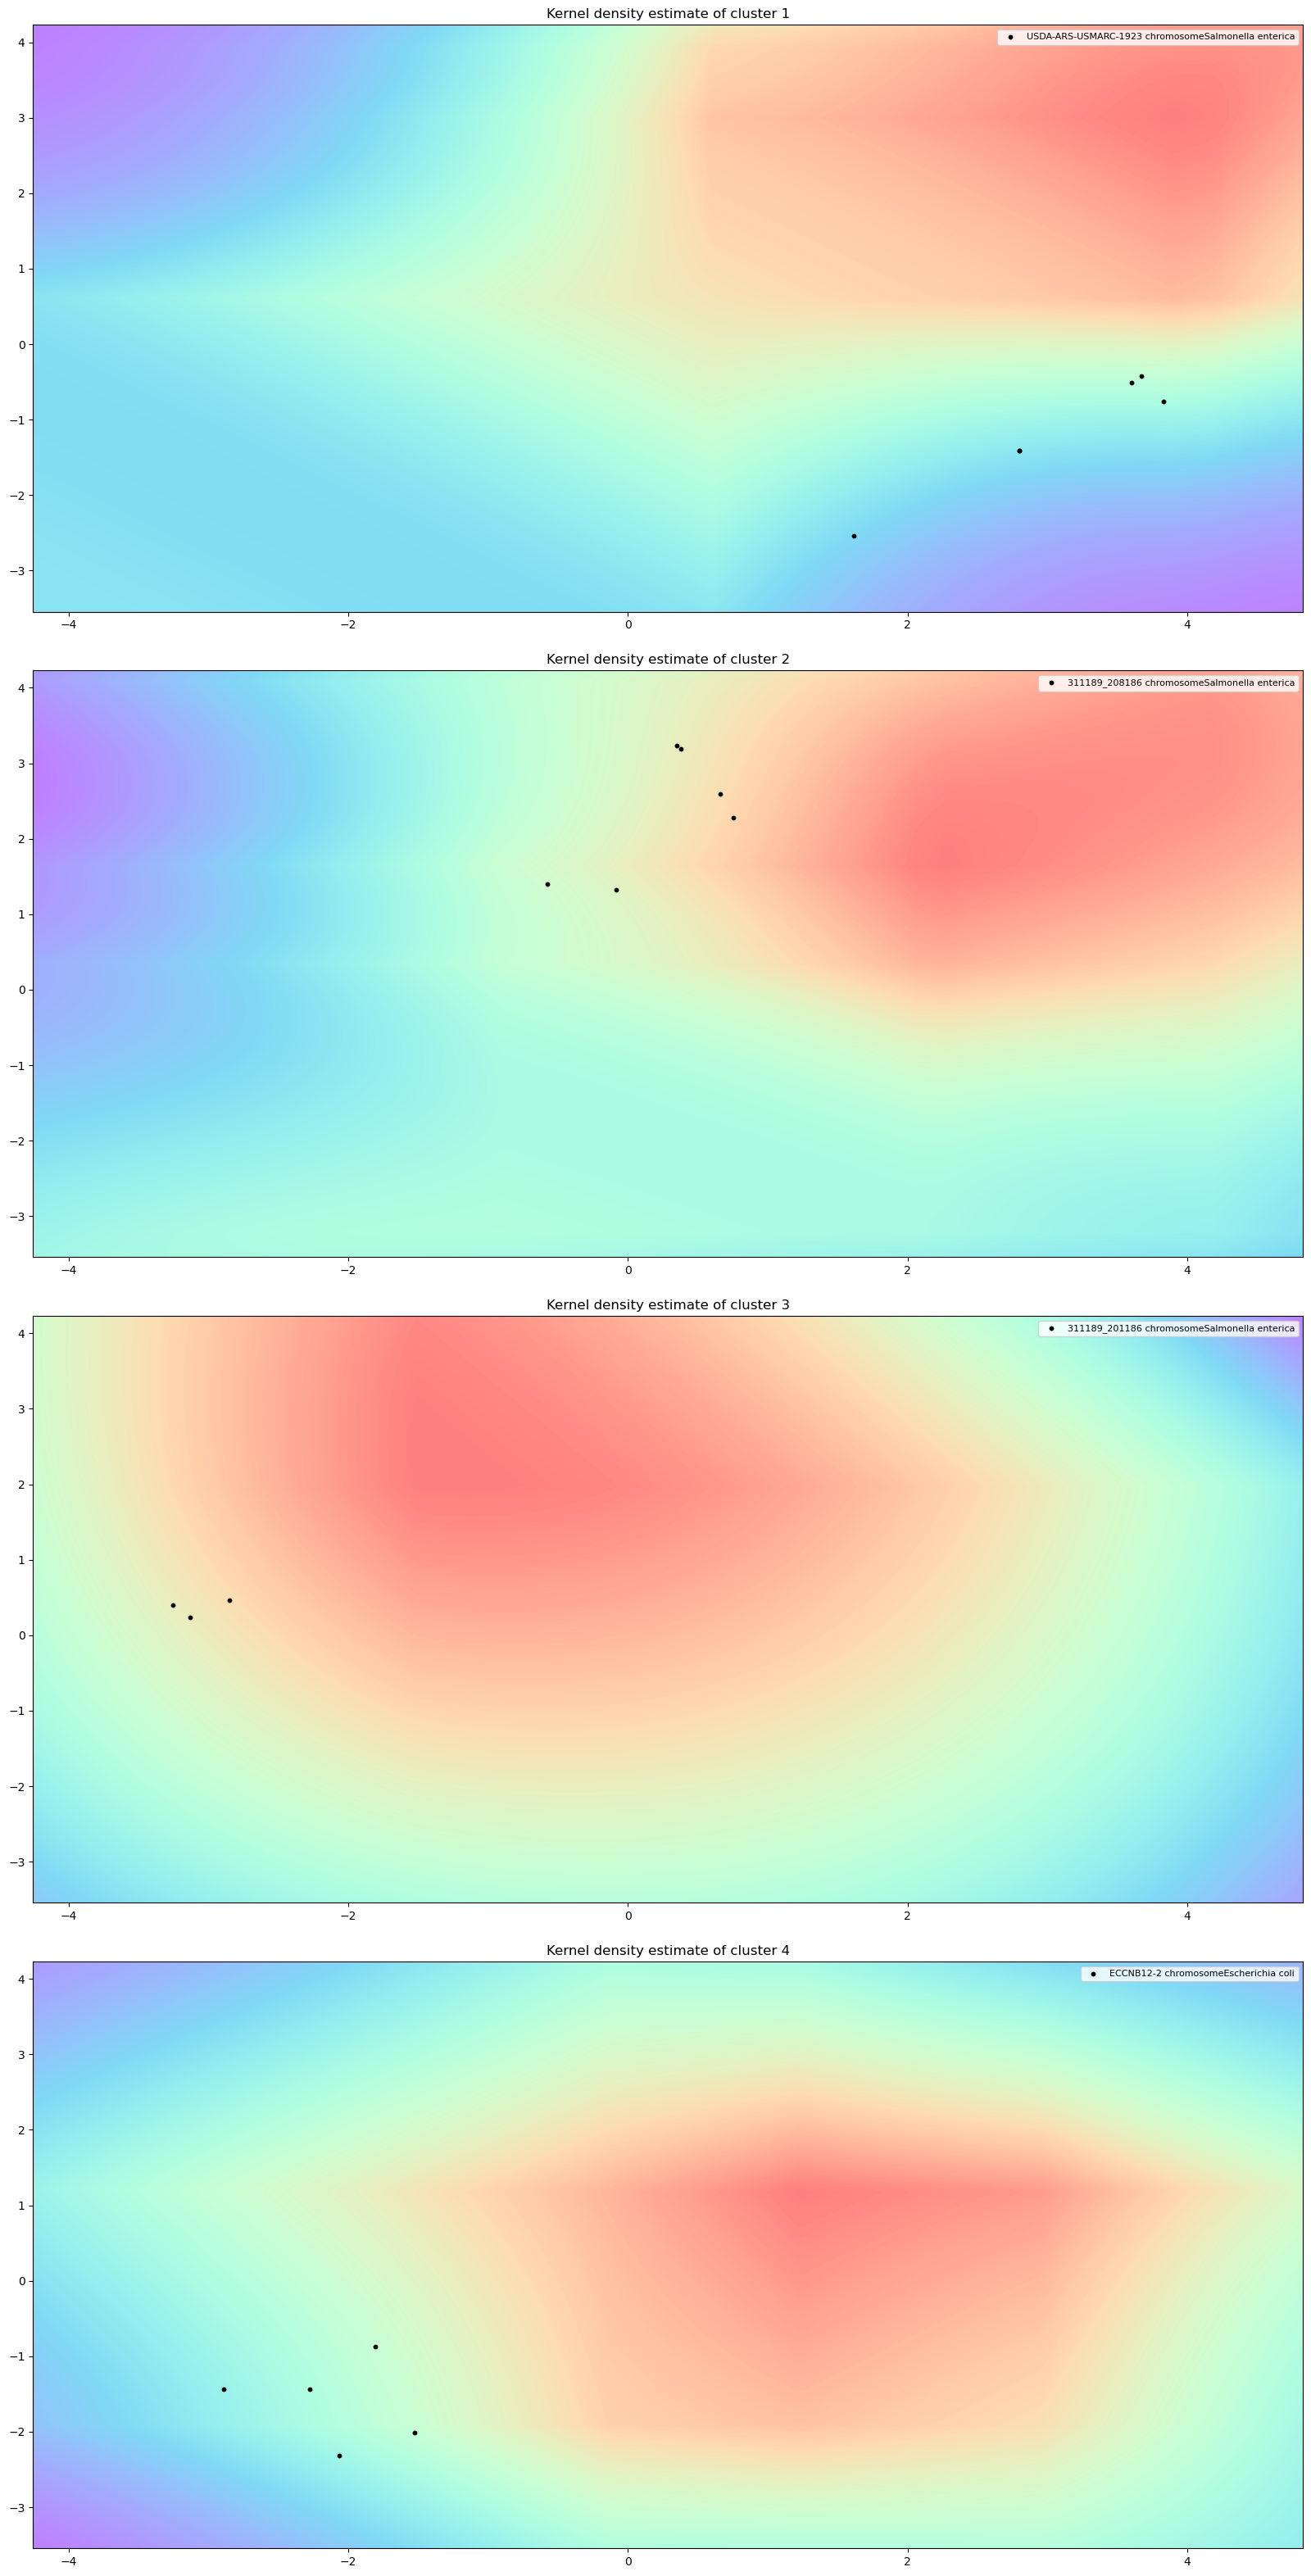

In [203]:
fig, axs = plt.subplots(4, 1, figsize=(20, 40))

for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth= 0.8, metric = best_metric).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        X, Y = np.meshgrid(x_grid, y_grid)
        XY = np.c_[X.ravel(), Y.ravel()]
        kde_vals = np.exp(kde.score_samples(XY))
        axs[i-1].imshow(kde_vals.reshape(X.shape), origin='lower', extent=[x_grid_min - 1, x_grid_max + 1, y_grid_min - 1, y_grid_max + 1], aspect='auto', alpha=0.5, cmap='rainbow')
        axs[i-1].scatter(cluster_i[:, 0], cluster_i[:, 1], label=names[i], s=10, color='black')
        axs[i-1].legend(loc='best', fontsize=8)
        axs[i-1].set_title('Kernel density estimate of cluster ' + str(i))
        
plt.xlim(x_grid_min - 1, x_grid_max + 1) # set the x axis limit
plt.ylim(y_grid_min - 1, y_grid_max + 1) # set the y axis limit
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

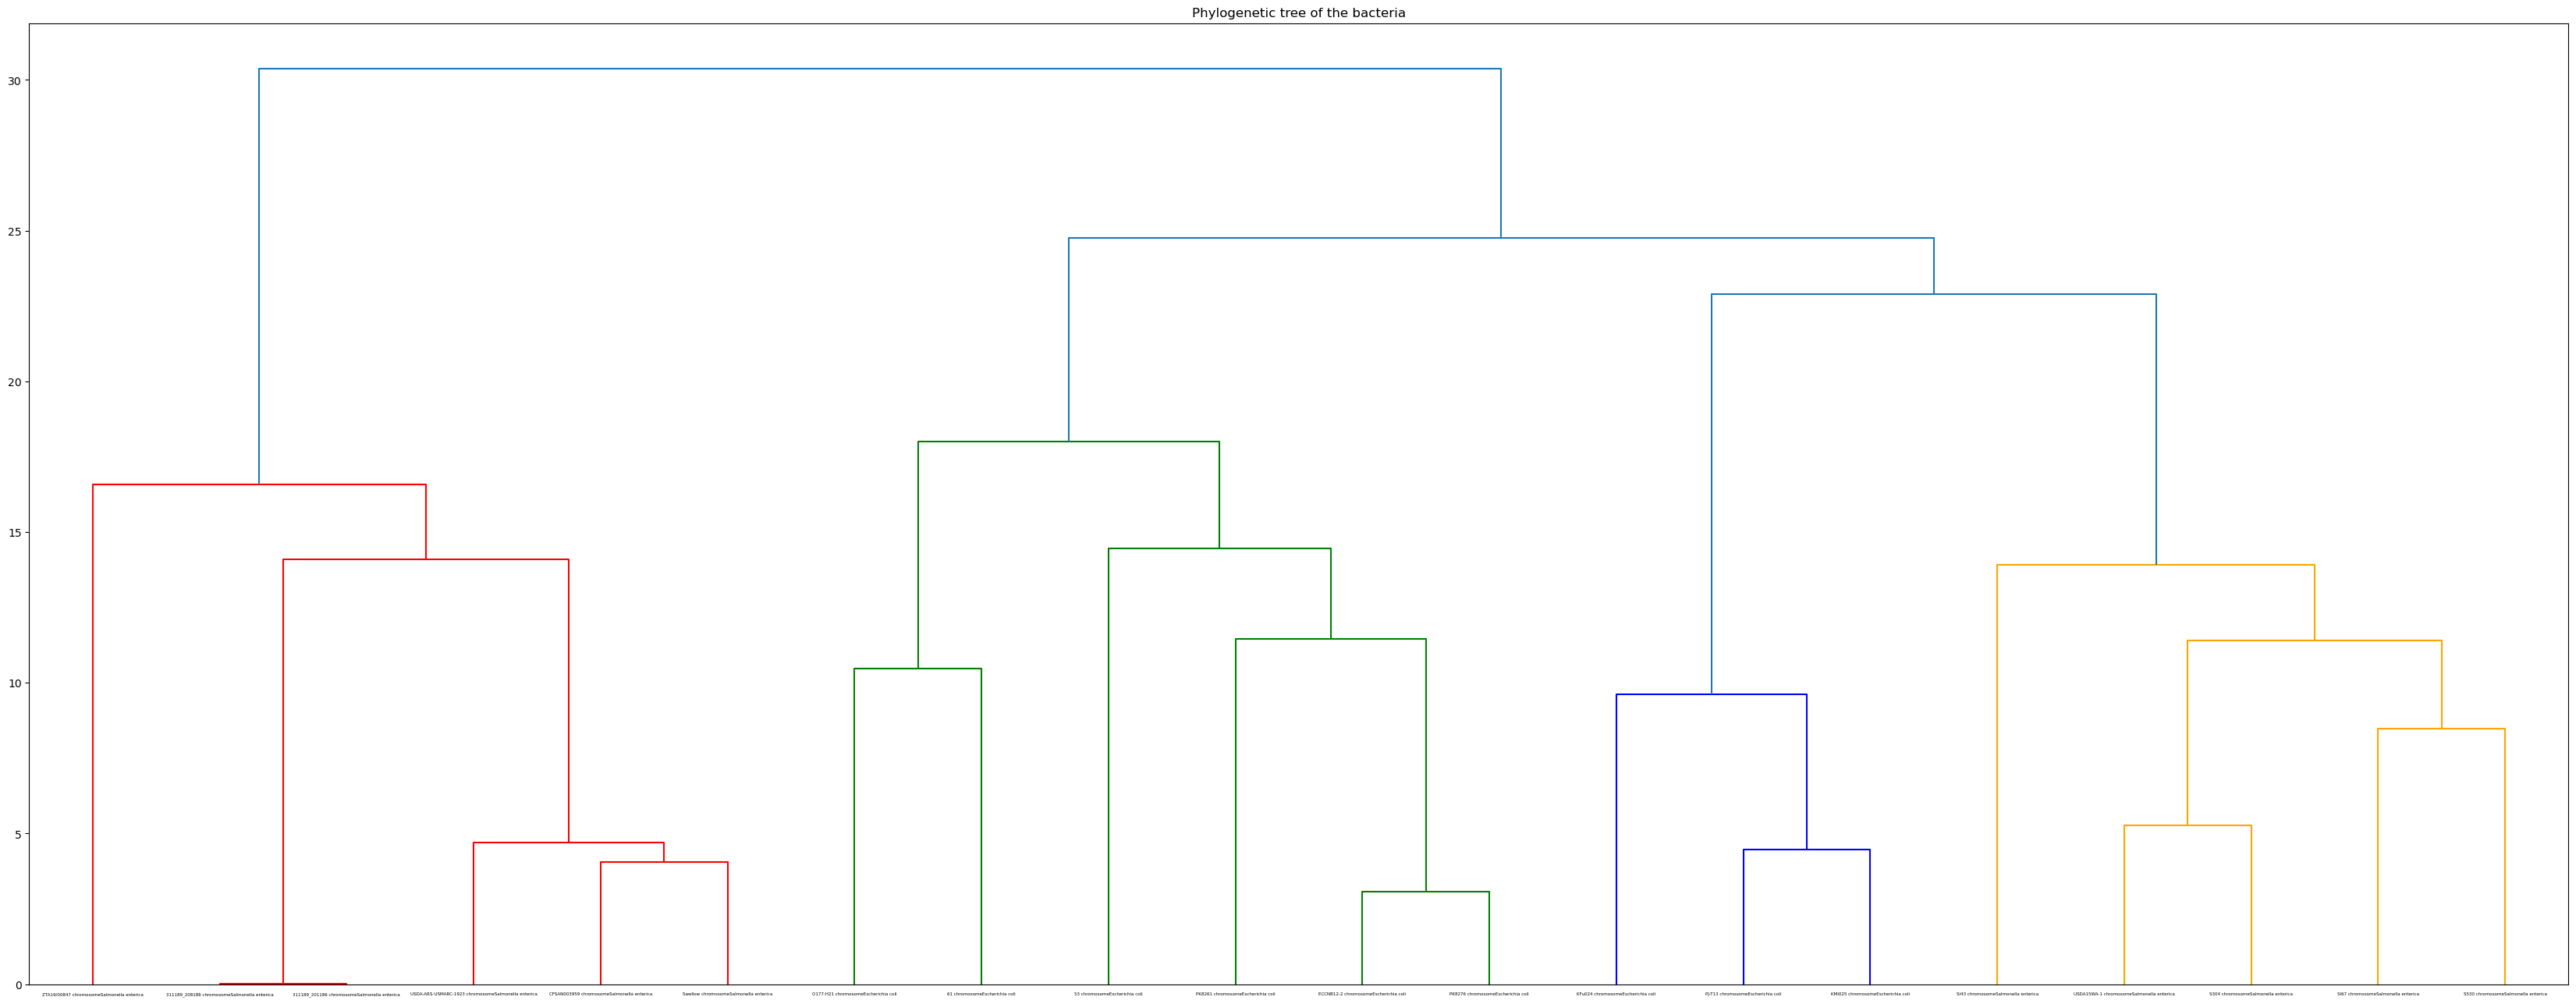

In [246]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import plotly.express as px
import networkx as nx
from scipy.spatial import ConvexHull

# step 1: Transform the distance matrices
distance_matrices = whole_matrix_bact
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=4, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_

Z = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z, t=4, criterion='maxclust')
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 16))
dendro = dendrogram(Z, leaf_label_func=leaf_label_func)
for tick in ax.get_xticklabels():
    tick.set_fontsize(4)
plt.title('Phylogenetic tree of the bacteria')
plt.show()

/home/antoine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/antoine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



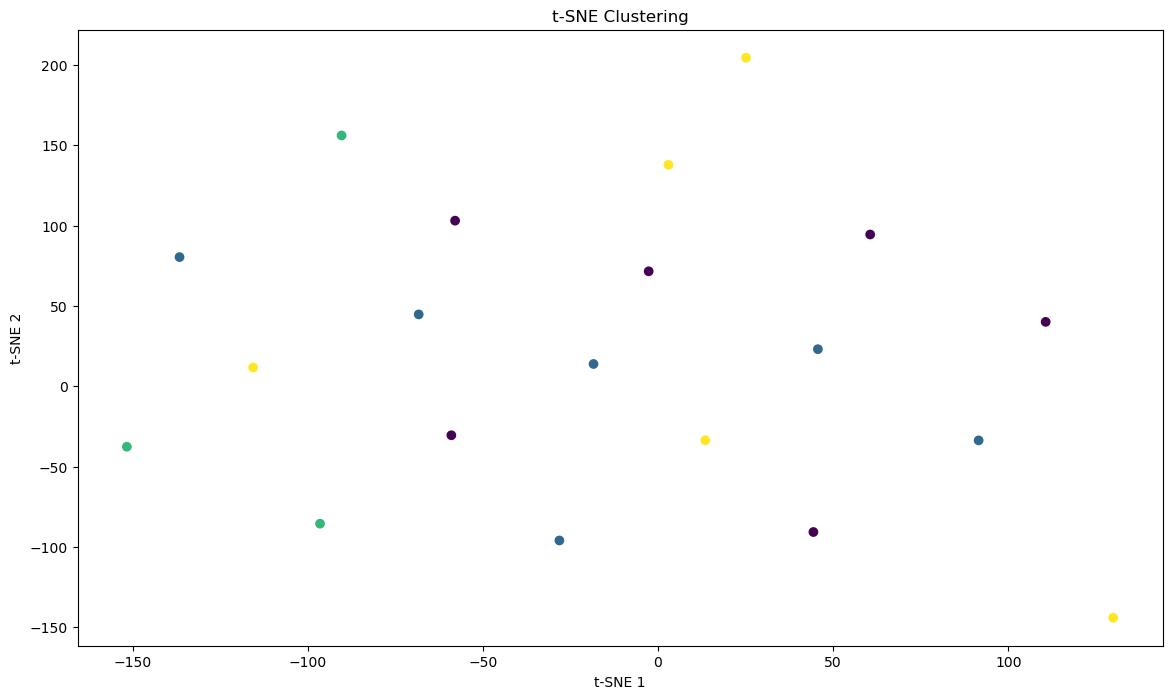

In [211]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(dissimilarity_matrices)
fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(tsne_result[:,0],tsne_result[:,1],c=hierarchical_labels)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Clustering')
plt.show()

In [257]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = np.mean(distance_matrices)
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names[i])

# Iterate over the distance matrices and add edges based on the threshold distance
for i in range(len(distance_matrices)):
    for j in range(i+1, len(distance_matrices)):
        if np.all(distance_matrices[i][j] <= threshold_distance):
            G.add_edge(i, j)

# Create a layout for the graph
pos = nx.spring_layout(G)

# Create a scatter plot of the graph
fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                 mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                 textposition="bottom center",
                                 marker=dict(size=10, color='blue'))])

# Add edges to the scatter plot
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color='orange')))

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria'
)
fig.show()
